# Описание проекта

## ТЗ

Требуется разработать прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В распоряжении имеются данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Требуется:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Структура наименований признаков

*Технологический процесс*

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

*Параметры этапов*

- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

*Наименование признаков*

Наименование признаков должно быть такое:

    [этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Chek-list

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке

# Импорт библиотек и зависимостей

In [1]:
# Libraries import.
import random
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

# 1. Подготовка данных

## 1.1 Импорт данных и первичный обзор

### 1.1.1 Импорт

In [2]:
# Data import.
try:
    data_full = pd.read_csv('/datasets/gold_recovery_full.csv.', index_col='date', parse_dates=True)
    data_train = pd.read_csv('/datasets/gold_recovery_train.csv.', index_col='date', parse_dates=True)
    data_test = pd.read_csv('/datasets/gold_recovery_test.csv.', index_col='date', parse_dates=True)
except:
    data_full = pd.read_csv(
        '/content/drive/My Drive/Colab Notebooks/common_project_2/gold_recovery_full.csv',
        index_col='date', parse_dates=True)
    data_train = pd.read_csv(
        '/content/drive/My Drive/Colab Notebooks/common_project_2/gold_recovery_train.csv',
        index_col='date', parse_dates=True)
    data_test = pd.read_csv(
        '/content/drive/My Drive/Colab Notebooks/common_project_2/gold_recovery_test.csv',
        index_col='date', parse_dates=True)

# Set display options.
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
# Data first look.
data_full.head()

final.output.concentrate_ag  final.output.concentrate_pb  \
date                                                                            
2016-01-15 00:00:00                     6.055403                     9.889648   
2016-01-15 01:00:00                     6.029369                     9.968944   
2016-01-15 02:00:00                     6.055926                    10.213995   
2016-01-15 03:00:00                     6.047977                     9.977019   
2016-01-15 04:00:00                     6.148599                    10.142511   

                     final.output.concentrate_sol  \
date                                                
2016-01-15 00:00:00                      5.507324   
2016-01-15 01:00:00                      5.257781   
2016-01-15 02:00:00                      5.383759   
2016-01-15 03:00:00                      4.858634   
2016-01-15 04:00:00                      4.939416   

                     final.output.concentrate_au  final.output.recovery  \
date                                                                      
2016-01-15 00:00:00                    42.192020              70.541216   
2016-01-15 01:00:00                    42.701629              69.266198   
2016-01-15 02:00:00                    42.657501              68.116445   
2016-01-15 03:00:00                    42.689819              68.347543   
2016-01-15 04:00:00                    42.774141              66.927016   

                     final.output.tail_ag  final.output.tail_pb  \
date                                                              
2016-01-15 00:00:00             10.411962              0.895447   
2016-01-15 01:00:00             10.462676              0.927452   
2016-01-15 02:00:00             10.507046              0.953716   
2016-01-15 03:00:00             10.422762              0.883763   
2016-01-15 04:00:00             10.360302              0.792826   

                     final.output.tail_sol  final.output.tail_au  \
date                                                               
2016-01-15 00:00:00              16.904297              2.143149   
2016-01-15 01:00:00              16.634514              2.224930   
2016-01-15 02:00:00              16.208849              2.257889   
2016-01-15 03:00:00              16.532835              2.146849   
2016-01-15 04:00:00              16.525686              2.055292   

                     primary_cleaner.input.sulfate  \
date                                                 
2016-01-15 00:00:00                     127.092003   
2016-01-15 01:00:00                     125.629232   
2016-01-15 02:00:00                     123.819808   
2016-01-15 03:00:00                     122.270188   
2016-01-15 04:00:00                     117.988169   

                     primary_cleaner.input.depressant  \
date                                                    
2016-01-15 00:00:00                         10.128295   
2016-01-15 01:00:00                         10.296251   
2016-01-15 02:00:00                         11.316280   
2016-01-15 03:00:00                         11.322140   
2016-01-15 04:00:00                         11.913613   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-01-15 00:00:00                             7.25   
2016-01-15 01:00:00                             7.25   
2016-01-15 02:00:00                             7.25   
2016-01-15 03:00:00                             7.25   
2016-01-15 04:00:00                             7.25   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-01-15 00:00:00                        0.988759   
2016-01-15 01:00:00                        1.002663   
2016-01-15 02:00:00                        0.991265   
2016-01-15 03:00:00                        0.996739   
2016-01-15 04:00:00                        1.009869   

                     primary_cleaner.output.concen

### 1.1.2 Общая информация

In [4]:
# Data-info review.
for data in [data_full, data_train, data_test]:
    print(data.info())
    print('#################################################################################')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                     

Данные имеют вещественный тип, количество признаков велико. Тестовые данные имеют меньшее количество признаков.

### 1.1.3 Количество пропусков

In [5]:
def nan_counts(data):
    '''This function calculate count & part of nans in inputed data.
        Input:
        data — the intrested data.

        Output:
        table with count & part of nans.'''
        
    nan_stat = pd.DataFrame(data.isna().sum())
    nan_stat['part_%'] = nan_stat[0] * 100 / data.shape[0]
    nan_stat.columns = ['nan_counts', 'part_%']
    return nan_stat[(nan_stat['part_%'] > 0)].sort_values('part_%', ascending = False)

In [6]:
# Data-nans review.
i = 0
for data in [data_full, data_train, data_test]:
    if i == 0:
        data_name = 'full'
    elif i == 1:
        data_name = 'train'
    elif i == 2:
        data_name = 'test'
    print(f"Пропуски в {data_name}:")
    print(nan_counts(data))
    print()
    i += 1

Пропуски в full:
                                                    nan_counts     part_%
rougher.output.recovery                                   3119  13.730410
rougher.output.tail_ag                                    2737  12.048776
rougher.output.tail_au                                    2736  12.044374
rougher.output.tail_sol                                   2736  12.044374
rougher.input.floatbank11_xanthate                        2257   9.935728
secondary_cleaner.output.tail_sol                         2215   9.750836
final.output.recovery                                     1963   8.641486
rougher.calculation.au_pb_ratio                           1627   7.162353
primary_cleaner.input.sulfate                             1609   7.083113
primary_cleaner.input.depressant                          1546   6.805776
rougher.input.floatbank10_sulfate                         1301   5.727241
primary_cleaner.input.xanthate                            1151   5.066913
primary_cleaner.outpu

Данные содержат много пропусков. Пропусков в тесте гораздо меньше, чем в обучающей выборке. Требуется выяснить, каким образом пропуски могут быть заполнены, насколько критично их удаление. 

Предположительно пропуски могут быть заполнены с помощью метода 'ffill', поскольку данные индексируются датой и временем получения информации (признак date), и  соседние по времени параметры часто похожи.

### 1.1.4 Явные дубликаты

In [7]:
# Chek for duplicates.
i = 0
for data in [data_full, data_train, data_test]:
    if i == 0:
        data_name = 'full'
    elif i == 1:
        data_name = 'train'
    elif i == 2:
        data_name = 'test'
    print('Явных дубликатов в {}: {}'.format(data_name, data.duplicated().sum()))
    i += 1

Явных дубликатов в full: 22
Явных дубликатов в train: 16
Явных дубликатов в test: 6


In [8]:
# Drop duplicates.
data_full = data_full.drop_duplicates()
data_train = data_train.drop_duplicates()
data_test = data_test.drop_duplicates()

In [9]:
# Chek after drop.
i = 0
for data in [data_full, data_train, data_test]:
    if i == 0:
        data_name = 'full'
    elif i == 1:
        data_name = 'train'
    elif i == 2:
        data_name = 'test'
    print('Явных дубликатов в {}: {}'.format(data_name, data.duplicated().sum()))
    i += 1

Явных дубликатов в full: 0
Явных дубликатов в train: 0
Явных дубликатов в test: 0


## 1.2 Проверка правильности расчёта эффективности обогащения

Для проверки правильности расчёта искомого параметра следует убедиться, что в необходимых столбцах отсутствуют пропуски.

In [10]:
nan_counts(data_train)[:10]

nan_counts     part_%
rougher.output.recovery                   2557  15.180480
rougher.output.tail_ag                    2234  13.262883
rougher.output.tail_sol                   2233  13.256946
rougher.output.tail_au                    2233  13.256946
secondary_cleaner.output.tail_sol         1970  11.695559
rougher.input.floatbank11_xanthate        1888  11.208739
final.output.recovery                     1505   8.934932
primary_cleaner.input.sulfate             1291   7.664450
primary_cleaner.input.depressant          1246   7.397293
rougher.calculation.au_pb_ratio           1226   7.278556

In [11]:
def recovery_calc(data):
    '''This function calculate recovery for inputed data.
        Input:
        row — series with needed value:
        C = row['rougher.output.concentrate_au'] — part of Au in concentrate after rougher/cleaning;
        F = row['rougher.input.feed_au'] — part of Au in raw/concentrate before rougher/cleaning;
        T = row['rougher.output.tail_au'] — part of Au in tails after rougher/cleaning.

        Output:
        values of recovery.'''
    # Drop nans in columns needed to calc & chek recovery.    
    data = data.dropna()   

    # Calculate recovery.
    C = data['rougher.output.concentrate_au']
    F = data['rougher.input.feed_au']
    T = data['rougher.output.tail_au']
    recovery = ((C*(F - T)) / (F[F != 0]*(C - T)))*100
    return recovery

In [12]:
# MAE calculation.
mae_train = mean_absolute_error(data_train.dropna()['rougher.output.recovery'], recovery_calc(data_train))
print(f'MAE на тренировочной выборке:{mae_train}')

MAE на тренировочной выборке:9.460144184559453e-15


Полученное значение MAE говорит о том, что разница между исходными и посчитанными данными крайне мала.

In [13]:
def float_data_analyzer(data, columns, bins, round_lim):
    '''This function print and plot distribution of float-columns from inputing data.
        Input:
        data — the intrested data (DataFrame),
        columns — list of intrested columns from data,
        bins — number of bins for hist,
        round_lim — precision of describtion-rounding.
        
        Output:
        stat-describtion, boxplot and hist for each column.'''
        
    for column in columns:
        print(data[column].describe().round(round_lim))
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        ax[0].set_title(f'Диаграмма размаха {column}')
        sns.boxplot(y=column, data=data, ax=ax[0], palette='Blues')
        sns.distplot(data[column], bins=bins, color='indigo', ax=ax[1])
        ax[1].set_title(f'Распределение {column}')
        plt.show()

Статистика по исходным данным
count    14287.00
mean        82.39
std         15.10
min          0.00
25%         79.82
50%         85.24
75%         90.13
max        100.00
Name: rougher.output.recovery, dtype: float64


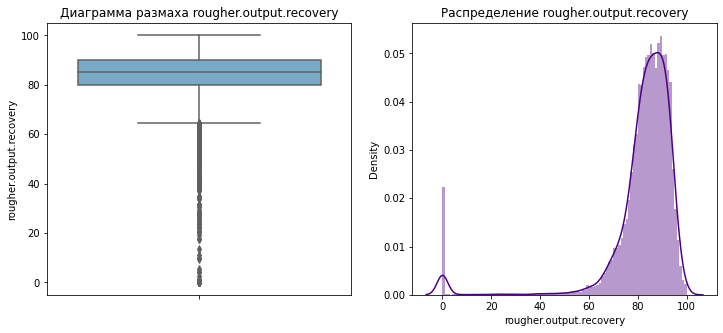

In [14]:
print('Статистика по исходным данным')
float_data_analyzer(data_train, ['rougher.output.recovery'], 100, 2)

Статистика по рассчитанным данным
count    11017.00
mean        82.74
std         13.59
min         -0.00
25%         80.00
50%         84.85
75%         89.64
max        100.00
Name: rougher.output.recovery_chek, dtype: float64


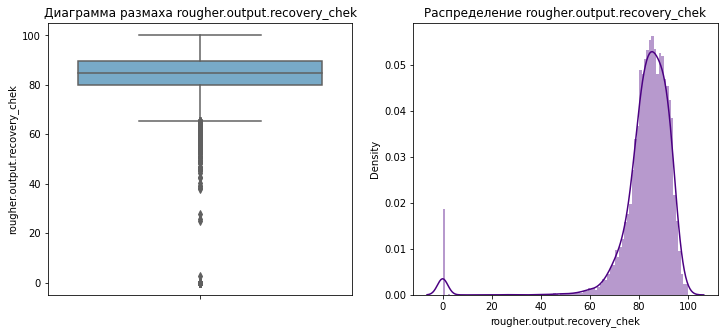

In [15]:
print('Статистика по рассчитанным данным')
float_data_analyzer(pd.DataFrame(recovery_calc(data_train), columns=['rougher.output.recovery_chek']),
                    ['rougher.output.recovery_chek'], 100, 2)

Распределения выглядят одинаково. Интересным выглядит пик распределения в районе нуля. Возможно это следствие ошибки датчиков. 

Также наблюдается большое количество выбросов: recovery < 65. 

## 1.3 Разница между признаками full/train и test

In [16]:
# Difference between features.
#set(data_full.columns).difference(set(data_test.columns))
set(data_train.columns).difference(set(data_test.columns))

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Для обучения моделей потребуются те столбцы, данные по которым имеются в data_test. Следовательно, нужно выделить те признаки в обучающей выборке, на которых следует проводить обучение, т.е. необходимо найти общие признаки.

In [17]:
# Union of train & test features.
features_list = sorted(list(set(data_train.columns).intersection(set(data_test.columns))))
features_list

['primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

В тестовых данных отсутствуют столбцы, содержащие выходные данные после каждого из этапов (флотация, первичная и вторичная очистки, финальные показатели), а также расчётные параметры установок. Как следует из ТЗ, это связано с тем, что некоторые параметры  замеряются и/или рассчитываются значительно позже. 

Столбцы 'final.output.recovery' и 'rougher.output.recovery' являются целевыми признаками и могут быть добавлены в тестовую выборку из полной.

In [18]:
target_list = ['final.output.recovery', 'rougher.output.recovery']
data_test = data_test.merge(data_full[target_list], on='date', how='left')

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5850 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5850 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 

## 1.4 Обработка данных

Как было отмечено ранее, в данных имеется множество пропусков. Эти пропуски преимущественно расположены последовательно. Вероятной причиной появления пропусков может быть ограниченная чувствительность датчиков для измерения признаков: очень малые значения не фиксируются. Кроме того возможны ошибки в работе датчиков: простой, пропуск отдельных измерений.

Предлагается заполнить пропуски методом 'ffill' на основании схожести данных, полученных в близкое время. Чтобы проверить насколько данный подход корректен, предлагается построить распределения признаков до и после заполнения пропусков.

In [20]:
# To plot or not to plot.
PLOTS_ARE_NEEDED = True
#PLOTS_ARE_NEEDED = False

### 1.4.1 Распределения в обучающей выборке

In [21]:
if PLOTS_ARE_NEEDED:
     float_data_analyzer(data_train, data_train.columns, bins=100, round_lim=2)
else:
    print('Параметр plots_are_needed равен', PLOTS_ARE_NEEDED, ', измените значение на True чтобы увидеть графики')

Output hidden; open in https://colab.research.google.com to view.

### 1.4.2 Распределения в тренировочной выборке после заполнения пропусков

In [22]:
data_train = data_train.fillna(method='ffill')

In [23]:
if PLOTS_ARE_NEEDED:
    float_data_analyzer(data_train, data_train.columns, bins=100, round_lim=2)
else:
    print('Параметр plots_are_needed равен', PLOTS_ARE_NEEDED, ', измените значение на True чтобы увидеть графики')

Output hidden; open in https://colab.research.google.com to view.

### 1.4.3 Распределения в тестовой выборке

count    5554.00
mean      170.52
std        49.61
min         0.00
25%       143.34
50%       176.10
75%       207.24
max       274.41
Name: primary_cleaner.input.sulfate, dtype: float64


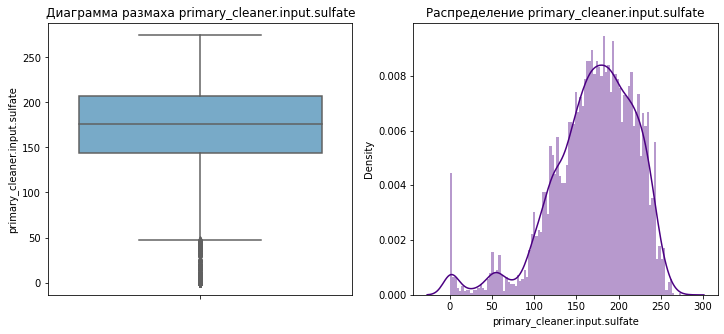

count    5572.00
mean        8.48
std         3.35
min         0.00
25%         6.41
50%         8.02
75%        10.02
max        40.02
Name: primary_cleaner.input.depressant, dtype: float64


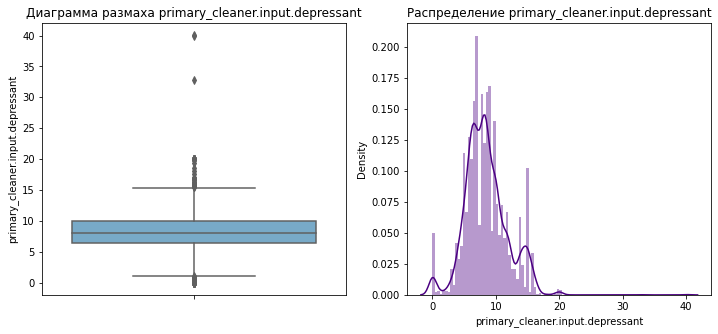

count    5850.00
mean        7.26
std         0.61
min         5.65
25%         6.88
50%         7.25
75%         7.65
max        15.50
Name: primary_cleaner.input.feed_size, dtype: float64


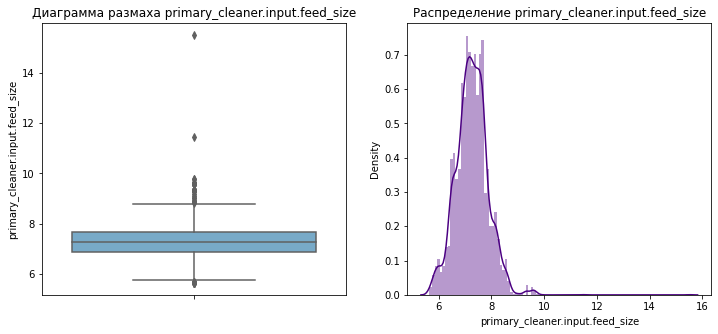

count    5690.00
mean        1.32
std         0.69
min         0.00
25%         0.89
50%         1.18
75%         1.76
max         5.43
Name: primary_cleaner.input.xanthate, dtype: float64


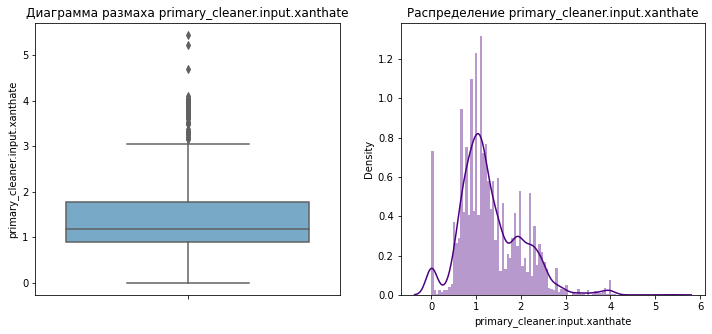

count    5840.00
mean     1481.99
std       310.45
min         0.00
25%      1497.19
50%      1554.66
75%      1601.68
max      2212.43
Name: primary_cleaner.state.floatbank8_a_air, dtype: float64


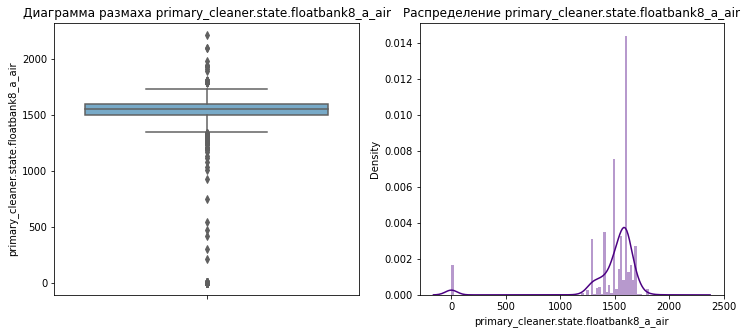

count    5840.00
mean     -509.06
std        61.34
min      -799.77
25%      -500.46
50%      -500.00
75%      -499.58
max       -57.20
Name: primary_cleaner.state.floatbank8_a_level, dtype: float64


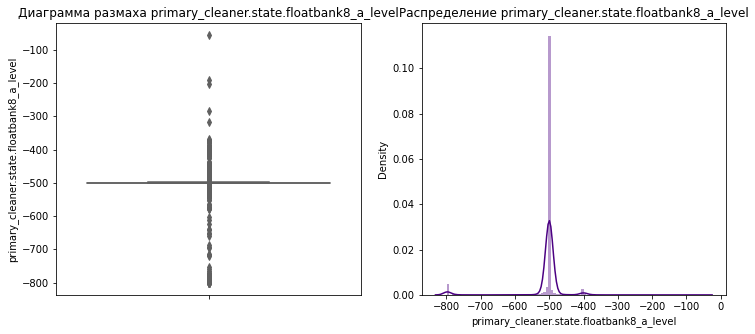

count    5840.00
mean     1486.91
std       313.22
min         0.00
25%      1497.15
50%      1553.27
75%      1601.78
max      1975.15
Name: primary_cleaner.state.floatbank8_b_air, dtype: float64


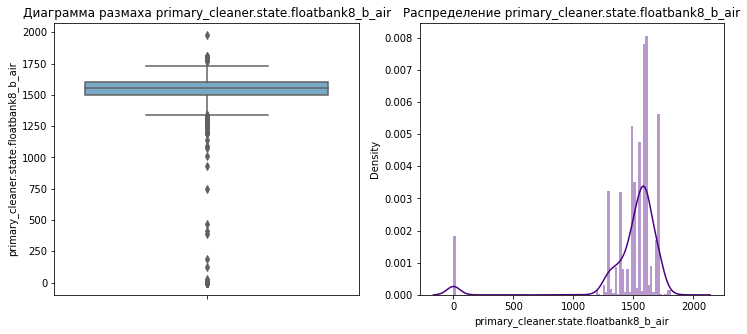

count    5840.00
mean     -511.74
std        67.14
min      -800.03
25%      -500.94
50%      -500.07
75%      -499.32
max      -142.53
Name: primary_cleaner.state.floatbank8_b_level, dtype: float64


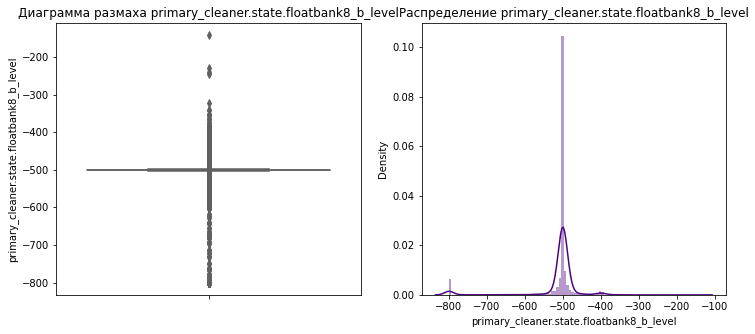

count    5840.00
mean     1468.50
std       309.98
min         0.00
25%      1437.05
50%      1546.16
75%      1600.79
max      1715.05
Name: primary_cleaner.state.floatbank8_c_air, dtype: float64


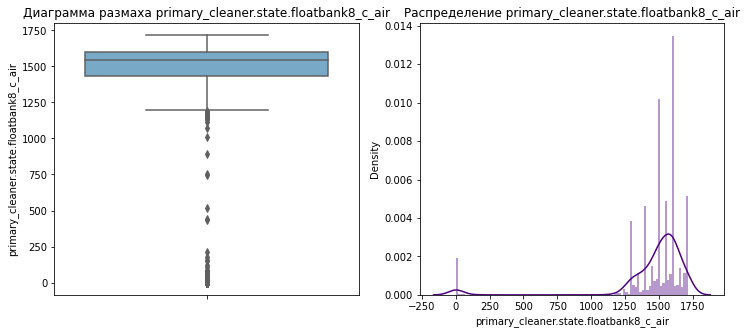

count    5840.00
mean     -509.74
std        62.67
min      -800.00
25%      -501.30
50%      -500.08
75%      -499.01
max      -150.94
Name: primary_cleaner.state.floatbank8_c_level, dtype: float64


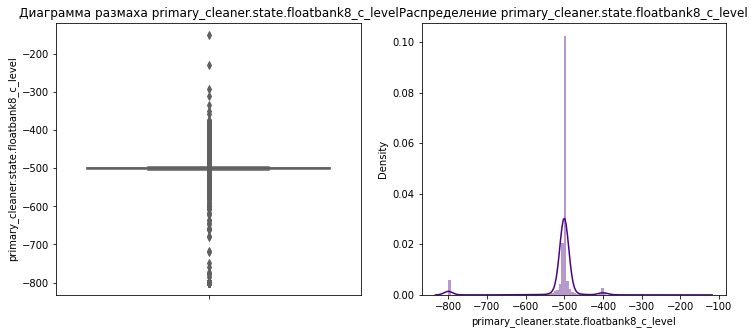

count    5840.00
mean     1486.40
std       313.73
min         0.00
25%      1498.41
50%      1552.09
75%      1600.78
max      1913.26
Name: primary_cleaner.state.floatbank8_d_air, dtype: float64


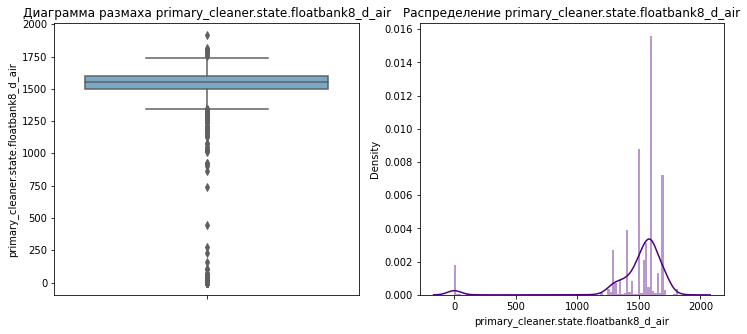

count    5840.00
mean     -510.72
std        65.42
min      -799.84
25%      -500.55
50%      -500.05
75%      -499.61
max       -32.45
Name: primary_cleaner.state.floatbank8_d_level, dtype: float64


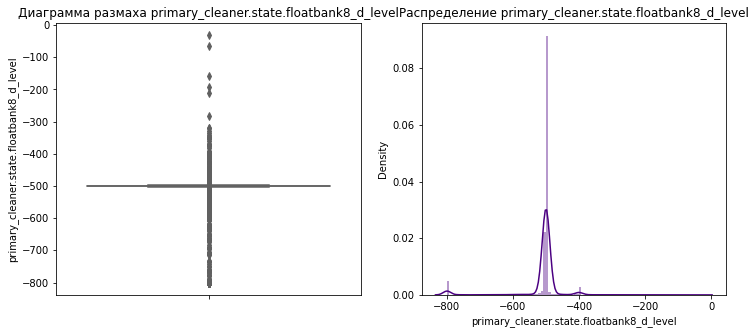

count    5840.00
mean        8.74
std         2.99
min         0.00
25%         7.60
50%         9.63
75%        10.57
max        14.41
Name: rougher.input.feed_ag, dtype: float64


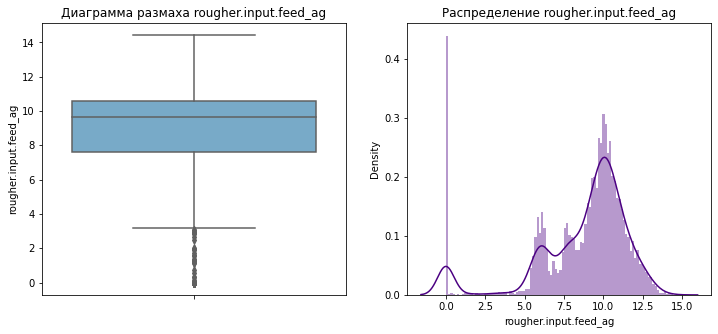

count    5840.00
mean        3.55
std         1.33
min         0.00
25%         3.08
50%         3.68
75%         4.24
max         6.91
Name: rougher.input.feed_pb, dtype: float64


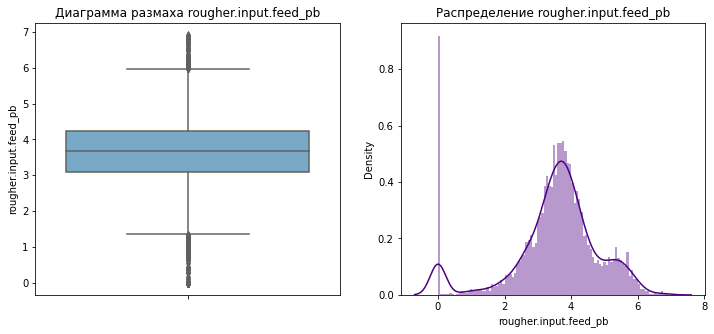

count    5816.00
mean      458.49
std       155.96
min         0.00
25%       399.78
50%       489.53
75%       568.11
max       707.36
Name: rougher.input.feed_rate, dtype: float64


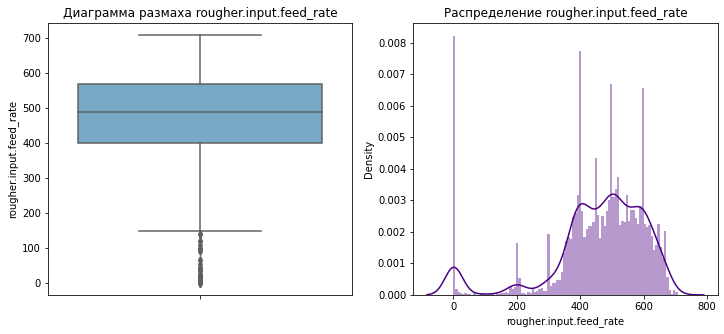

count    5834.00
mean       55.94
std        22.72
min         0.05
25%        43.89
50%        50.00
75%        61.64
max       477.45
Name: rougher.input.feed_size, dtype: float64


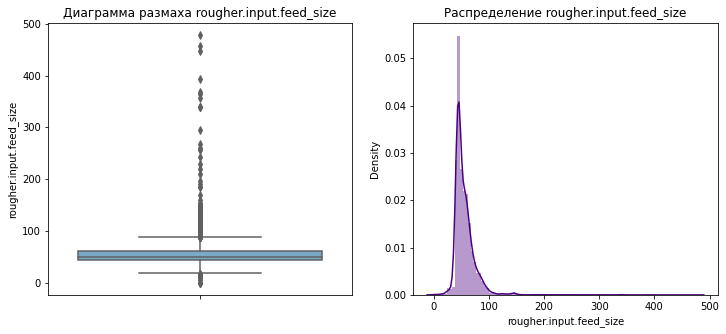

count    5789.00
mean       35.11
std        10.79
min         0.00
25%        33.38
50%        37.34
75%        41.39
max        53.48
Name: rougher.input.feed_sol, dtype: float64


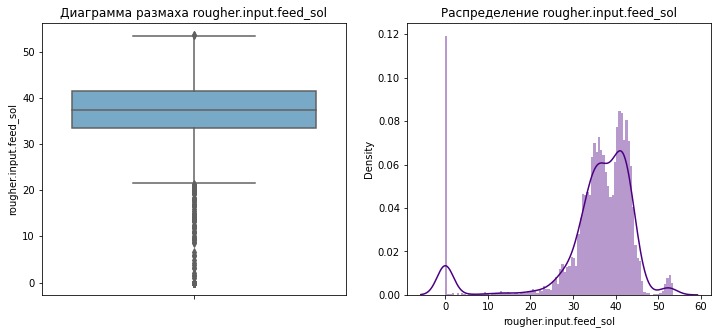

count    5840.00
mean        8.70
std         2.80
min         0.00
25%         7.76
50%         9.45
75%        10.38
max        13.73
Name: rougher.input.feed_au, dtype: float64


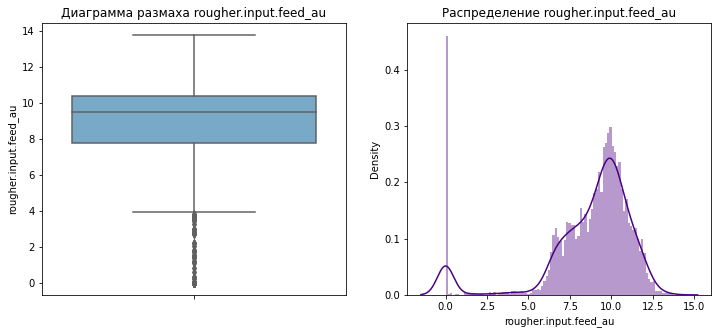

count    5599.00
mean       13.44
std         4.00
min         0.00
25%        11.01
50%        14.00
75%        16.67
max        24.28
Name: rougher.input.floatbank10_sulfate, dtype: float64


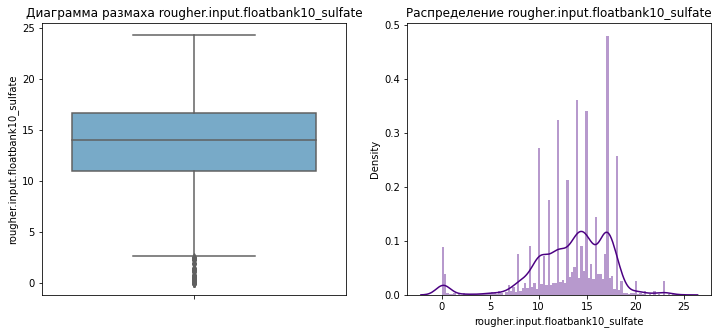

count    5733.00
mean        6.17
std         1.67
min         0.00
25%         5.88
50%         6.40
75%         7.00
max        13.04
Name: rougher.input.floatbank10_xanthate, dtype: float64


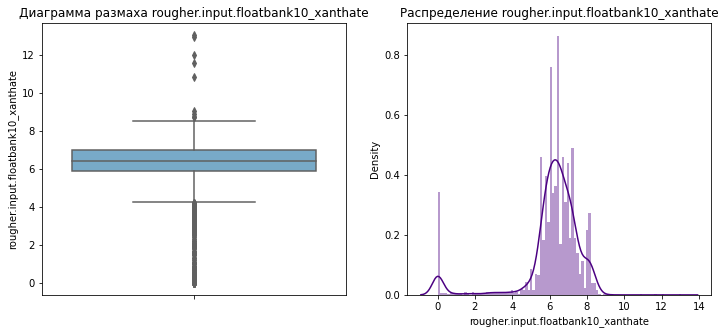

count    5801.00
mean       13.06
std         4.53
min         0.00
25%        11.00
50%        14.00
75%        16.38
max        28.95
Name: rougher.input.floatbank11_sulfate, dtype: float64


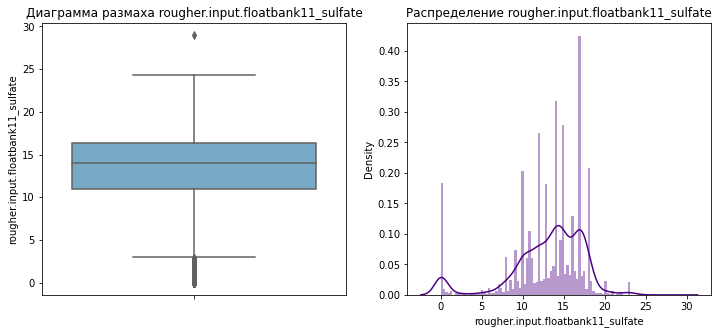

count    5503.00
mean        6.42
std         1.12
min         0.00
25%         5.99
50%         6.50
75%         7.01
max        18.71
Name: rougher.input.floatbank11_xanthate, dtype: float64


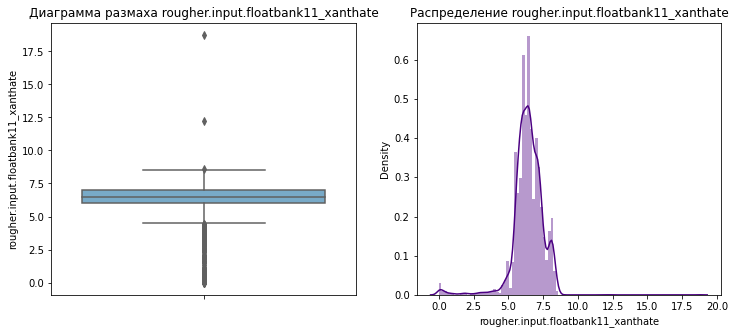

count    5839.00
mean     1016.29
std       226.49
min        -0.12
25%       998.97
50%      1000.33
75%      1005.09
max      1423.27
Name: rougher.state.floatbank10_a_air, dtype: float64


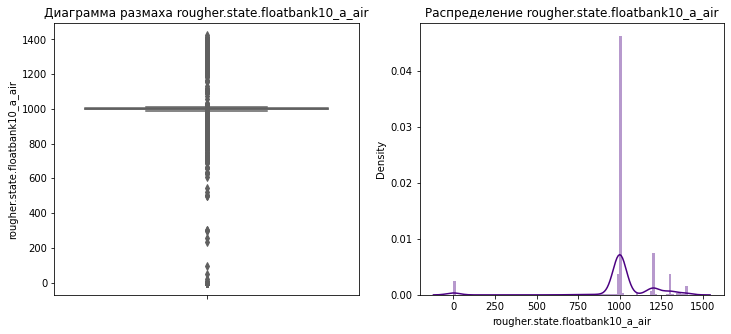

count    5840.00
mean     -404.98
std       100.95
min      -657.95
25%      -499.97
50%      -399.82
75%      -300.07
max      -273.78
Name: rougher.state.floatbank10_a_level, dtype: float64


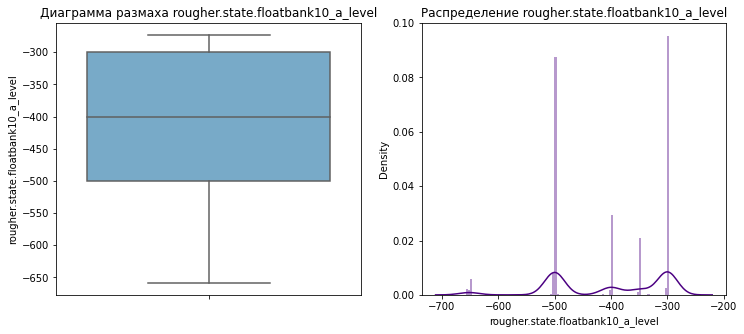

count    5839.00
mean     1270.60
std       285.25
min        -0.82
25%      1199.50
50%      1300.98
75%      1403.26
max      1706.64
Name: rougher.state.floatbank10_b_air, dtype: float64


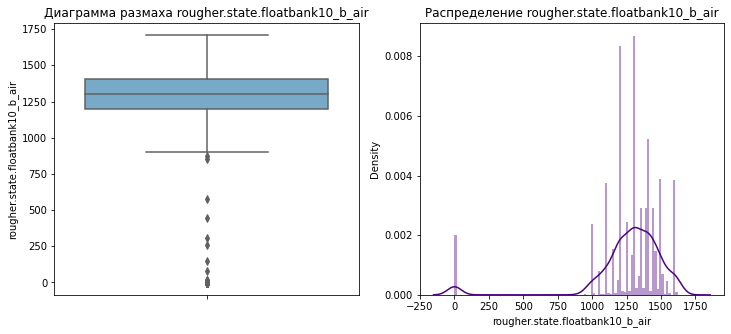

count    5840.00
mean     -482.15
std        55.40
min      -650.35
25%      -500.33
50%      -499.88
75%      -497.61
max      -229.40
Name: rougher.state.floatbank10_b_level, dtype: float64


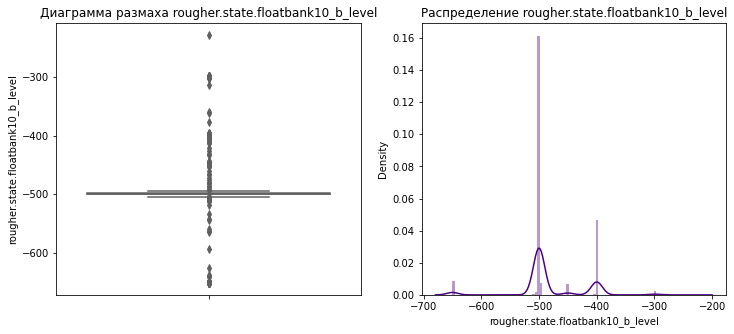

count    5839.00
mean     1253.50
std       290.70
min        -0.28
25%      1195.46
50%      1298.51
75%      1401.91
max      1809.89
Name: rougher.state.floatbank10_c_air, dtype: float64


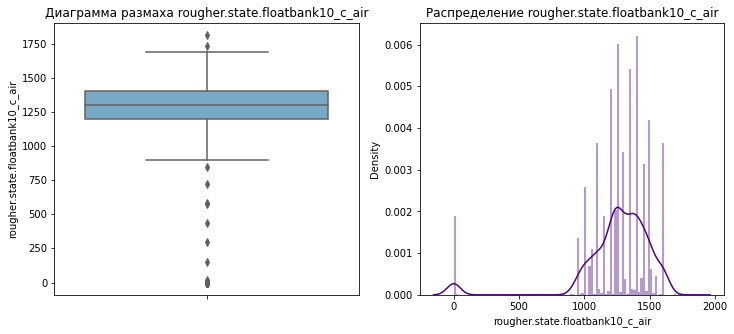

count    5840.00
mean     -480.95
std        53.76
min      -650.00
25%      -500.31
50%      -499.81
75%      -497.34
max      -253.05
Name: rougher.state.floatbank10_c_level, dtype: float64


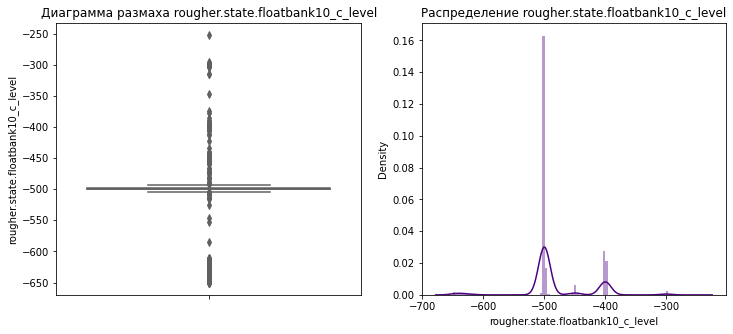

count    5839.00
mean     1169.68
std       285.41
min        -1.05
25%      1004.58
50%      1202.90
75%      1357.77
max      1775.22
Name: rougher.state.floatbank10_d_air, dtype: float64


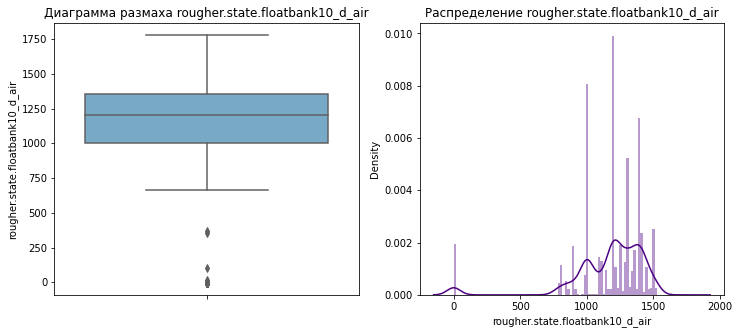

count    5840.00
mean     -482.15
std        54.97
min      -648.39
25%      -500.58
50%      -499.76
75%      -495.58
max       -76.40
Name: rougher.state.floatbank10_d_level, dtype: float64


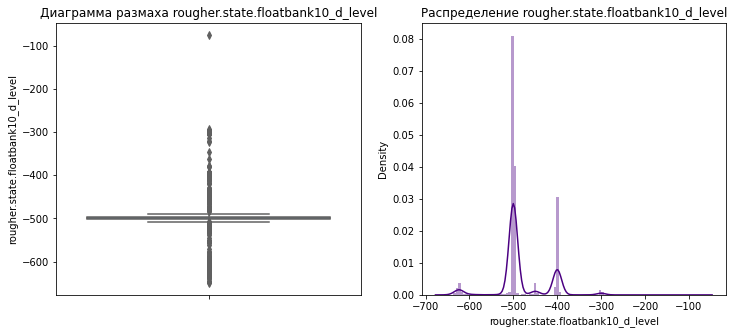

count    5839.00
mean     1018.39
std       231.68
min        -2.08
25%       998.87
50%      1001.67
75%      1100.88
max      1467.18
Name: rougher.state.floatbank10_e_air, dtype: float64


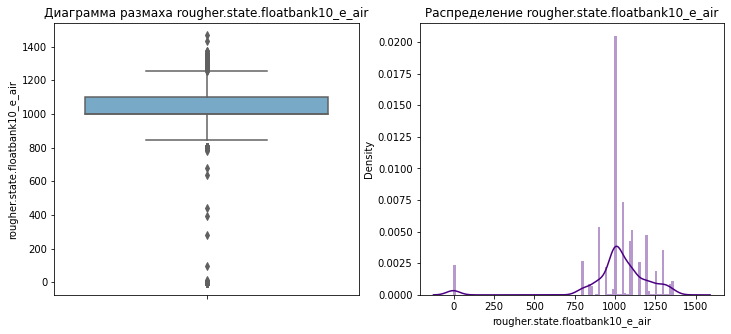

count    5840.00
mean     -476.55
std        67.00
min      -650.15
25%      -500.27
50%      -499.80
75%      -497.82
max      -139.75
Name: rougher.state.floatbank10_e_level, dtype: float64


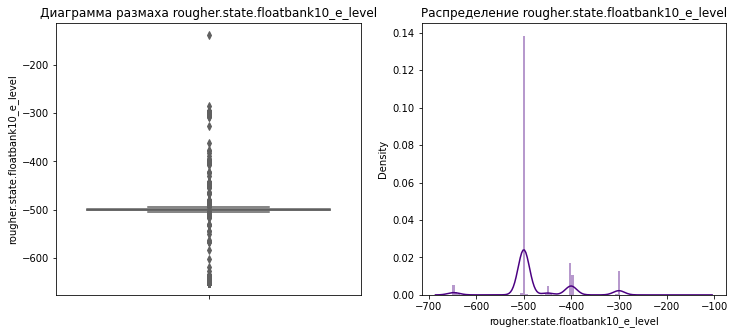

count    5839.00
mean      962.01
std       220.86
min        -2.59
25%       900.52
50%       999.09
75%      1050.04
max      1476.59
Name: rougher.state.floatbank10_f_air, dtype: float64


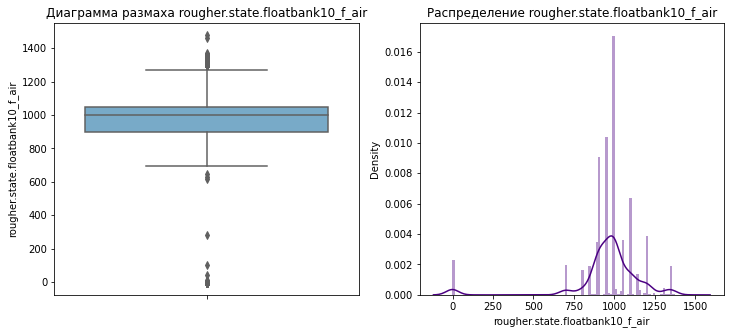

count    5840.00
mean     -477.80
std        68.34
min      -650.03
25%      -500.77
50%      -499.75
75%      -495.58
max      -218.47
Name: rougher.state.floatbank10_f_level, dtype: float64


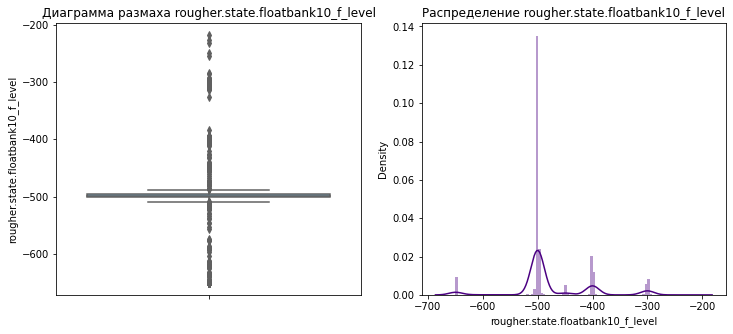

count    5836.00
mean       25.48
std         5.45
min         0.00
25%        24.91
50%        26.86
75%        28.05
max        59.94
Name: secondary_cleaner.state.floatbank2_a_air, dtype: float64


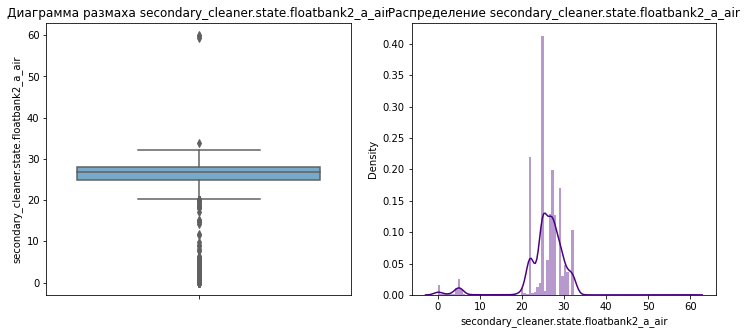

count    5840.00
mean     -513.71
std        62.45
min      -799.61
25%      -500.24
50%      -500.02
75%      -499.80
max      -300.34
Name: secondary_cleaner.state.floatbank2_a_level, dtype: float64


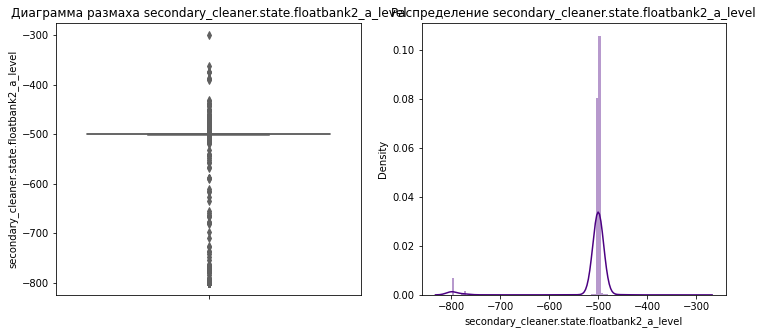

count    5833.00
mean       21.08
std         5.94
min         0.00
25%        19.96
50%        22.91
75%        24.95
max        60.00
Name: secondary_cleaner.state.floatbank2_b_air, dtype: float64


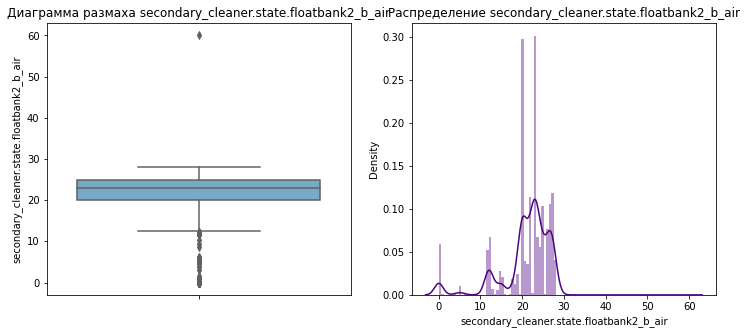

count    5840.00
mean     -512.33
std        63.38
min      -798.47
25%      -500.25
50%      -500.03
75%      -499.84
max      -212.00
Name: secondary_cleaner.state.floatbank2_b_level, dtype: float64


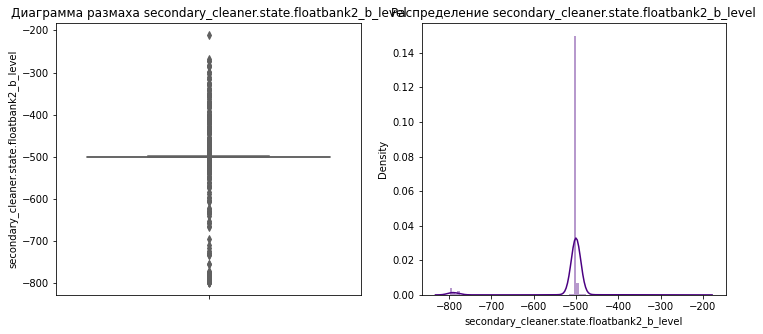

count    5822.00
mean       24.35
std         7.95
min         0.00
25%        22.03
50%        25.00
75%        29.99
max        40.04
Name: secondary_cleaner.state.floatbank3_a_air, dtype: float64


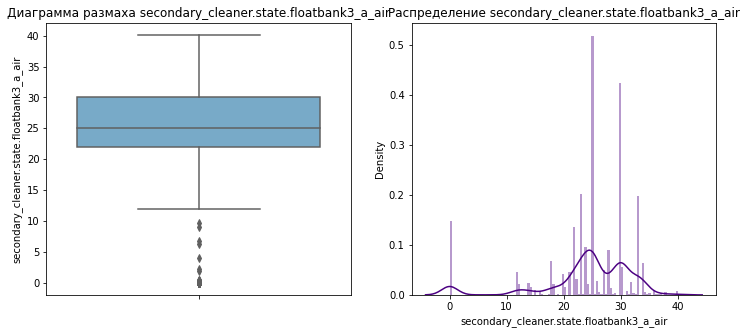

count    5840.00
mean     -519.42
std        73.97
min      -799.76
25%      -500.37
50%      -500.05
75%      -499.79
max      -313.87
Name: secondary_cleaner.state.floatbank3_a_level, dtype: float64


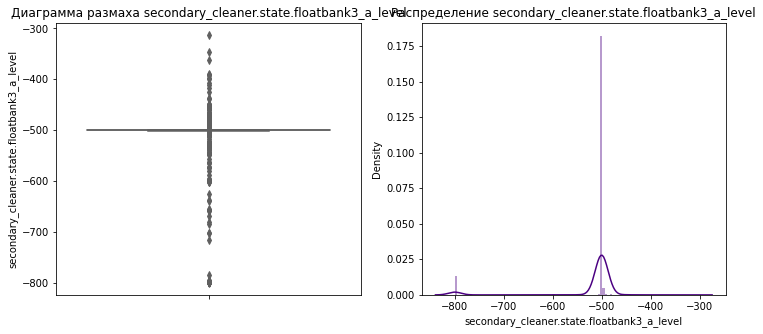

count    5840.00
mean       20.07
std         7.64
min         0.00
25%        15.98
50%        20.03
75%        26.96
max        32.04
Name: secondary_cleaner.state.floatbank3_b_air, dtype: float64


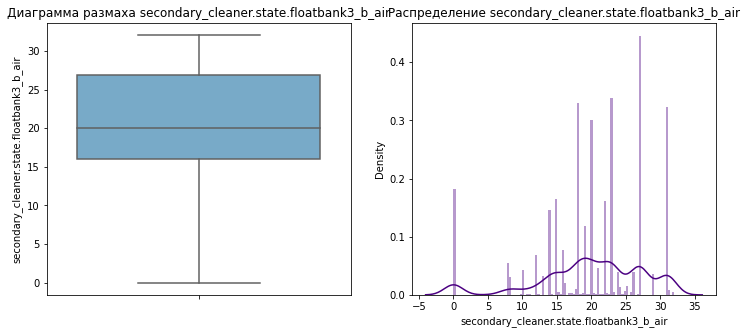

count    5840.00
mean     -515.03
std        60.46
min      -809.33
25%      -500.17
50%      -500.02
75%      -499.90
max      -202.28
Name: secondary_cleaner.state.floatbank3_b_level, dtype: float64


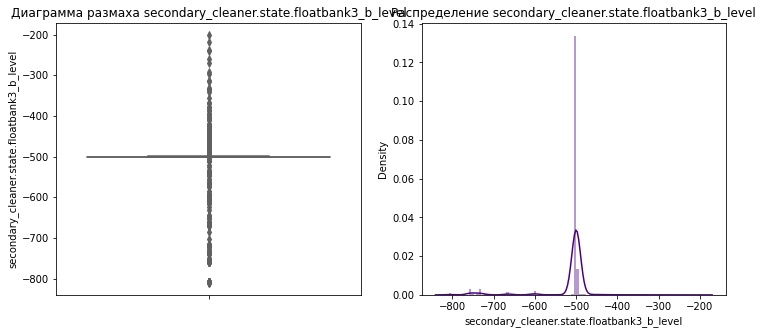

count    5840.00
mean       15.64
std         4.66
min         0.00
25%        12.06
50%        17.00
75%        18.03
max        30.05
Name: secondary_cleaner.state.floatbank4_a_air, dtype: float64


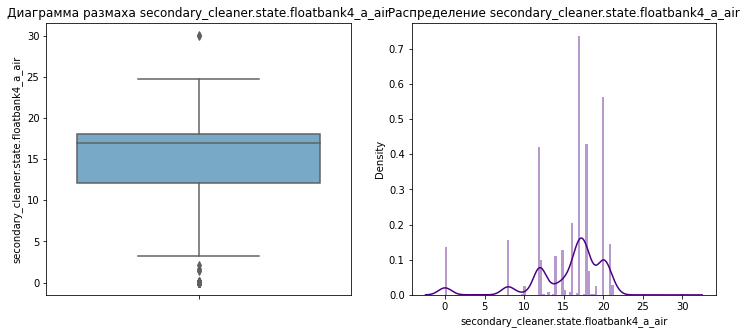

count    5840.00
mean     -516.27
std        62.76
min      -799.80
25%      -501.05
50%      -500.16
75%      -499.44
max      -401.57
Name: secondary_cleaner.state.floatbank4_a_level, dtype: float64


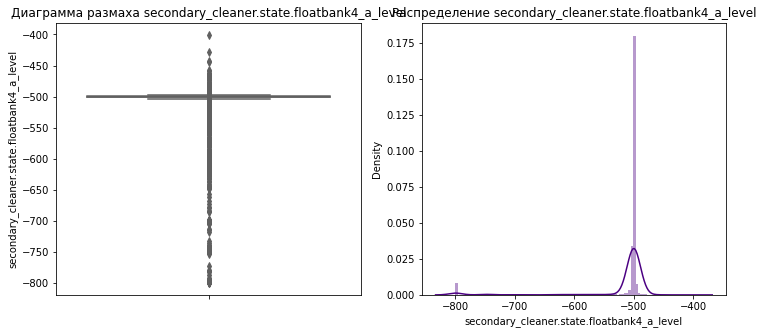

count    5840.00
mean       13.15
std         4.30
min         0.00
25%        11.88
50%        14.95
75%        15.94
max        31.27
Name: secondary_cleaner.state.floatbank4_b_air, dtype: float64


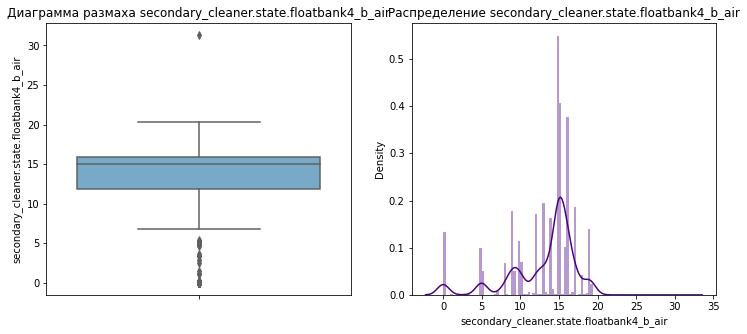

count    5840.00
mean     -476.34
std       105.55
min      -800.84
25%      -500.42
50%      -499.64
75%      -401.52
max        -6.51
Name: secondary_cleaner.state.floatbank4_b_level, dtype: float64


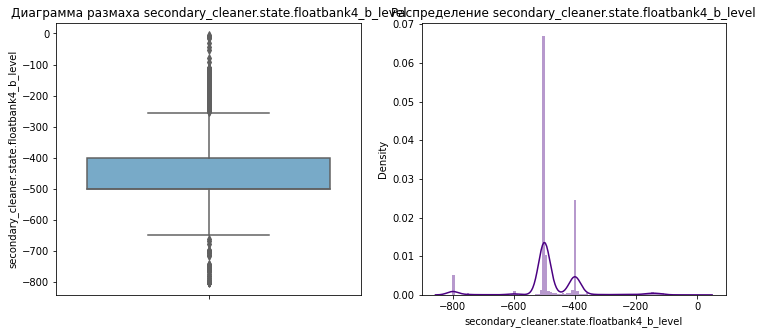

count    5840.00
mean       12.31
std         3.76
min        -0.22
25%        10.12
50%        12.06
75%        15.02
max        25.26
Name: secondary_cleaner.state.floatbank5_a_air, dtype: float64


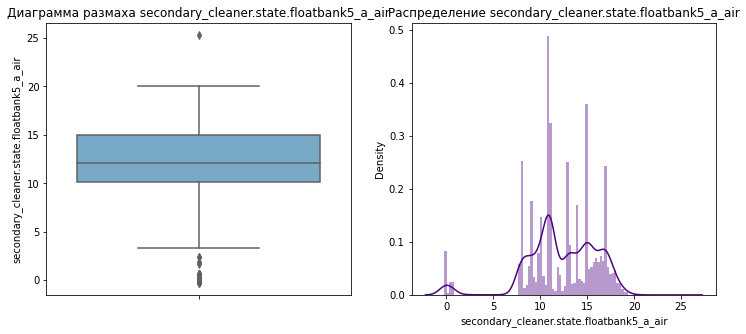

count    5840.00
mean     -512.21
std        58.86
min      -799.66
25%      -500.88
50%      -500.05
75%      -499.30
max      -244.48
Name: secondary_cleaner.state.floatbank5_a_level, dtype: float64


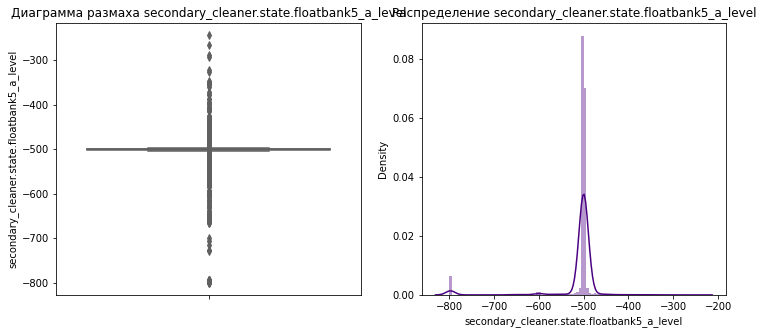

count    5840.00
mean        9.47
std         3.31
min         0.53
25%         7.99
50%         9.98
75%        11.99
max        14.09
Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64


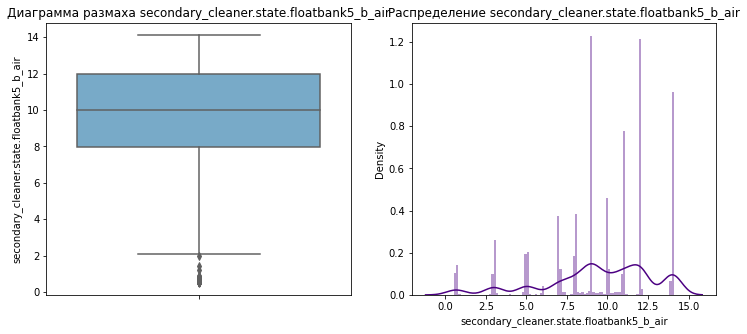

count    5840.00
mean     -505.02
std        68.79
min      -800.22
25%      -500.22
50%      -500.00
75%      -499.72
max      -126.46
Name: secondary_cleaner.state.floatbank5_b_level, dtype: float64


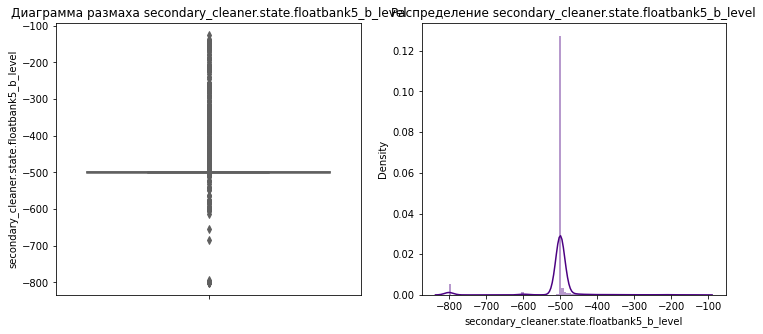

count    5840.00
mean       16.68
std         5.40
min        -0.08
25%        13.01
50%        16.01
75%        21.01
max        26.71
Name: secondary_cleaner.state.floatbank6_a_air, dtype: float64


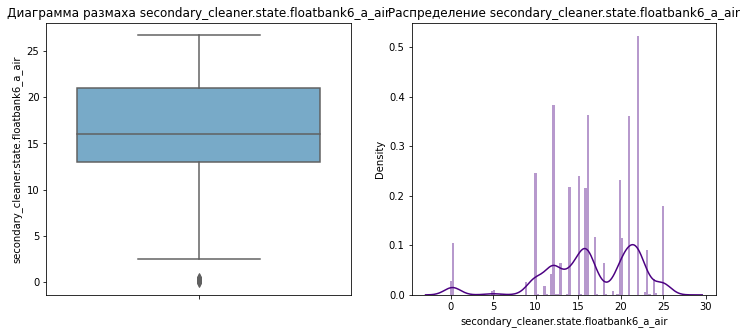

count    5840.00
mean     -512.35
std        69.92
min      -809.86
25%      -500.83
50%      -500.04
75%      -499.40
max       -29.09
Name: secondary_cleaner.state.floatbank6_a_level, dtype: float64


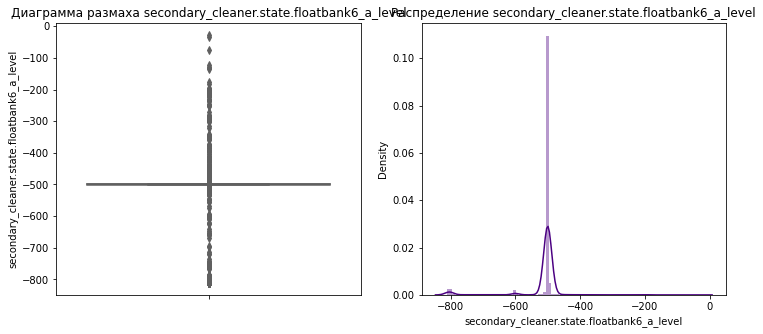

count    5414.00
mean       68.11
std        10.55
min         0.00
25%        65.31
50%        69.72
75%        73.25
max       100.00
Name: final.output.recovery, dtype: float64


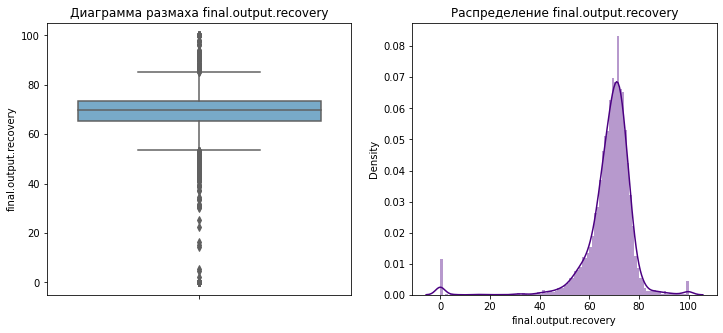

count    5310.00
mean       84.92
std        13.25
min         0.00
25%        84.46
50%        87.38
75%        89.73
max        99.17
Name: rougher.output.recovery, dtype: float64


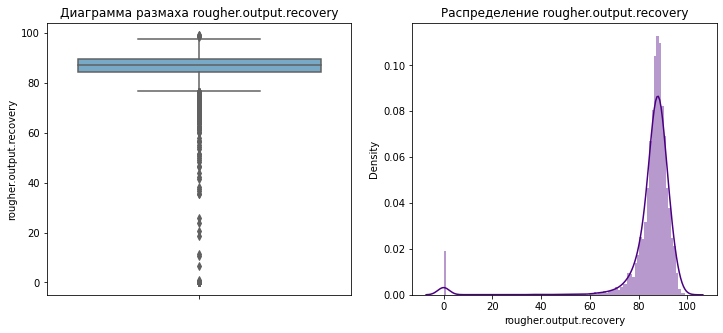

In [24]:
if PLOTS_ARE_NEEDED:
    float_data_analyzer(data_test, data_test.columns, bins=100, round_lim=2)
else:
    print('Параметр plots_are_needed равен', PLOTS_ARE_NEEDED, ', измените значение на True чтобы увидеть графики')

### 1.4.4 Распределения в тестовой выборке после заполнения пропусков

In [25]:
data_test = data_test.fillna(method='ffill')

count    5850.00
mean      162.55
std        59.91
min         0.00
25%       136.57
50%       173.02
75%       205.18
max       274.41
Name: primary_cleaner.input.sulfate, dtype: float64


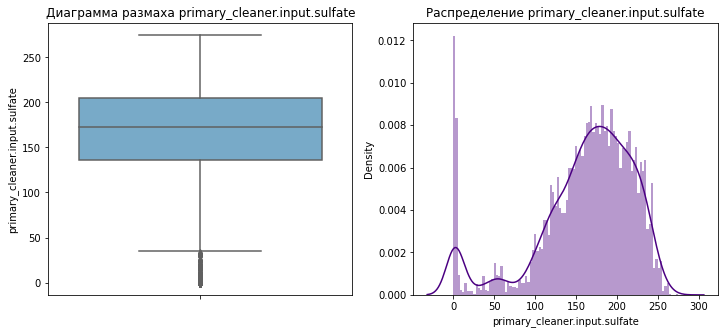

count    5850.00
mean        8.21
std         3.59
min         0.00
25%         6.04
50%         8.00
75%        10.00
max        40.02
Name: primary_cleaner.input.depressant, dtype: float64


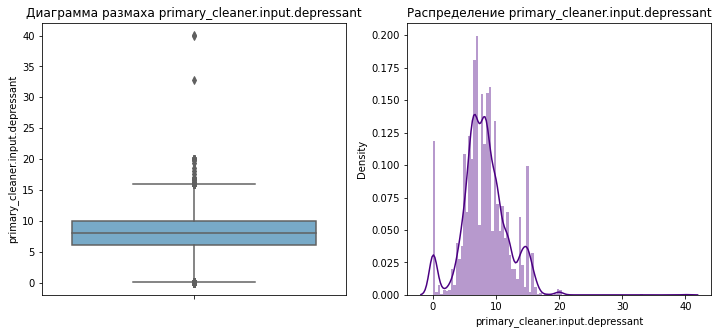

count    5850.00
mean        7.26
std         0.61
min         5.65
25%         6.88
50%         7.25
75%         7.65
max        15.50
Name: primary_cleaner.input.feed_size, dtype: float64


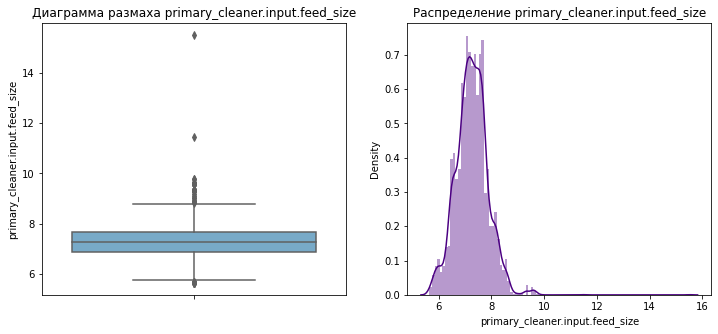

count    5850.00
mean        1.29
std         0.71
min         0.00
25%         0.85
50%         1.15
75%         1.71
max         5.43
Name: primary_cleaner.input.xanthate, dtype: float64


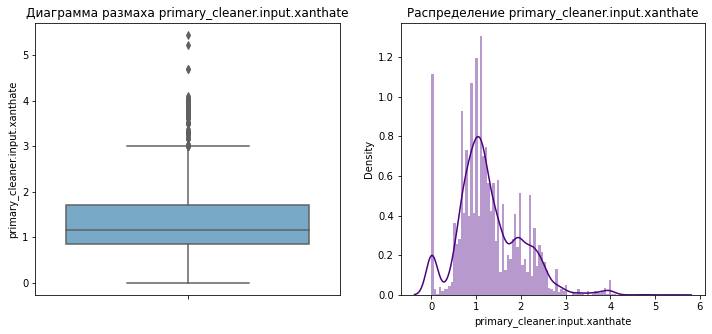

count    5850.00
mean     1481.73
std       311.47
min         0.00
25%      1497.20
50%      1554.79
75%      1601.71
max      2212.43
Name: primary_cleaner.state.floatbank8_a_air, dtype: float64


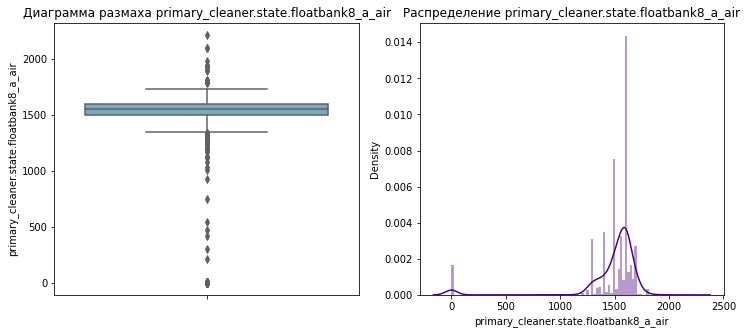

count    5850.00
mean     -509.14
std        61.52
min      -799.77
25%      -500.46
50%      -500.00
75%      -499.58
max       -57.20
Name: primary_cleaner.state.floatbank8_a_level, dtype: float64


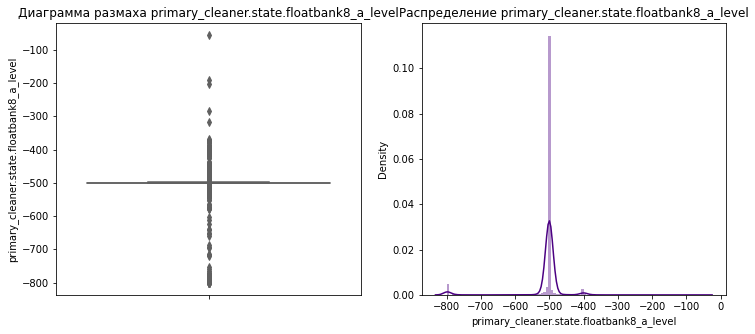

count    5850.00
mean     1486.69
std       314.26
min         0.00
25%      1497.15
50%      1553.42
75%      1601.81
max      1975.15
Name: primary_cleaner.state.floatbank8_b_air, dtype: float64


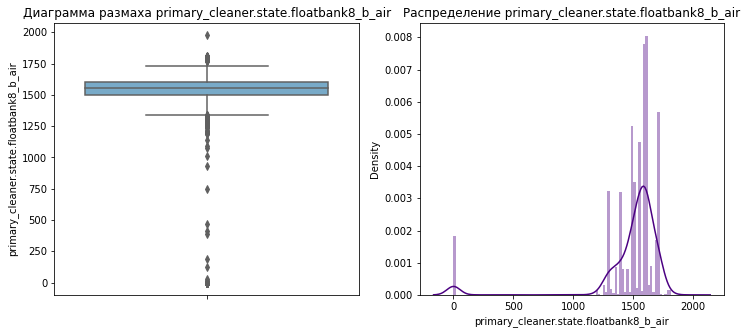

count    5850.00
mean     -511.83
std        67.29
min      -800.03
25%      -500.95
50%      -500.07
75%      -499.32
max      -142.53
Name: primary_cleaner.state.floatbank8_b_level, dtype: float64


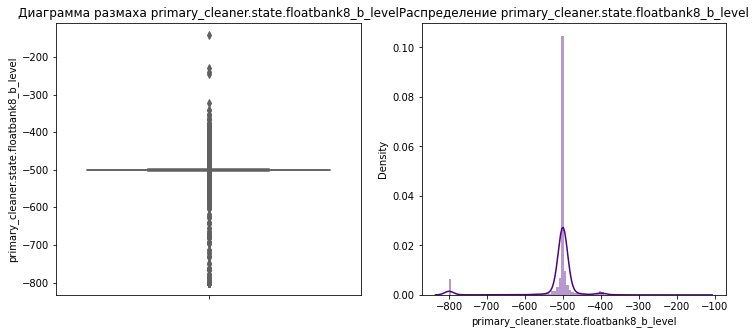

count    5850.00
mean     1468.31
std       311.01
min         0.00
25%      1437.23
50%      1546.42
75%      1600.80
max      1715.05
Name: primary_cleaner.state.floatbank8_c_air, dtype: float64


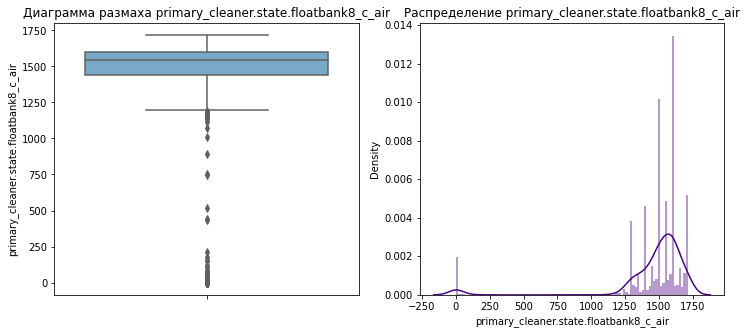

count    5850.00
mean     -509.83
std        62.85
min      -800.00
25%      -501.30
50%      -500.08
75%      -499.01
max      -150.94
Name: primary_cleaner.state.floatbank8_c_level, dtype: float64


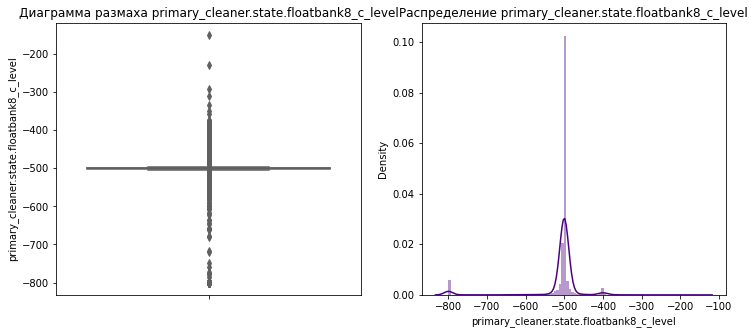

count    5850.00
mean     1486.18
std       314.75
min         0.00
25%      1498.41
50%      1552.15
75%      1600.80
max      1913.26
Name: primary_cleaner.state.floatbank8_d_air, dtype: float64


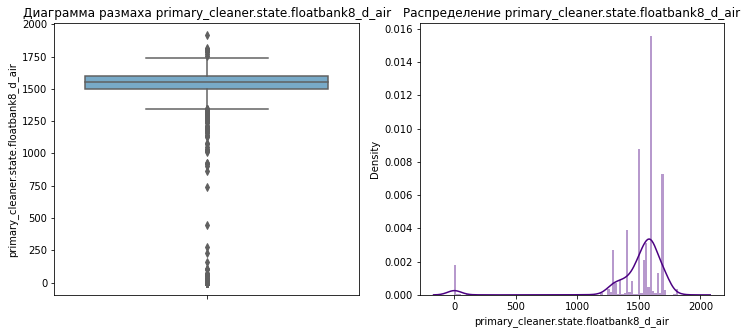

count    5850.00
mean     -510.81
std        65.58
min      -799.84
25%      -500.55
50%      -500.05
75%      -499.61
max       -32.45
Name: primary_cleaner.state.floatbank8_d_level, dtype: float64


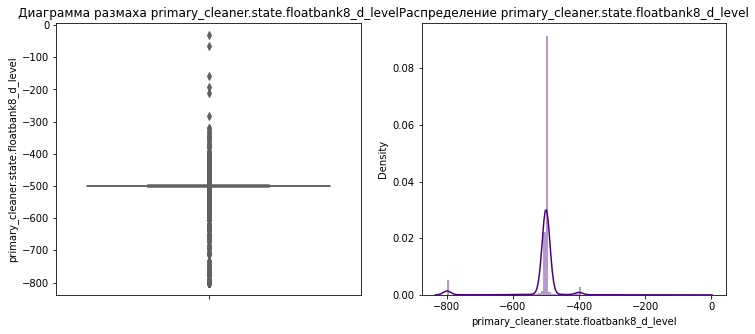

count    5850.00
mean        8.74
std         2.99
min         0.00
25%         7.60
50%         9.63
75%        10.57
max        14.41
Name: rougher.input.feed_ag, dtype: float64


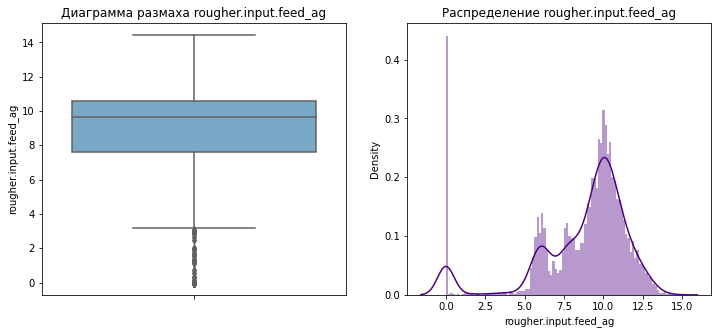

count    5850.00
mean        3.55
std         1.33
min         0.00
25%         3.08
50%         3.68
75%         4.24
max         6.91
Name: rougher.input.feed_pb, dtype: float64


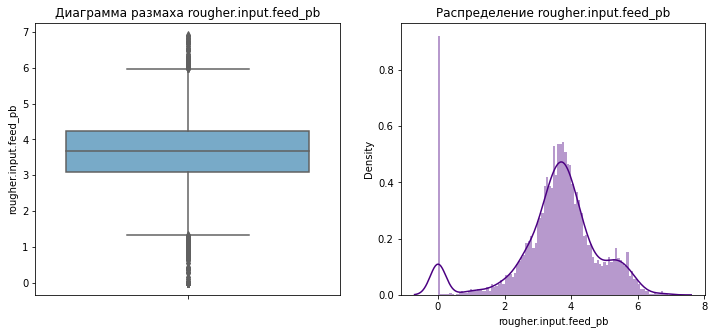

count    5850.00
mean      456.87
std       157.75
min         0.00
25%       399.42
50%       488.89
75%       567.60
max       707.36
Name: rougher.input.feed_rate, dtype: float64


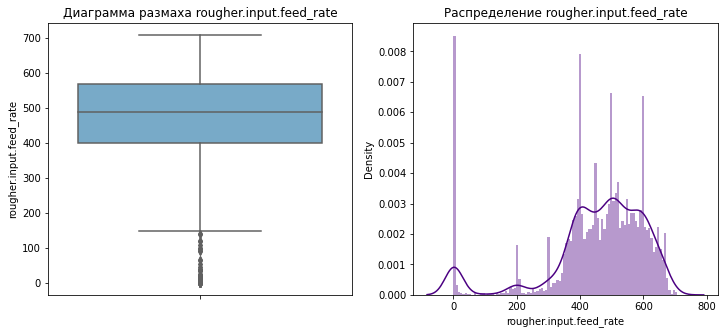

count    5850.00
mean       55.91
std        22.72
min         0.05
25%        43.87
50%        49.98
75%        61.63
max       477.45
Name: rougher.input.feed_size, dtype: float64


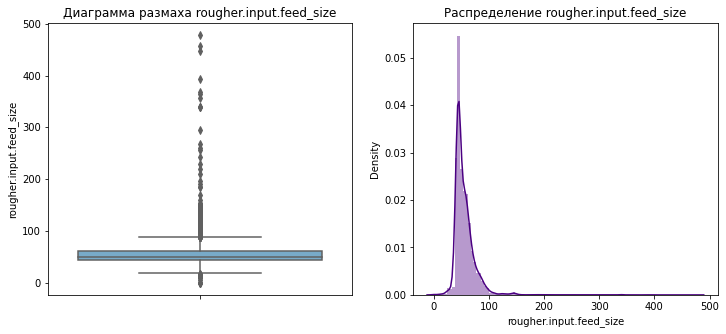

count    5850.00
mean       34.94
std        10.99
min         0.00
25%        33.25
50%        37.30
75%        41.37
max        53.48
Name: rougher.input.feed_sol, dtype: float64


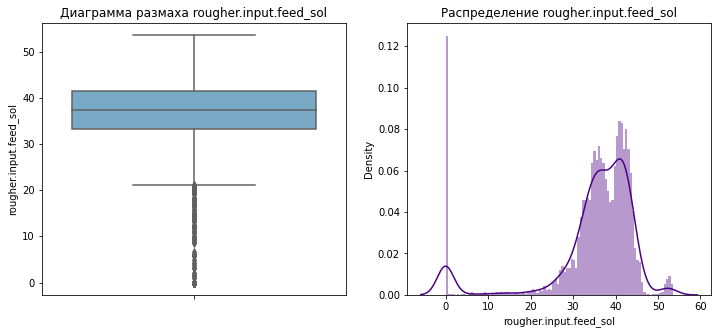

count    5850.00
mean        8.70
std         2.81
min         0.00
25%         7.76
50%         9.45
75%        10.38
max        13.73
Name: rougher.input.feed_au, dtype: float64


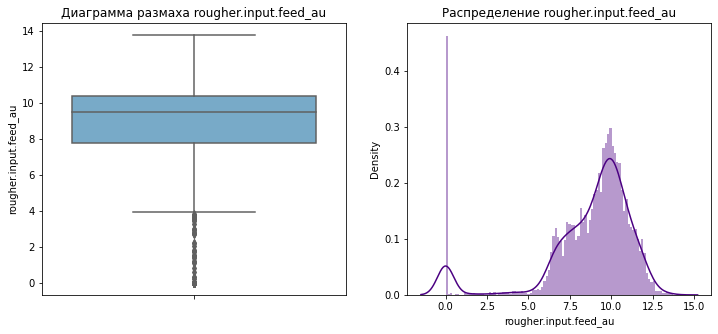

count    5850.00
mean       12.92
std         4.68
min         0.00
25%        10.99
50%        14.00
75%        16.35
max        24.28
Name: rougher.input.floatbank10_sulfate, dtype: float64


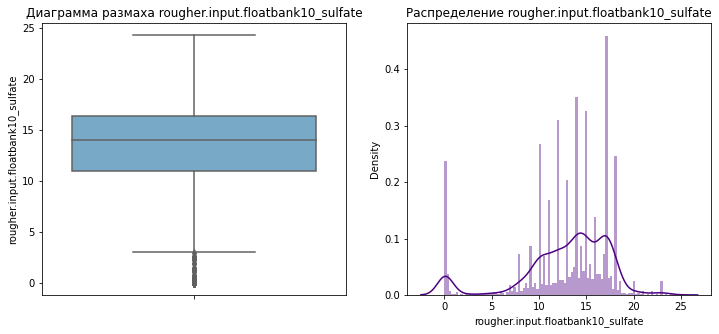

count    5850.00
mean        6.08
std         1.81
min         0.00
25%         5.80
50%         6.40
75%         7.00
max        13.04
Name: rougher.input.floatbank10_xanthate, dtype: float64


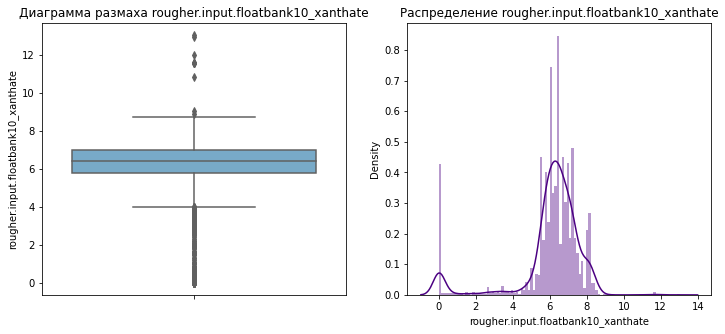

count    5850.00
mean       12.97
std         4.64
min         0.00
25%        11.00
50%        14.00
75%        16.34
max        28.95
Name: rougher.input.floatbank11_sulfate, dtype: float64


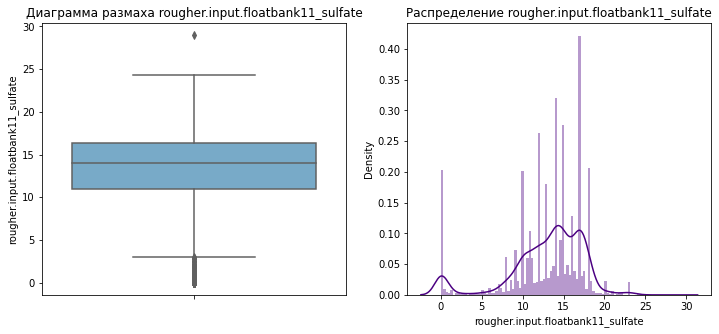

count    5850.00
mean        6.11
std         1.73
min         0.00
25%         5.80
50%         6.40
75%         7.00
max        18.71
Name: rougher.input.floatbank11_xanthate, dtype: float64


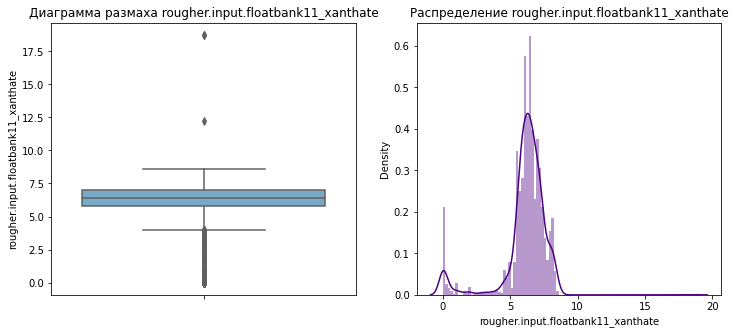

count    5850.00
mean     1015.75
std       227.45
min        -0.12
25%       998.97
50%      1000.33
75%      1005.06
max      1423.27
Name: rougher.state.floatbank10_a_air, dtype: float64


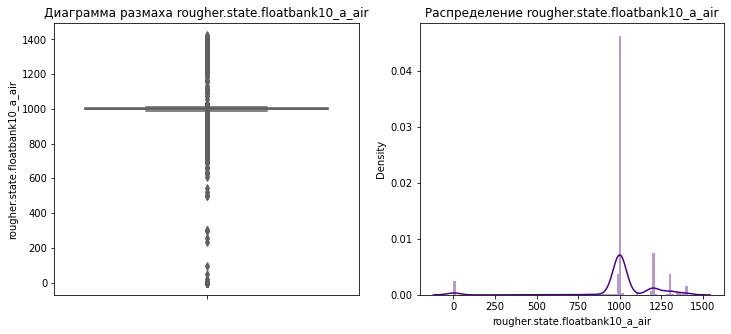

count    5850.00
mean     -405.19
std       101.03
min      -657.95
25%      -499.97
50%      -399.83
75%      -300.08
max      -273.78
Name: rougher.state.floatbank10_a_level, dtype: float64


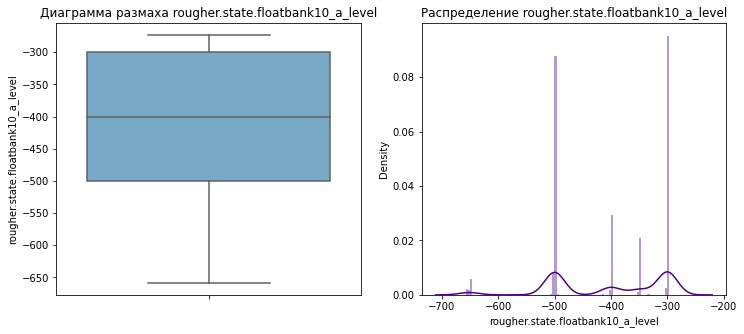

count    5850.00
mean     1270.12
std       286.47
min        -0.82
25%      1199.49
50%      1301.01
75%      1403.18
max      1706.64
Name: rougher.state.floatbank10_b_air, dtype: float64


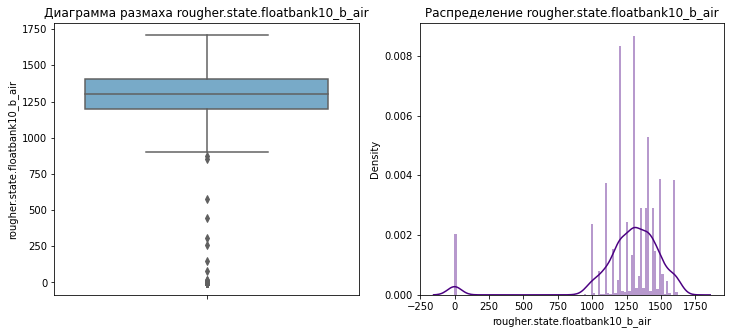

count    5850.00
mean     -482.24
std        55.44
min      -650.35
25%      -500.33
50%      -499.88
75%      -497.64
max      -229.40
Name: rougher.state.floatbank10_b_level, dtype: float64


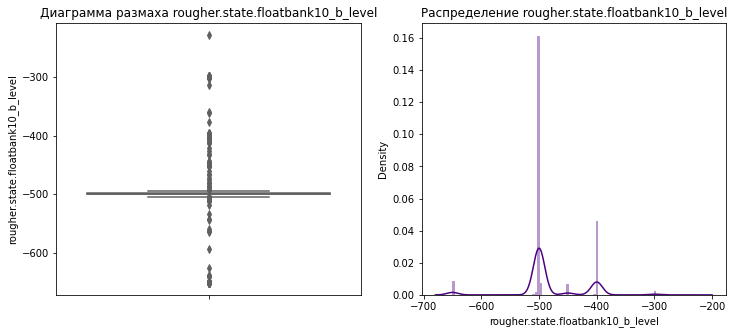

count    5850.00
mean     1253.05
std       291.86
min        -0.28
25%      1195.46
50%      1298.56
75%      1401.85
max      1809.89
Name: rougher.state.floatbank10_c_air, dtype: float64


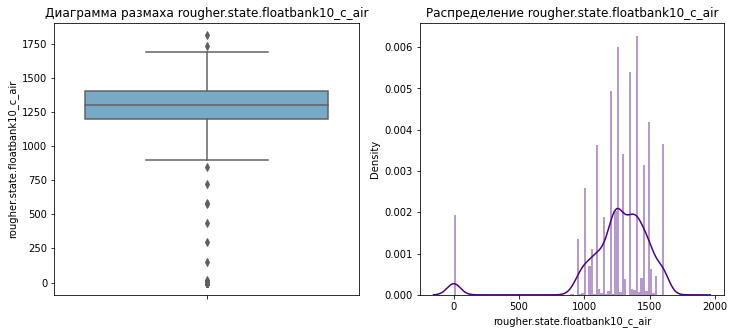

count    5850.00
mean     -481.02
std        53.80
min      -650.00
25%      -500.31
50%      -499.81
75%      -497.42
max      -253.05
Name: rougher.state.floatbank10_c_level, dtype: float64


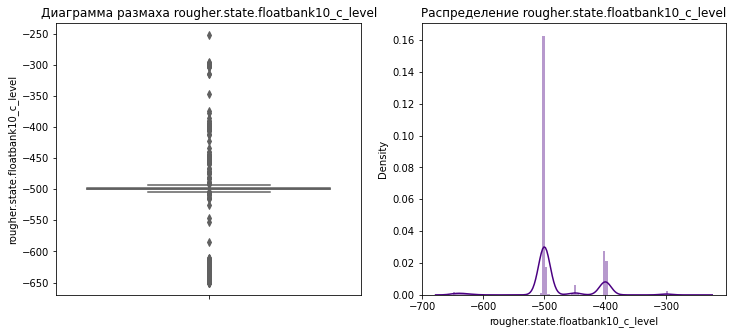

count    5850.00
mean     1169.39
std       286.50
min        -1.05
25%      1004.57
50%      1202.92
75%      1358.27
max      1775.22
Name: rougher.state.floatbank10_d_air, dtype: float64


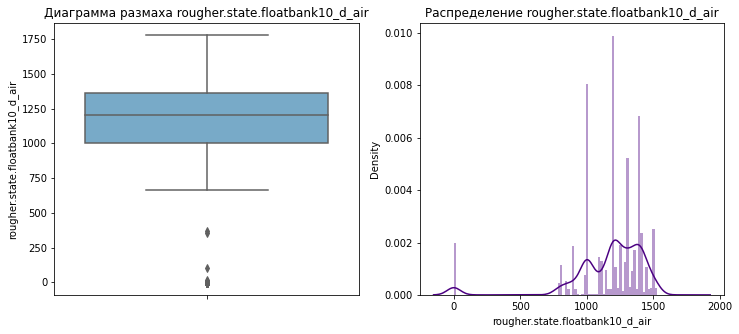

count    5850.00
mean     -482.23
std        54.99
min      -648.39
25%      -500.58
50%      -499.76
75%      -495.63
max       -76.40
Name: rougher.state.floatbank10_d_level, dtype: float64


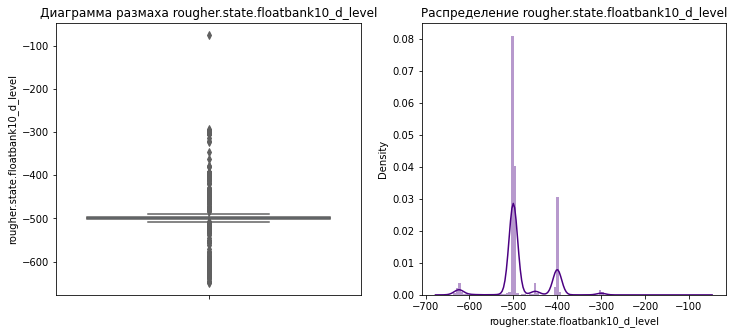

count    5850.00
mean     1017.91
std       232.61
min        -2.08
25%       998.87
50%      1001.69
75%      1100.86
max      1467.18
Name: rougher.state.floatbank10_e_air, dtype: float64


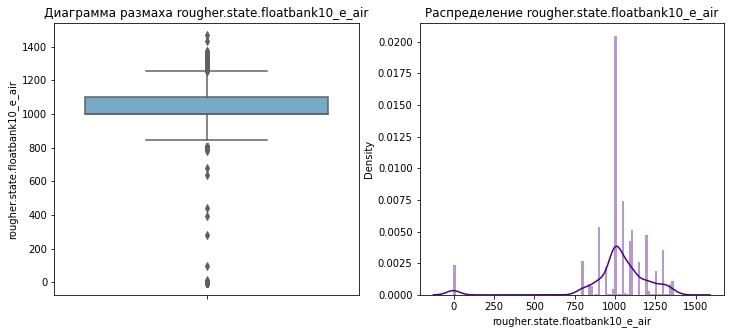

count    5850.00
mean     -476.65
std        67.03
min      -650.15
25%      -500.27
50%      -499.80
75%      -497.86
max      -139.75
Name: rougher.state.floatbank10_e_level, dtype: float64


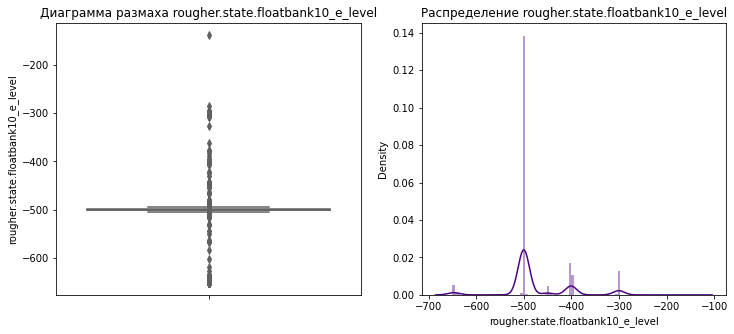

count    5850.00
mean      961.49
std       221.73
min        -2.59
25%       900.52
50%       999.07
75%      1050.02
max      1476.59
Name: rougher.state.floatbank10_f_air, dtype: float64


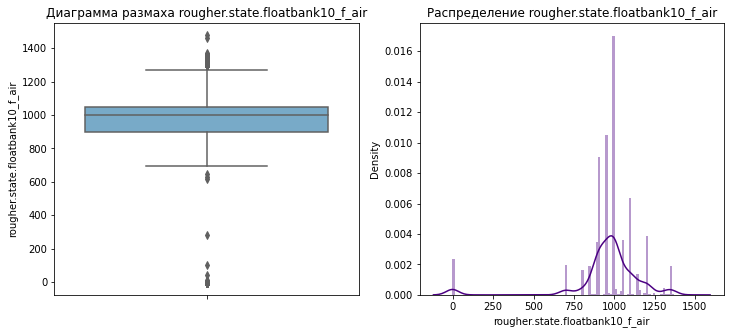

count    5850.00
mean     -477.89
std        68.36
min      -650.03
25%      -500.77
50%      -499.76
75%      -495.75
max      -218.47
Name: rougher.state.floatbank10_f_level, dtype: float64


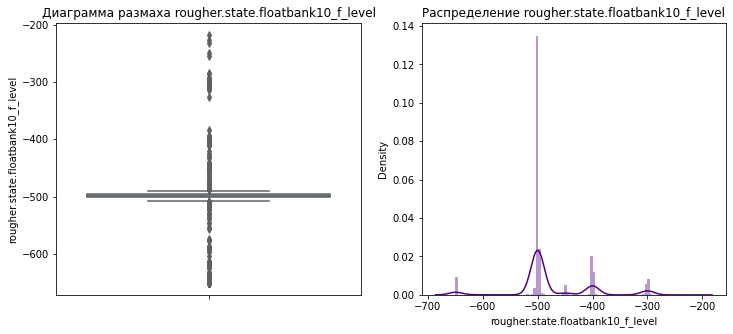

count    5850.00
mean       25.47
std         5.47
min         0.00
25%        24.91
50%        26.86
75%        28.05
max        59.94
Name: secondary_cleaner.state.floatbank2_a_air, dtype: float64


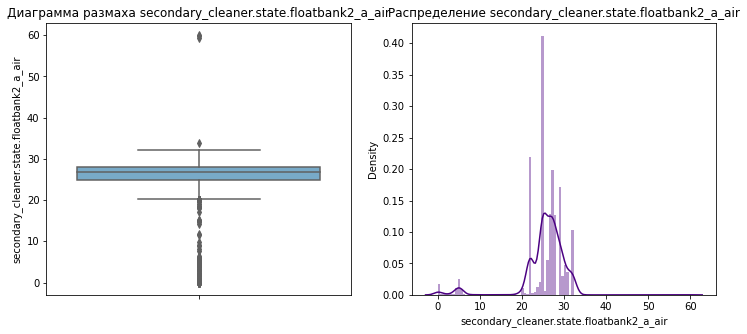

count    5850.00
mean     -513.79
std        62.62
min      -799.61
25%      -500.24
50%      -500.02
75%      -499.80
max      -300.34
Name: secondary_cleaner.state.floatbank2_a_level, dtype: float64


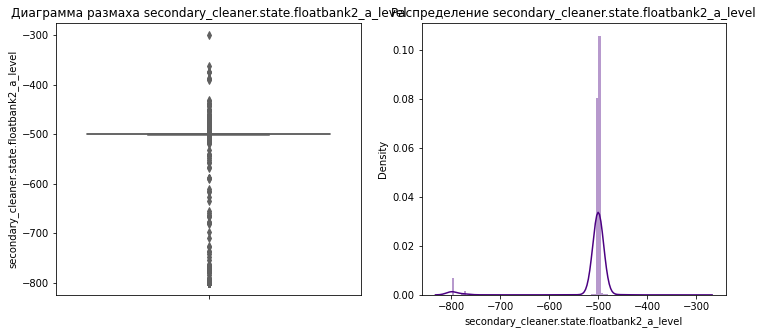

count    5850.00
mean       21.08
std         6.02
min         0.00
25%        19.96
50%        22.91
75%        24.95
max        60.00
Name: secondary_cleaner.state.floatbank2_b_air, dtype: float64


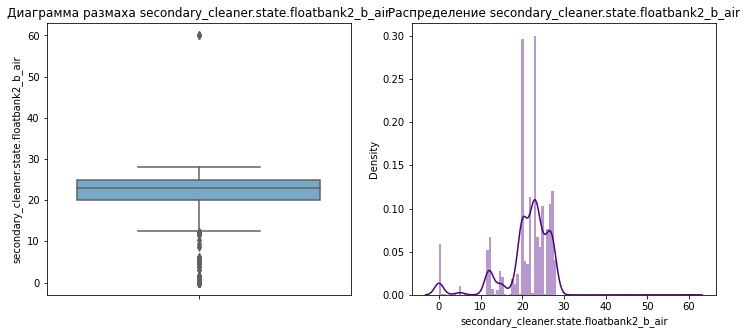

count    5850.00
mean     -512.40
std        63.53
min      -798.47
25%      -500.25
50%      -500.03
75%      -499.84
max      -212.00
Name: secondary_cleaner.state.floatbank2_b_level, dtype: float64


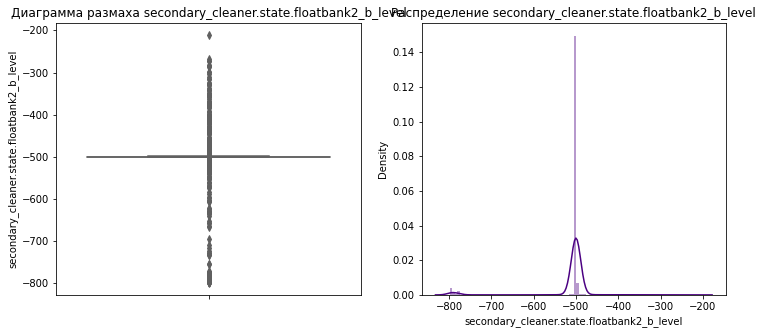

count    5850.00
mean       24.28
std         8.06
min         0.00
25%        22.03
50%        25.00
75%        29.99
max        40.04
Name: secondary_cleaner.state.floatbank3_a_air, dtype: float64


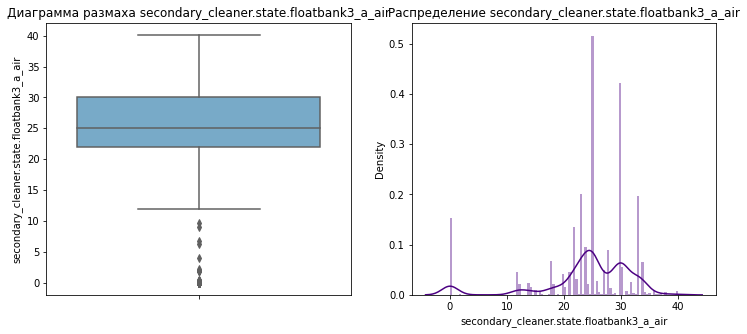

count    5850.00
mean     -519.49
std        74.09
min      -799.76
25%      -500.37
50%      -500.05
75%      -499.79
max      -313.87
Name: secondary_cleaner.state.floatbank3_a_level, dtype: float64


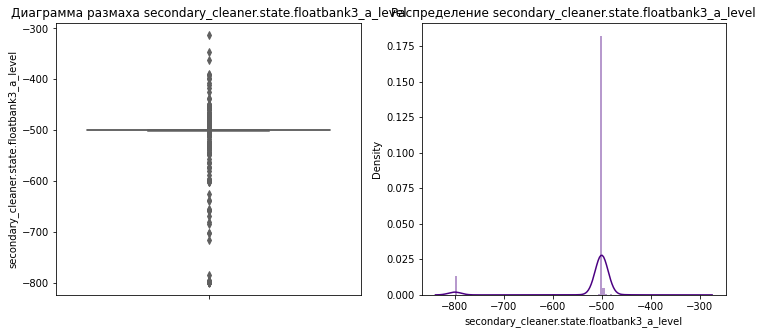

count    5850.00
mean       20.08
std         7.66
min         0.00
25%        15.98
50%        20.03
75%        26.96
max        32.04
Name: secondary_cleaner.state.floatbank3_b_air, dtype: float64


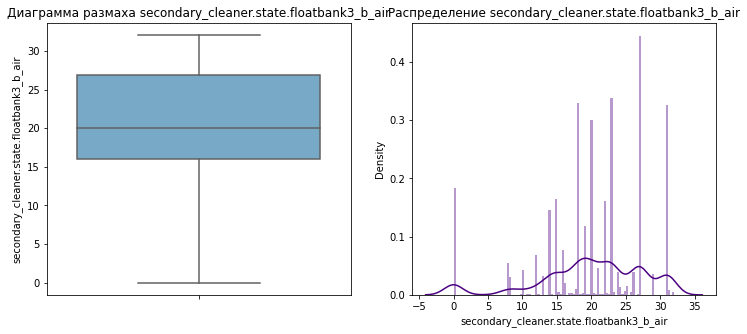

count    5850.00
mean     -515.07
std        60.51
min      -809.33
25%      -500.17
50%      -500.02
75%      -499.90
max      -202.28
Name: secondary_cleaner.state.floatbank3_b_level, dtype: float64


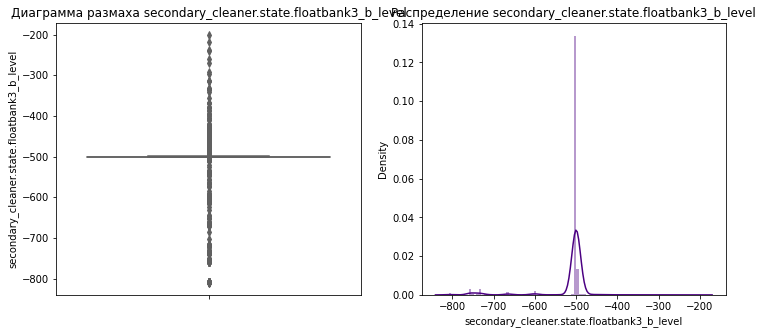

count    5850.00
mean       15.63
std         4.67
min         0.00
25%        12.06
50%        17.00
75%        18.03
max        30.05
Name: secondary_cleaner.state.floatbank4_a_air, dtype: float64


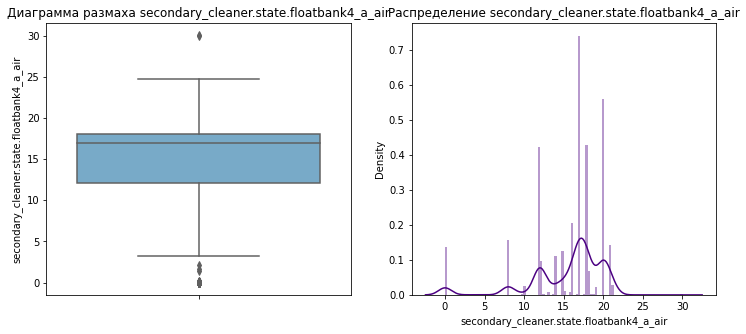

count    5850.00
mean     -516.33
std        62.93
min      -799.80
25%      -501.05
50%      -500.16
75%      -499.43
max      -401.57
Name: secondary_cleaner.state.floatbank4_a_level, dtype: float64


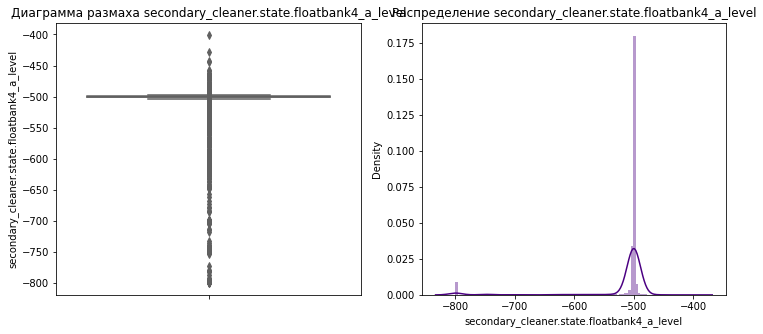

count    5850.00
mean       13.14
std         4.31
min         0.00
25%        11.88
50%        14.95
75%        15.94
max        31.27
Name: secondary_cleaner.state.floatbank4_b_air, dtype: float64


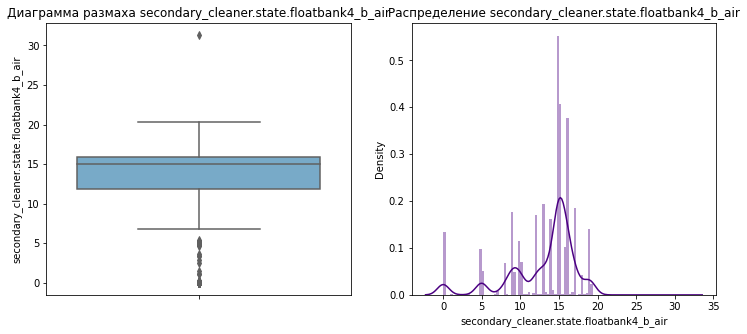

count    5850.00
mean     -476.47
std       105.63
min      -800.84
25%      -500.42
50%      -499.64
75%      -401.56
max        -6.51
Name: secondary_cleaner.state.floatbank4_b_level, dtype: float64


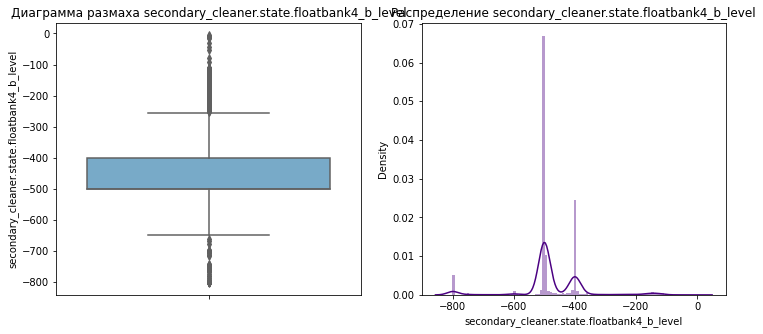

count    5850.00
mean       12.31
std         3.77
min        -0.22
25%        10.12
50%        12.07
75%        15.02
max        25.26
Name: secondary_cleaner.state.floatbank5_a_air, dtype: float64


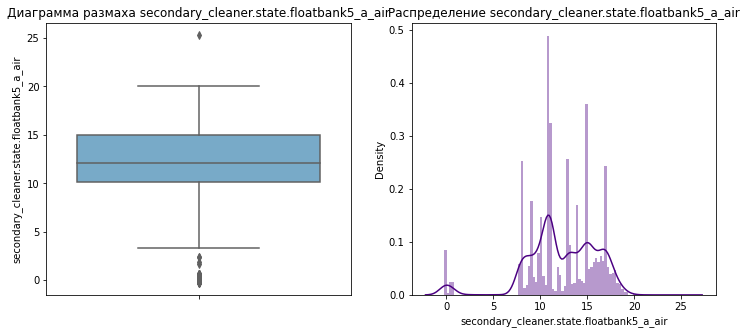

count    5850.00
mean     -512.29
std        59.05
min      -799.66
25%      -500.88
50%      -500.05
75%      -499.29
max      -244.48
Name: secondary_cleaner.state.floatbank5_a_level, dtype: float64


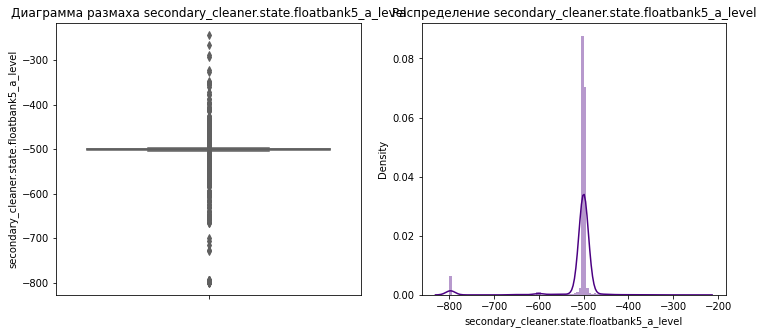

count    5850.00
mean        9.47
std         3.32
min         0.53
25%         7.99
50%         9.98
75%        11.99
max        14.09
Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64


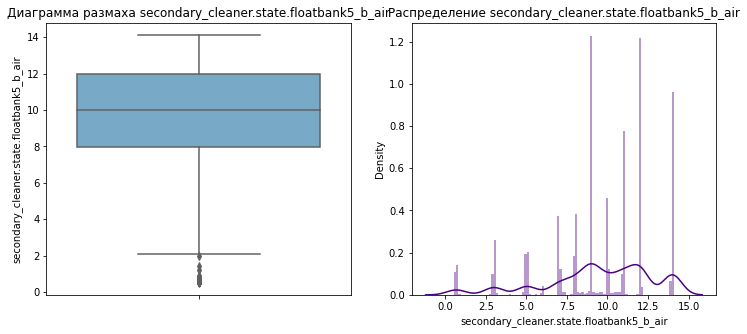

count    5850.00
mean     -505.11
std        68.94
min      -800.22
25%      -500.22
50%      -500.00
75%      -499.72
max      -126.46
Name: secondary_cleaner.state.floatbank5_b_level, dtype: float64


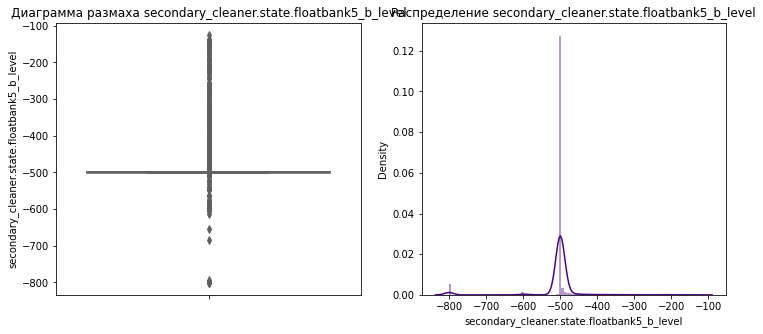

count    5850.00
mean       16.68
std         5.41
min        -0.08
25%        13.01
50%        16.01
75%        21.01
max        26.71
Name: secondary_cleaner.state.floatbank6_a_air, dtype: float64


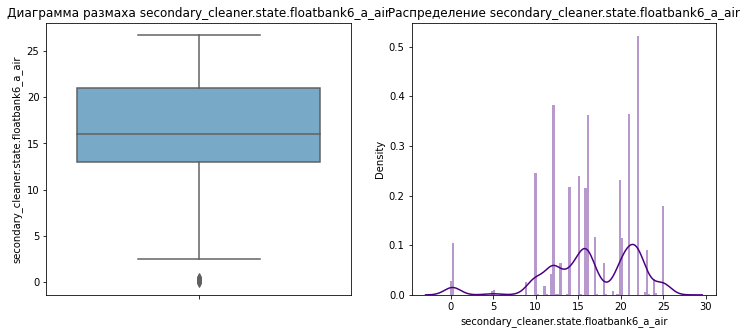

count    5850.00
mean     -512.42
std        70.04
min      -809.86
25%      -500.83
50%      -500.04
75%      -499.39
max       -29.09
Name: secondary_cleaner.state.floatbank6_a_level, dtype: float64


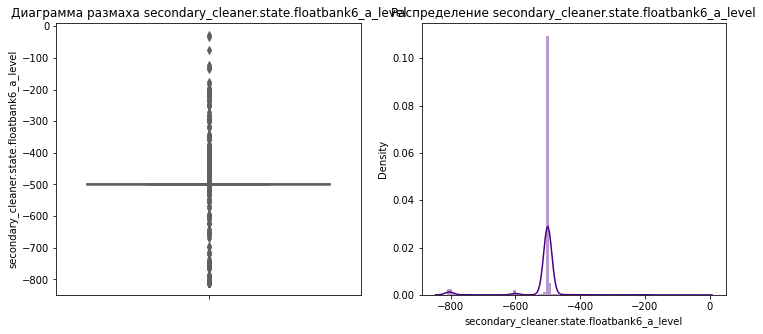

count    5850.00
mean       66.67
std        12.12
min         0.00
25%        64.05
50%        69.28
75%        72.97
max       100.00
Name: final.output.recovery, dtype: float64


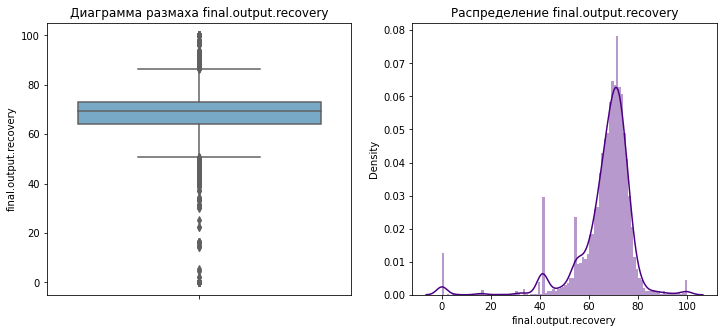

count    5850.00
mean       84.35
std        13.90
min         0.00
25%        84.04
50%        87.31
75%        89.67
max        99.17
Name: rougher.output.recovery, dtype: float64


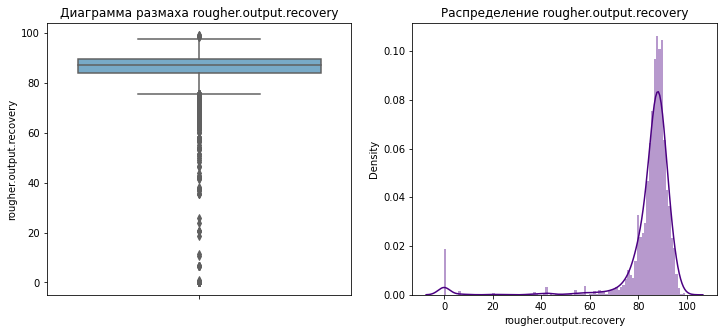

In [26]:
if PLOTS_ARE_NEEDED:
    float_data_analyzer(data_test, data_test.columns, bins=100, round_lim=2)
else:
    print('Параметр plots_are_needed равен', PLOTS_ARE_NEEDED, ', измените значение на True чтобы увидеть графики')

### 1.4.5 Заполнение пропусков в полной выборке

In [27]:
data_full = data_full.fillna(method='ffill')

### 1.4.6 Вывод по заполнению пропусков

In [28]:
# Train after filling.
nan_counts(data_train)

Empty DataFrame
Columns: [nan_counts, part_%]
Index: []

In [29]:
# Test after filling.
nan_counts(data_test)

Empty DataFrame
Columns: [nan_counts, part_%]
Index: []

Как видно из графиков, в целом распределения не изменяются; пропусков в обучающей и тестовой выборке больше нет.

Отдельно стоит отметить, что в некоторых столбцах возрастает доля нулевых значений, например в 'primary_cleaner.input.sulfate' и 'primary_cleaner.input.xanthate'. Данный факт видится аномалией, которая нуждается в обработке.

### 1.4.7 Удаление аномалий

#### Подготовка к удалению

In [30]:
# Prepare for drop:

# Reset index.
data_train.reset_index(level=0, inplace=True)
data_test.reset_index(level=0, inplace=True)
data_full.reset_index(level=0, inplace=True)

# Choose features to clean.
anomal_features_list = sorted(list(set(data_test.columns).difference(set(['rougher.input.feed.size',
                                                              'rougher.state.floatbank10_a_level',
                                                              'rougher.state.floatbank10_b_level',
                                                              'rougher.state.floatbank10_c_level',
                                                              'rougher.state.floatbank10_d_level',
                                                              'rougher.state.floatbank10_e_level',
                                                              'rougher.state.floatbank10_f_level',
                                                              'primary_cleaner.state.floatbank8_a_level',
                                                              'primary_cleaner.state.floatbank8_b_level',
                                                              'primary_cleaner.state.floatbank8_c_level',
                                                              'primary_cleaner.state.floatbank8_d_level',
                                                              'secondary_cleaner.state.floatbank2_a_level',
                                                              'secondary_cleaner.state.floatbank2_b_level',
                                                              'secondary_cleaner.state.floatbank3_a_level',
                                                              'secondary_cleaner.state.floatbank3_b_level',
                                                              'secondary_cleaner.state.floatbank4_a_level',
                                                              'secondary_cleaner.state.floatbank4_b_level',
                                                              'secondary_cleaner.state.floatbank5_a_level',
                                                              'secondary_cleaner.state.floatbank5_b_level',
                                                              'secondary_cleaner.state.floatbank6_a_level',
                                                              'secondary_cleaner.state.floatbank4_b_air',
                                                              'secondary_cleaner.state.floatbank5_b_air',
                                                              'date'
                                                              ]))))
anomal_features_list

['final.output.recovery',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_d_air',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.output.recovery',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_f_air',
 'secondary_cleaner.state.floatbank2_a_air',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary

#### train

In [31]:
def drop_anomal_val(data, data_name, value, features_list):
    '''This function drop anomal values from inputed data.
        Input:
        data — intrested data;
        data_name — name of dataset, needed for output print;
        value — threshold for anomal cutting,
        features_list — list with names of columns you need to clean.
        
        Output:
        cleaned data.'''
        
    print(f'Размер {data_name} выборки:{data.shape[0]}')
    for feature in features_list:
        index_to_delete = data[data[feature] < value].index
        data.drop(index_to_delete, axis=0, inplace=True)
    print('*Обработка*')
    print(f'Размер {data_name} выборки:{data.shape[0]}')
    
    return data


In [32]:
# Drop train.
data_train = drop_anomal_val(data_train, 'тренировочной', 0.1, anomal_features_list)
data_train.set_index('date', inplace=True)

Размер тренировочной выборки:16844
*Обработка*
Размер тренировочной выборки:13736


In [33]:
if PLOTS_ARE_NEEDED:
    float_data_analyzer(data_train, data_train.columns, bins=100, round_lim=2)
else:
    print('Параметр plots_are_needed равен', PLOTS_ARE_NEEDED, ', измените значение на True чтобы увидеть графики')

Output hidden; open in https://colab.research.google.com to view.

#### test

In [34]:
# Drop test.
data_test = drop_anomal_val(data_test, 'тестовой', 0.1, anomal_features_list)
data_test.set_index('date', inplace=True)

Размер тестовой выборки:5850
*Обработка*
Размер тестовой выборки:5048


count    5048.00
mean      175.92
std        41.87
min        15.01
25%       147.62
50%       178.18
75%       209.22
max       265.98
Name: primary_cleaner.input.sulfate, dtype: float64


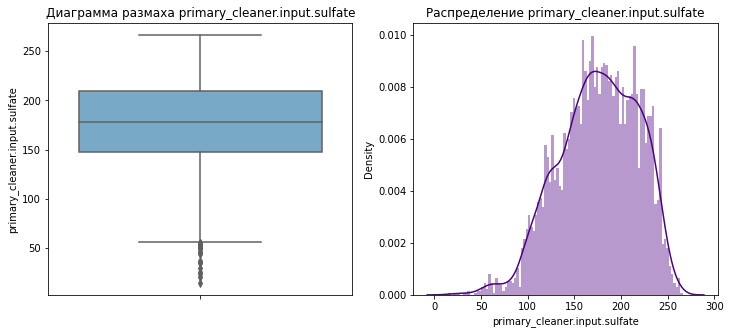

count    5048.00
mean        8.76
std         3.04
min         0.22
25%         6.50
50%         8.20
75%        10.04
max        20.05
Name: primary_cleaner.input.depressant, dtype: float64


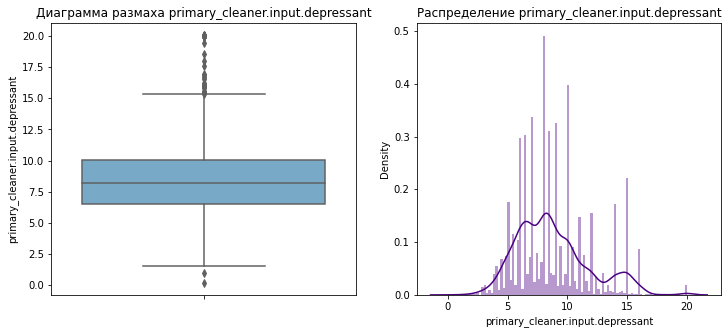

count    5048.00
mean        7.27
std         0.59
min         5.65
25%         6.90
50%         7.25
75%         7.60
max         9.77
Name: primary_cleaner.input.feed_size, dtype: float64


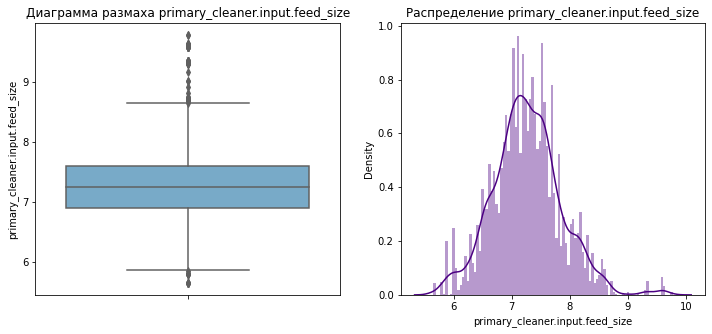

count    5048.00
mean        1.39
std         0.64
min         0.25
25%         0.91
50%         1.20
75%         1.80
max         4.10
Name: primary_cleaner.input.xanthate, dtype: float64


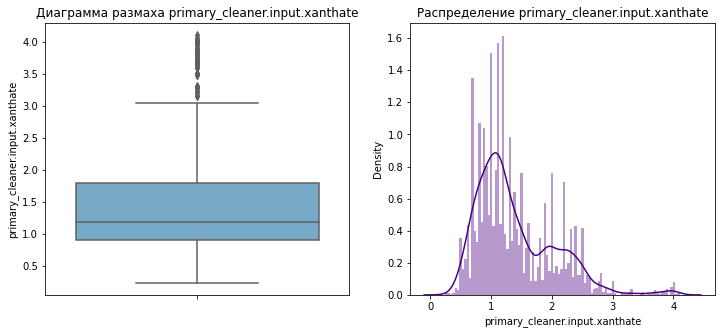

count    5048.00
mean     1542.38
std       109.14
min      1011.53
25%      1499.12
50%      1584.94
75%      1602.32
max      1810.77
Name: primary_cleaner.state.floatbank8_a_air, dtype: float64


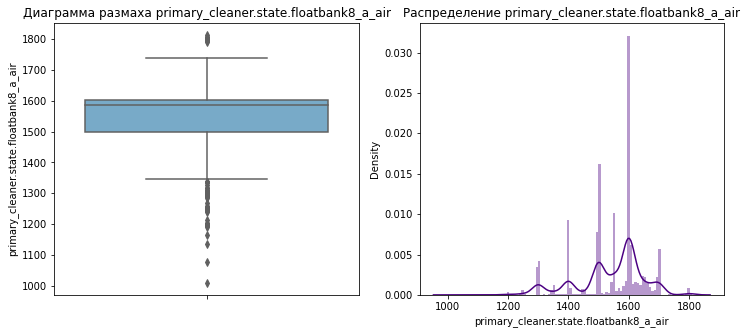

count    5048.00
mean     -497.05
std        19.75
min      -653.48
25%      -500.36
50%      -499.97
75%      -499.56
max       -57.20
Name: primary_cleaner.state.floatbank8_a_level, dtype: float64


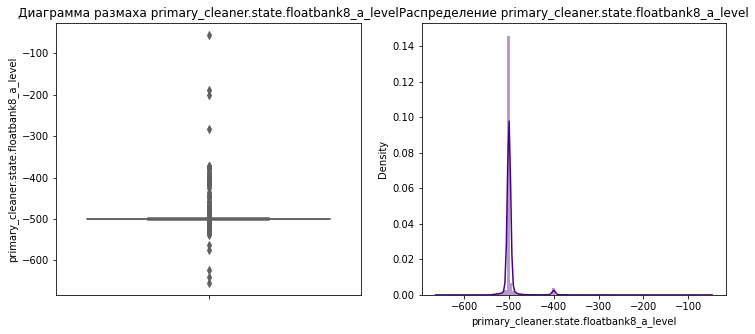

count    5048.00
mean     1548.61
std       116.14
min      1012.93
25%      1499.12
50%      1595.71
75%      1602.50
max      1813.08
Name: primary_cleaner.state.floatbank8_b_air, dtype: float64


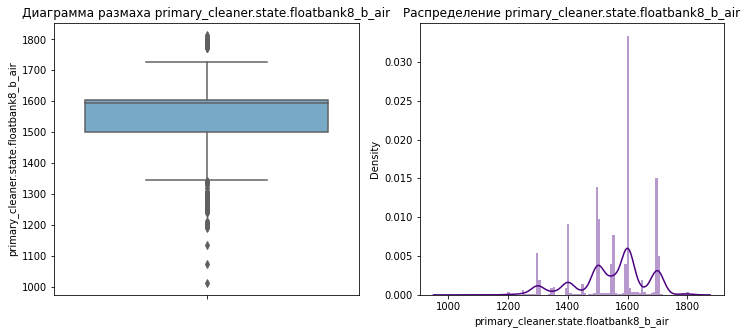

count    5048.00
mean     -498.72
std        28.53
min      -799.75
25%      -500.71
50%      -500.03
75%      -499.24
max      -142.53
Name: primary_cleaner.state.floatbank8_b_level, dtype: float64


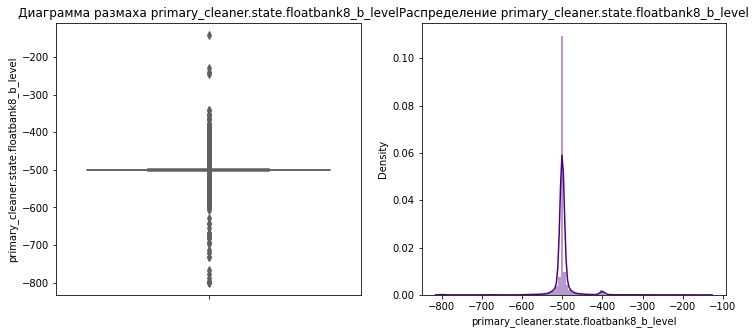

count    5048.00
mean     1530.38
std       115.25
min      1011.87
25%      1478.17
50%      1549.37
75%      1601.39
max      1715.05
Name: primary_cleaner.state.floatbank8_c_air, dtype: float64


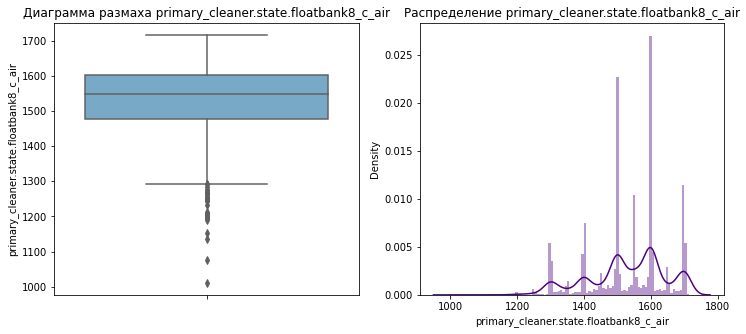

count    5048.00
mean     -497.72
std        21.51
min      -786.26
25%      -501.04
50%      -500.01
75%      -498.93
max      -150.94
Name: primary_cleaner.state.floatbank8_c_level, dtype: float64


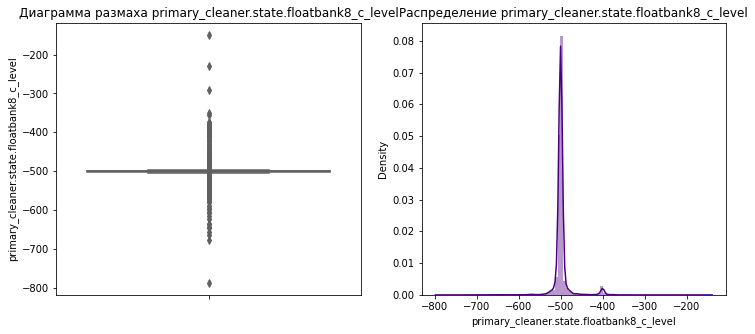

count    5048.00
mean     1549.21
std       116.81
min       860.64
25%      1499.61
50%      1594.87
75%      1601.20
max      1913.26
Name: primary_cleaner.state.floatbank8_d_air, dtype: float64


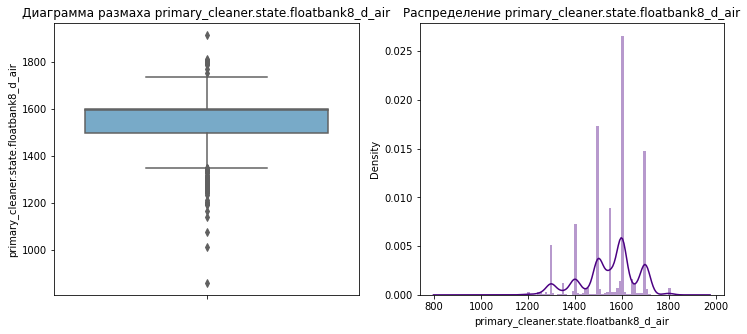

count    5048.00
mean     -499.75
std        31.50
min      -799.79
25%      -500.46
50%      -500.02
75%      -499.60
max      -158.95
Name: primary_cleaner.state.floatbank8_d_level, dtype: float64


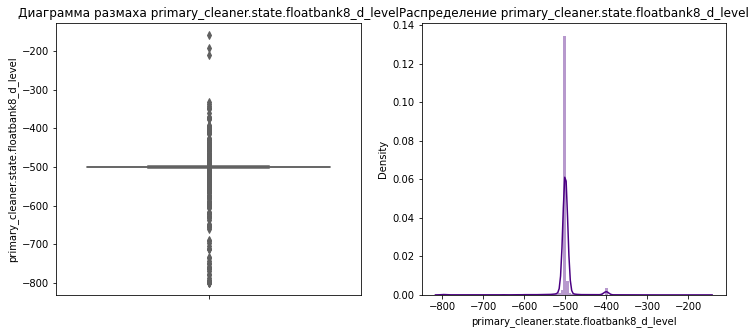

count    5048.00
mean        9.38
std         1.94
min         1.12
25%         8.11
50%         9.77
75%        10.68
max        14.41
Name: rougher.input.feed_ag, dtype: float64


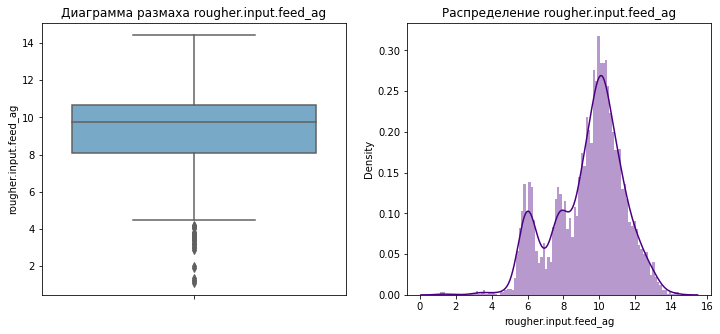

count    5048.00
mean        3.82
std         0.97
min         0.30
25%         3.26
50%         3.76
75%         4.32
max         6.91
Name: rougher.input.feed_pb, dtype: float64


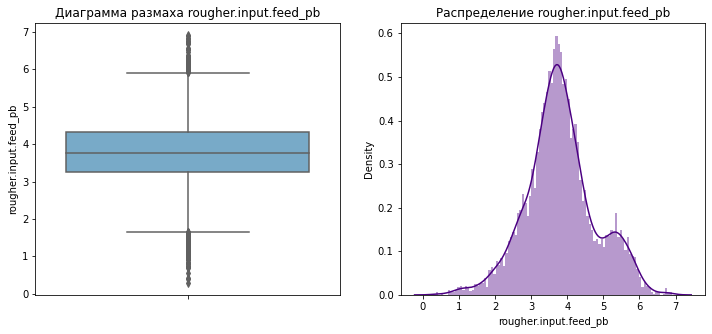

count    5048.00
mean      493.76
std       104.64
min         0.15
25%       410.46
50%       500.44
75%       578.42
max       707.36
Name: rougher.input.feed_rate, dtype: float64


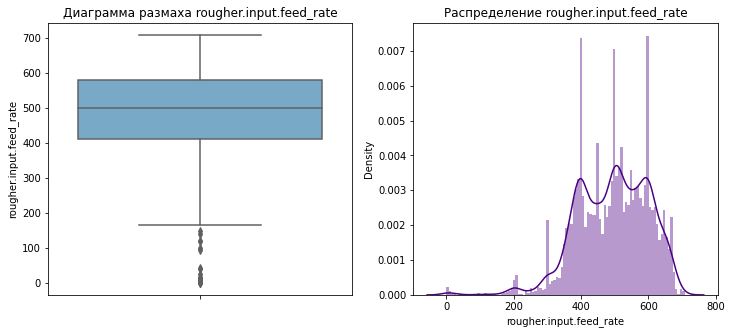

count    5048.00
mean       56.10
std        20.20
min        25.89
25%        43.86
50%        51.69
75%        62.56
max       477.45
Name: rougher.input.feed_size, dtype: float64


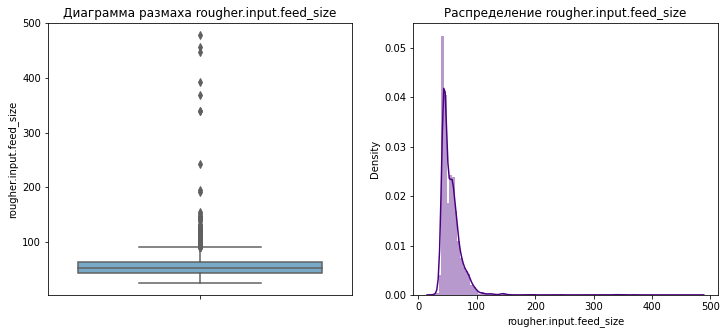

count    5048.00
mean       37.79
std         5.61
min         1.72
25%        34.55
50%        38.24
75%        41.71
max        53.48
Name: rougher.input.feed_sol, dtype: float64


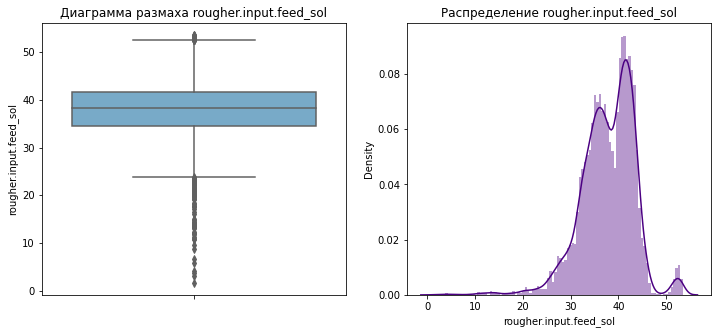

count    5048.00
mean        9.35
std         1.63
min         1.10
25%         8.23
50%         9.61
75%        10.48
max        13.52
Name: rougher.input.feed_au, dtype: float64


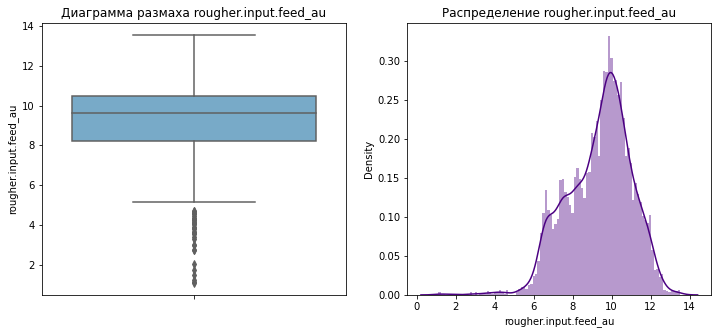

count    5048.00
mean       13.98
std         3.18
min         1.20
25%        12.00
50%        14.01
75%        17.00
max        24.28
Name: rougher.input.floatbank10_sulfate, dtype: float64


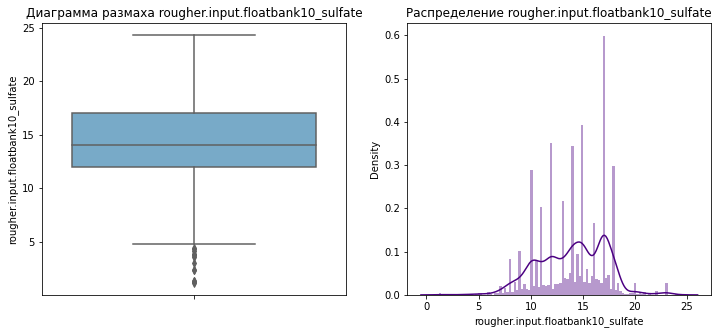

count    5048.00
mean        6.54
std         0.86
min         0.49
25%         6.00
50%         6.50
75%         7.10
max         8.51
Name: rougher.input.floatbank10_xanthate, dtype: float64


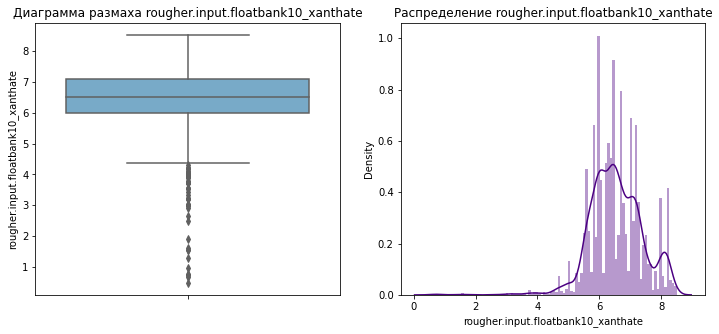

count    5048.00
mean       13.94
std         3.27
min         0.17
25%        11.99
50%        14.02
75%        17.00
max        24.28
Name: rougher.input.floatbank11_sulfate, dtype: float64


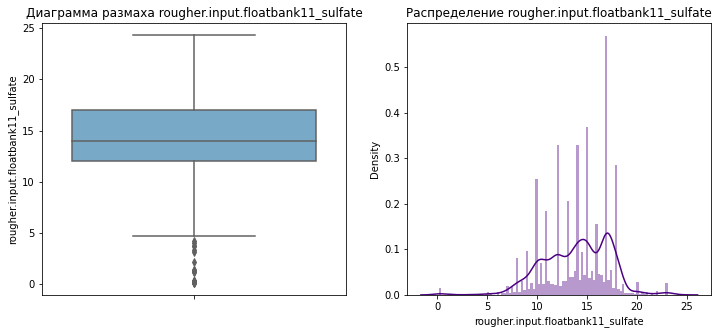

count    5048.00
mean        6.52
std         0.92
min         0.41
25%         6.00
50%         6.50
75%         7.10
max         8.62
Name: rougher.input.floatbank11_xanthate, dtype: float64


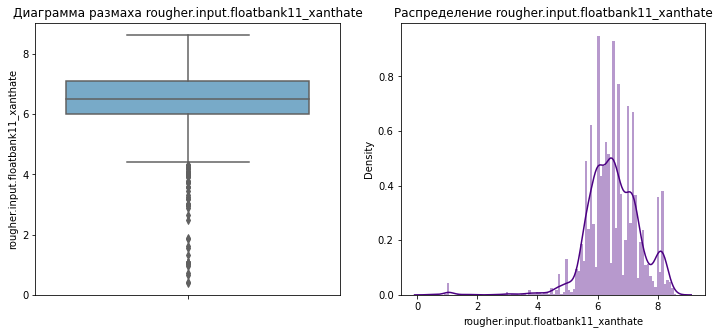

count    5048.00
mean     1057.27
std       120.97
min       498.98
25%       999.22
50%      1000.50
75%      1010.40
max      1423.27
Name: rougher.state.floatbank10_a_air, dtype: float64


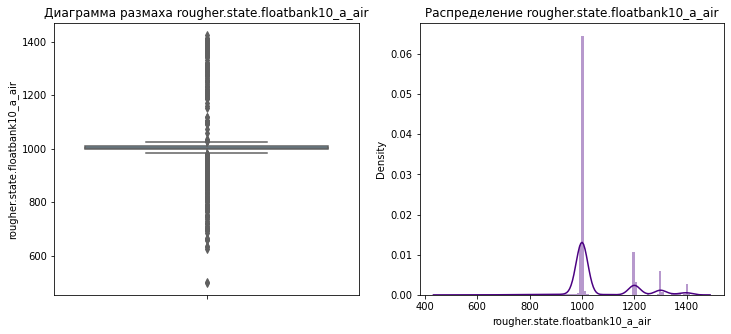

count    5048.00
mean     -390.97
std        89.41
min      -525.94
25%      -499.90
50%      -350.50
75%      -300.04
max      -273.78
Name: rougher.state.floatbank10_a_level, dtype: float64


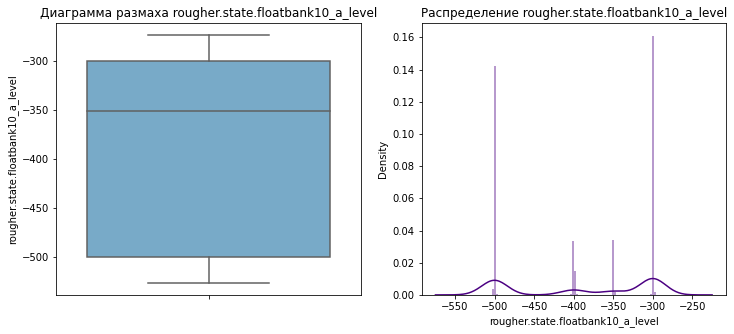

count    5048.00
mean     1319.53
std       156.81
min       851.09
25%      1200.45
50%      1302.38
75%      1439.79
max      1706.64
Name: rougher.state.floatbank10_b_air, dtype: float64


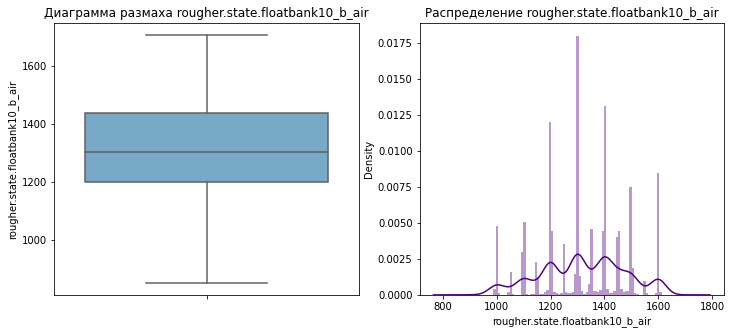

count    5048.00
mean     -475.11
std        45.81
min      -510.83
25%      -500.26
50%      -499.85
75%      -497.29
max      -298.20
Name: rougher.state.floatbank10_b_level, dtype: float64


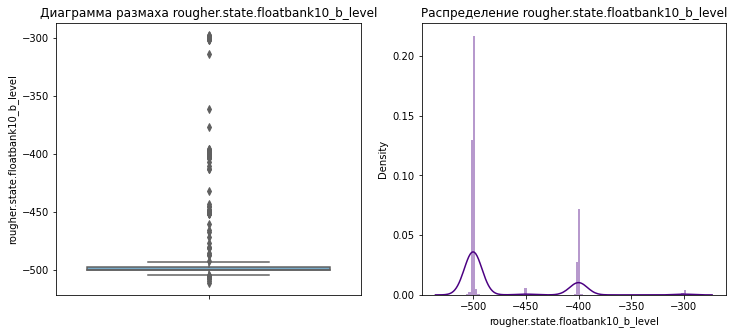

count    5048.00
mean     1301.36
std       172.51
min       897.75
25%      1198.44
50%      1300.52
75%      1409.72
max      1731.02
Name: rougher.state.floatbank10_c_air, dtype: float64


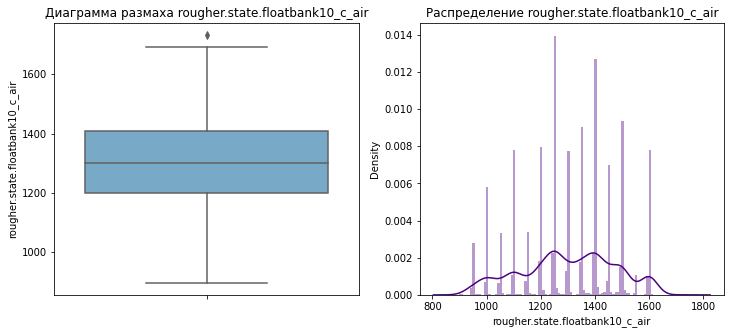

count    5048.00
mean     -474.87
std        46.35
min      -514.85
25%      -500.24
50%      -499.79
75%      -497.22
max      -296.30
Name: rougher.state.floatbank10_c_level, dtype: float64


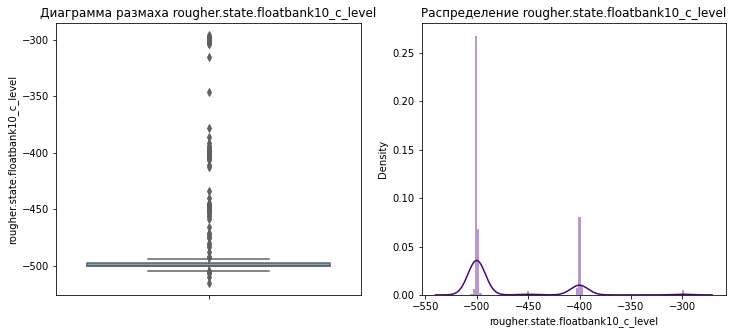

count    5048.00
mean     1214.05
std       187.03
min       754.31
25%      1014.46
50%      1207.24
75%      1392.66
max      1775.22
Name: rougher.state.floatbank10_d_air, dtype: float64


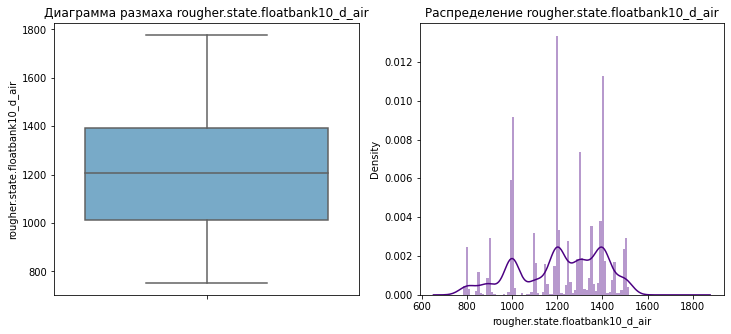

count    5048.00
mean     -475.20
std        47.14
min      -648.39
25%      -500.43
50%      -499.70
75%      -494.25
max      -292.06
Name: rougher.state.floatbank10_d_level, dtype: float64


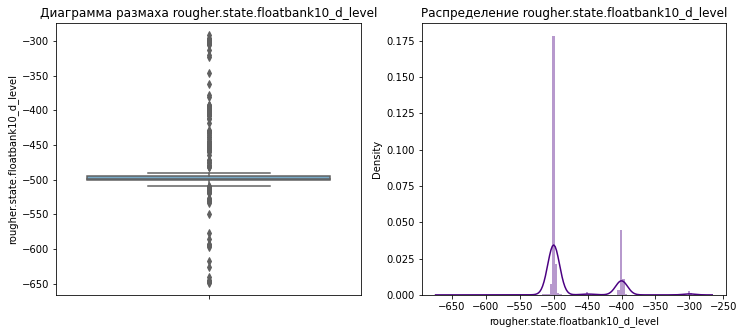

count    5048.00
mean     1058.18
std       132.28
min       795.08
25%       999.31
50%      1048.85
75%      1103.25
max      1467.18
Name: rougher.state.floatbank10_e_air, dtype: float64


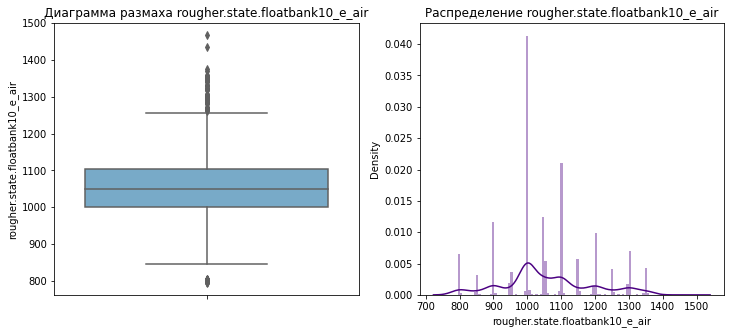

count    5048.00
mean     -468.92
std        60.16
min      -567.05
25%      -500.20
50%      -499.78
75%      -497.69
max      -294.80
Name: rougher.state.floatbank10_e_level, dtype: float64


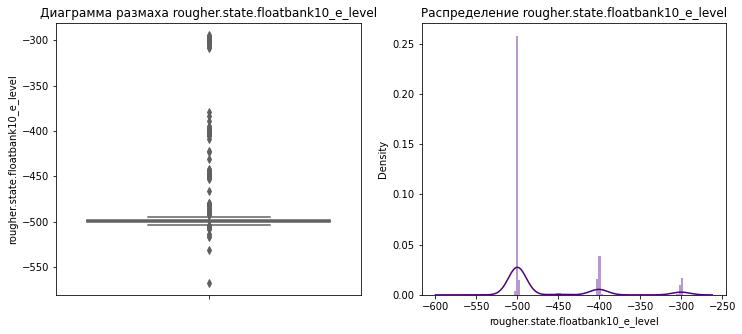

count    5048.00
mean     1000.38
std       128.79
min       696.30
25%       901.20
50%       999.56
75%      1050.93
max      1476.59
Name: rougher.state.floatbank10_f_air, dtype: float64


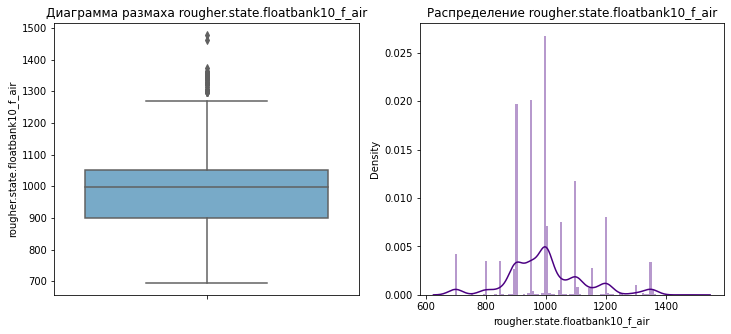

count    5048.00
mean     -469.27
std        59.89
min      -552.25
25%      -500.61
50%      -499.70
75%      -495.33
max      -249.80
Name: rougher.state.floatbank10_f_level, dtype: float64


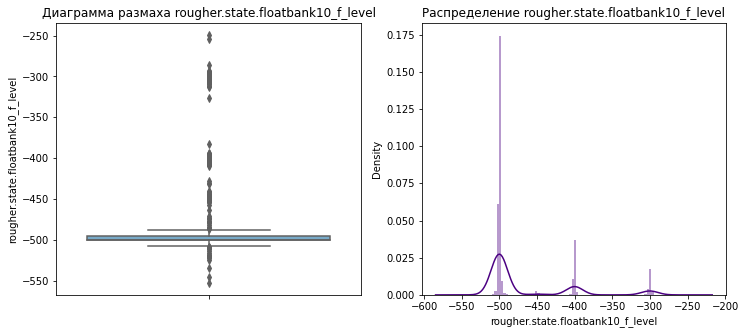

count    5048.00
mean       26.39
std         3.35
min         4.94
25%        24.95
50%        26.91
75%        28.86
max        32.14
Name: secondary_cleaner.state.floatbank2_a_air, dtype: float64


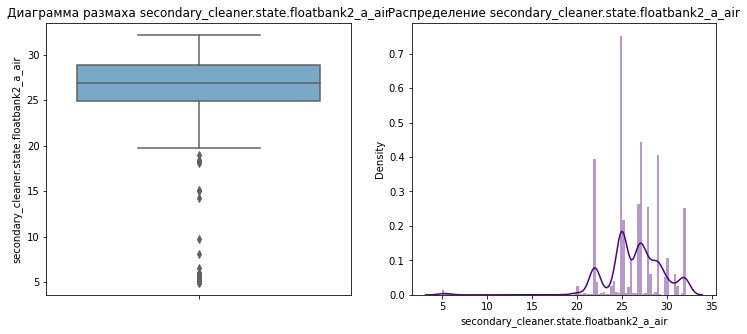

count    5048.00
mean     -502.75
std        28.27
min      -784.09
25%      -500.20
50%      -500.00
75%      -499.79
max      -374.37
Name: secondary_cleaner.state.floatbank2_a_level, dtype: float64


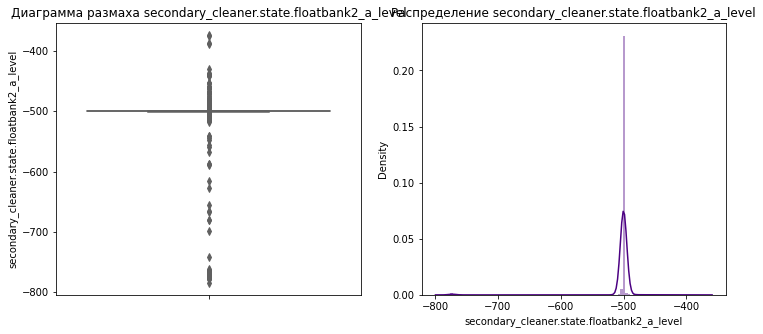

count    5048.00
mean       22.09
std         4.21
min         1.50
25%        20.01
50%        22.94
75%        25.01
max        28.17
Name: secondary_cleaner.state.floatbank2_b_air, dtype: float64


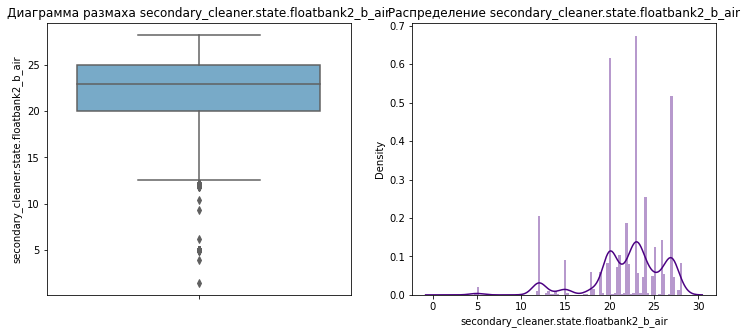

count    5048.00
mean     -502.04
std        34.11
min      -797.78
25%      -500.22
50%      -500.02
75%      -499.84
max      -267.11
Name: secondary_cleaner.state.floatbank2_b_level, dtype: float64


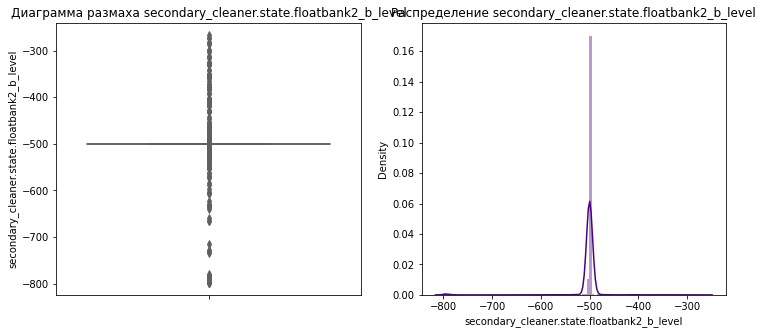

count    5048.00
mean       26.22
std         5.08
min         1.85
25%        23.01
50%        25.02
75%        30.01
max        40.04
Name: secondary_cleaner.state.floatbank3_a_air, dtype: float64


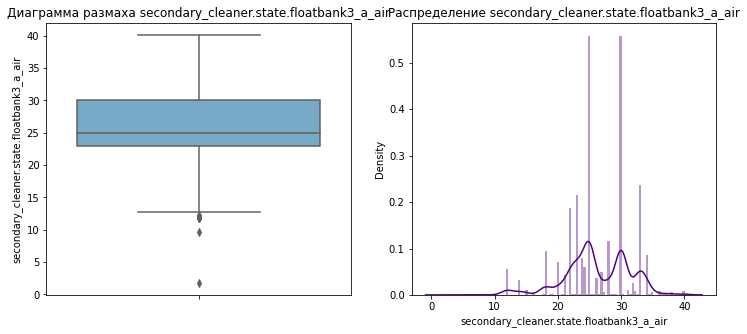

count    5048.00
mean     -500.06
std        10.62
min      -796.91
25%      -500.27
50%      -500.02
75%      -499.77
max      -313.87
Name: secondary_cleaner.state.floatbank3_a_level, dtype: float64


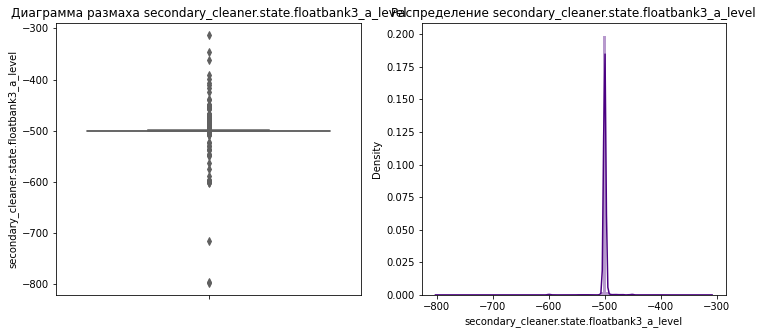

count    5048.00
mean       21.79
std         5.78
min         7.92
25%        18.00
50%        21.99
75%        26.98
max        32.04
Name: secondary_cleaner.state.floatbank3_b_air, dtype: float64


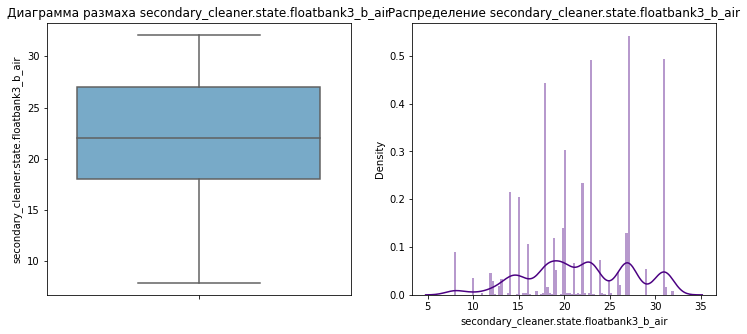

count    5048.00
mean     -500.16
std        15.86
min      -809.01
25%      -500.13
50%      -500.01
75%      -499.89
max      -218.77
Name: secondary_cleaner.state.floatbank3_b_level, dtype: float64


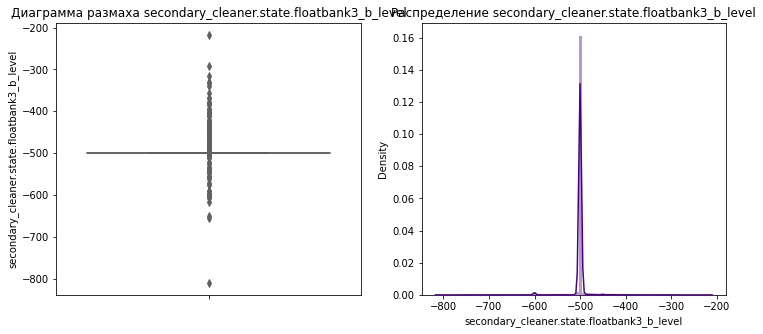

count    5048.00
mean       16.49
std         3.24
min         1.62
25%        14.96
50%        17.01
75%        18.07
max        21.07
Name: secondary_cleaner.state.floatbank4_a_air, dtype: float64


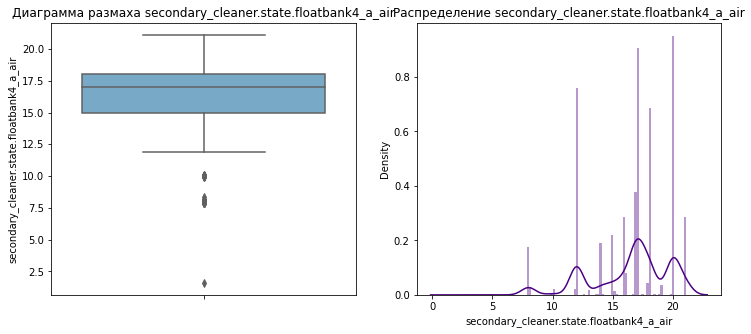

count    5048.00
mean     -503.71
std        23.55
min      -799.65
25%      -500.86
50%      -500.11
75%      -499.40
max      -401.57
Name: secondary_cleaner.state.floatbank4_a_level, dtype: float64


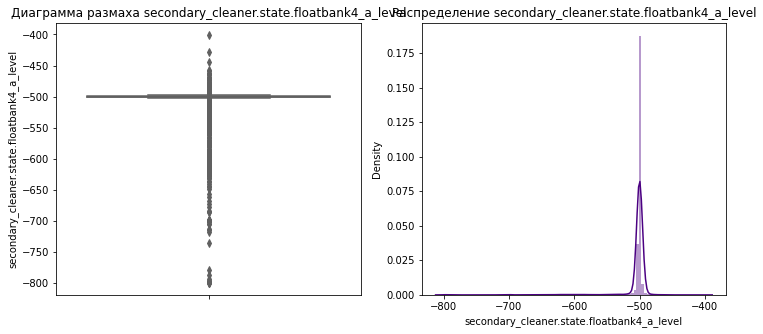

count    5048.00
mean       13.89
std         3.20
min         1.50
25%        12.11
50%        14.97
75%        15.95
max        20.32
Name: secondary_cleaner.state.floatbank4_b_air, dtype: float64


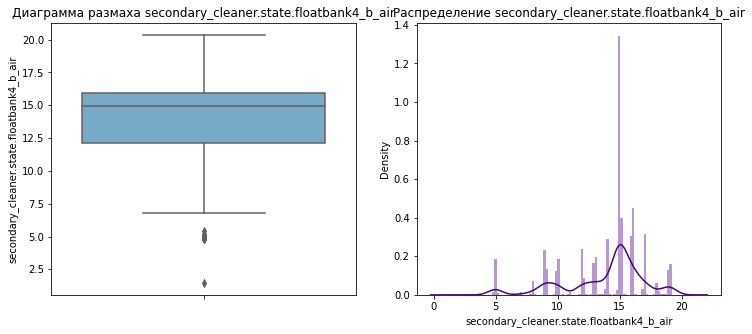

count    5048.00
mean     -461.62
std        80.25
min      -798.95
25%      -500.28
50%      -499.56
75%      -400.90
max      -110.55
Name: secondary_cleaner.state.floatbank4_b_level, dtype: float64


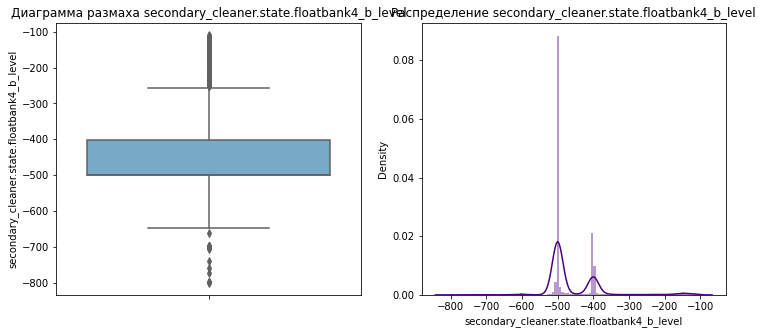

count    5048.00
mean       12.78
std         2.94
min         6.03
25%        10.92
50%        12.95
75%        15.03
max        25.26
Name: secondary_cleaner.state.floatbank5_a_air, dtype: float64


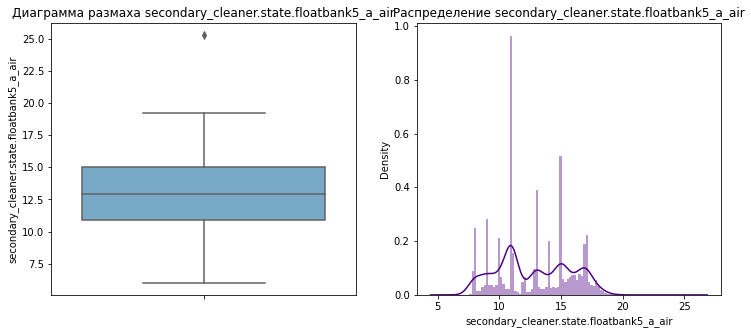

count    5048.00
mean     -500.82
std        15.56
min      -795.73
25%      -500.70
50%      -499.99
75%      -499.28
max      -244.48
Name: secondary_cleaner.state.floatbank5_a_level, dtype: float64


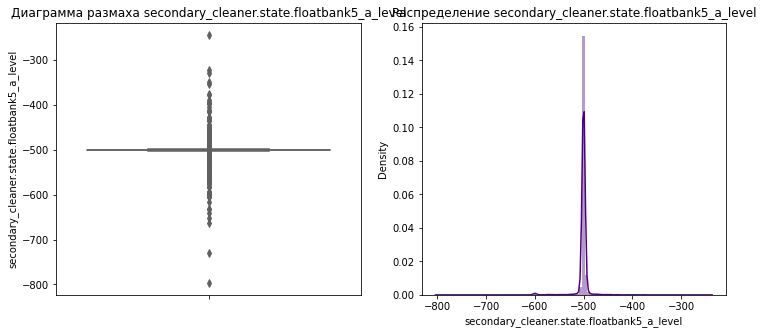

count    5048.00
mean        9.94
std         2.82
min         2.78
25%         8.05
50%        10.01
75%        12.00
max        14.09
Name: secondary_cleaner.state.floatbank5_b_air, dtype: float64


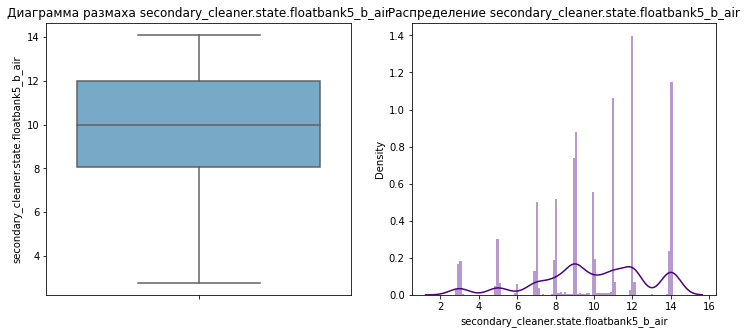

count    5048.00
mean     -495.49
std        32.30
min      -800.04
25%      -500.19
50%      -499.99
75%      -499.73
max      -137.74
Name: secondary_cleaner.state.floatbank5_b_level, dtype: float64


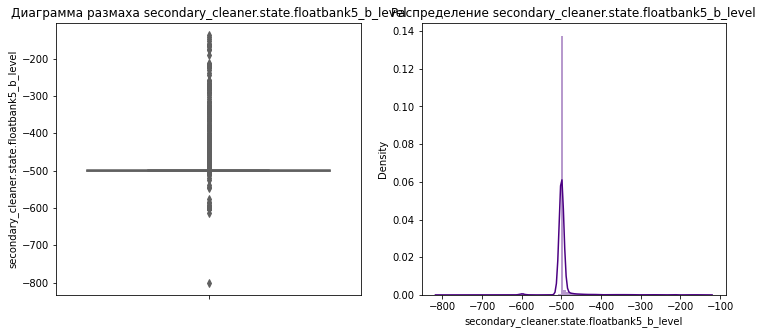

count    5048.00
mean       17.32
std         4.49
min         0.13
25%        14.00
50%        16.01
75%        21.01
max        26.71
Name: secondary_cleaner.state.floatbank6_a_air, dtype: float64


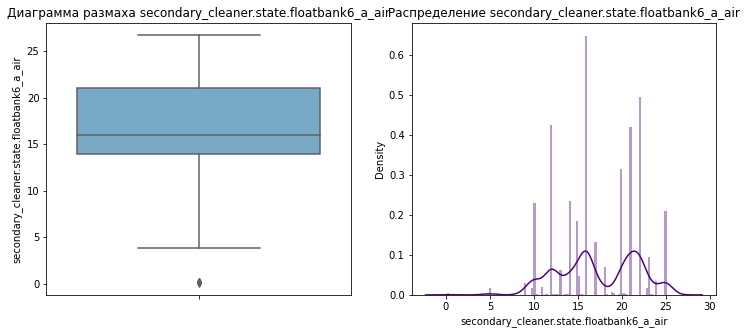

count    5048.00
mean     -501.33
std        38.05
min      -809.74
25%      -500.68
50%      -500.00
75%      -499.37
max      -123.31
Name: secondary_cleaner.state.floatbank6_a_level, dtype: float64


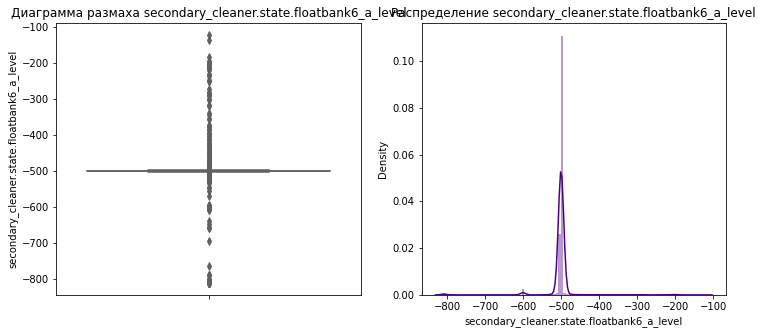

count    5048.00
mean       69.15
std         7.23
min         2.03
25%        65.87
50%        69.97
75%        73.32
max       100.00
Name: final.output.recovery, dtype: float64


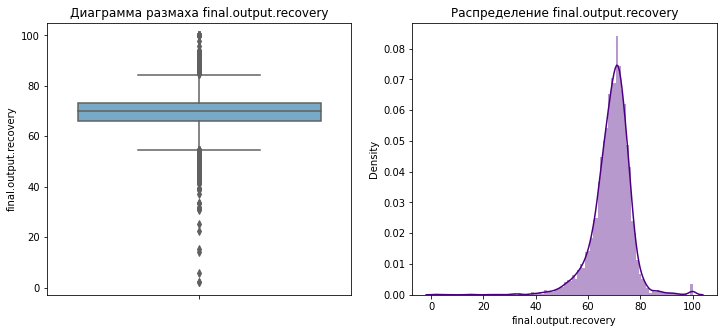

count    5048.00
mean       86.73
std         6.04
min         0.99
25%        84.80
50%        87.53
75%        89.83
max        99.17
Name: rougher.output.recovery, dtype: float64


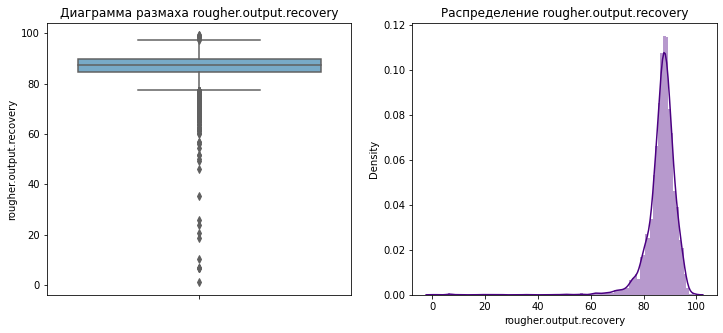

In [35]:
if PLOTS_ARE_NEEDED:
    float_data_analyzer(data_test, data_test.columns, bins=100, round_lim=2)
else:
    print('Параметр plots_are_needed равен', PLOTS_ARE_NEEDED, ', измените значение на True чтобы увидеть графики')

#### full

In [36]:
# Drop full.
data_full = drop_anomal_val(data_full, 'полной', 0.1, anomal_features_list)
data_full.set_index('date', inplace=True)

Размер полной выборки:22694
*Обработка*
Размер полной выборки:18784


### 1.4.8 Вывод по удалению аномалий

После фильтрации распределения стали выглядеть более естественно, удалено ~800 строк (13%) из тестовой выборки, ~3100 (18%) из обучающей, ~3900 (17%) из общей.

## Вывод по этапу

На данном этапе:
- проведено ознакомление с данными; 
- изучен тех. процесс очистки золота;
- проведена проверка расчёта эффективности обогащения золота, рассчитанные данные близки к исходным, можно считать исходные данные корректными;
- отобраны обучающие и целевые признаки;
- заполнены пропуски и удалены аномалии.

Данные готовы к дальнейшему анализу.

# 2. Анализ данных

## 2.1 Анализ концентраций металлов (Au, Ag, Pb) и других примсей (Sol) на различных этапах очистки

Требуется проанализировать изменения в концентрациях металлов на разных этапах очистки. Для этого подойдут выборки train и full.

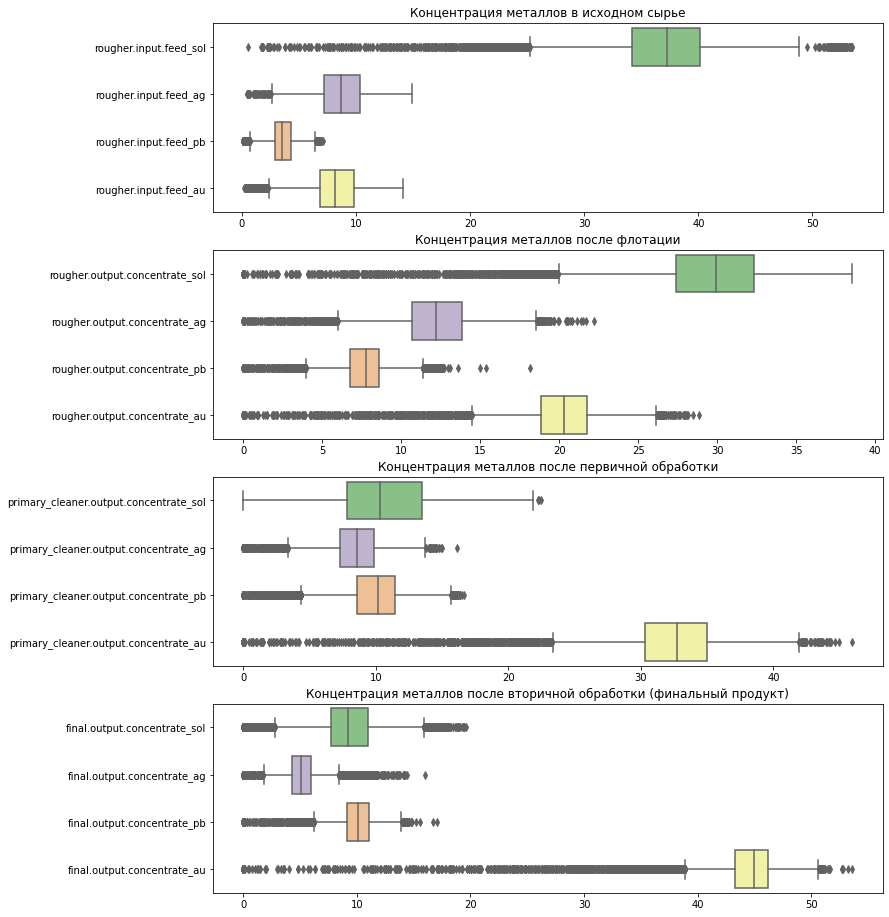

In [37]:
# Common boxplots for each stage.
fig, ax = plt.subplots(4, 1, figsize=(12, 16))
ax[0].set_title(f'Концентрация металлов в исходном сырье')
sns.boxplot(data=data_full[['rougher.input.feed_sol',
                             'rougher.input.feed_ag',
                             'rougher.input.feed_pb',
                             'rougher.input.feed_au']],
                             ax=ax[0], palette='Accent',
                             orient='h', 
                             width=0.8)
ax[1].set_title(f'Концентрация металлов после флотации')
sns.boxplot(data=data_full[['rougher.output.concentrate_sol',
                             'rougher.output.concentrate_ag',
                             'rougher.output.concentrate_pb',
                             'rougher.output.concentrate_au']],
                             ax=ax[1], palette='Accent',
                             orient='h', 
                             width=0.8)
ax[2].set_title(f'Концентрация металлов после первичной обработки')
sns.boxplot(data=data_full[['primary_cleaner.output.concentrate_sol',
                             'primary_cleaner.output.concentrate_ag',
                             'primary_cleaner.output.concentrate_pb',
                             'primary_cleaner.output.concentrate_au']],
                             ax=ax[2], palette='Accent',
                             orient='h', 
                             width=0.8)
ax[3].set_title(f'Концентрация металлов после вторичной обработки (финальный продукт)')
sns.boxplot(data=data_full[['final.output.concentrate_sol',
                             'final.output.concentrate_ag',
                             'final.output.concentrate_pb',
                             'final.output.concentrate_au']],
                             ax=ax[3], palette='Accent',
                             orient='h', 
                             width=0.8)
plt.show()

In [38]:
def plot_concentrate(data, material):
    '''This function plot boxplots for each stages for inptued material.
        Input:
        data — dataset with concentrates;
        material — material postfix in data-columns: au, ag, pb, sol.
        
        Output:
        boxplots for each stage.'''

    fig = plt.figure(figsize=(12, 5))
    ax = sns.boxplot(data=data[['rougher.input.feed_'+ material, 
                                'rougher.output.concentrate_'+ material, 
                                'primary_cleaner.output.concentrate_'+ material, 
                                'final.output.concentrate_'+ material]],
                                palette='Accent',
                                orient='h')
    ax.set_title('Концентрация {} на разных этапах очистки'.format(material))
    ax.set_yticklabels(['Исходный продукт','Флотация','Первичная очистка','Финальный продукт'])

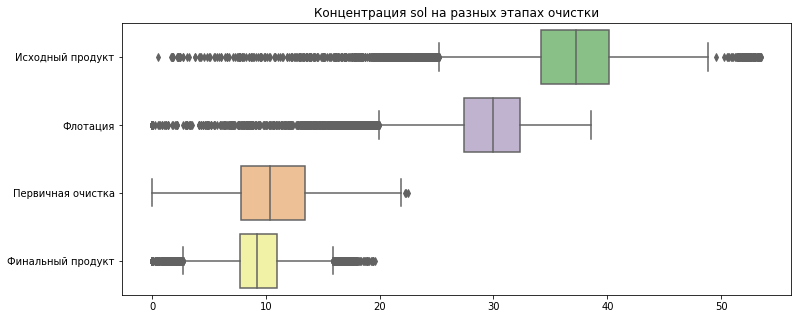

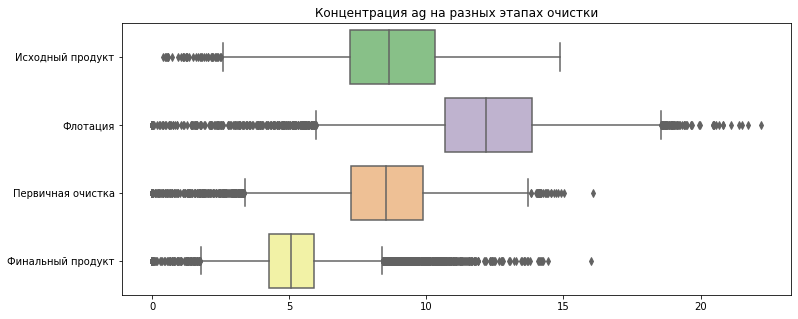

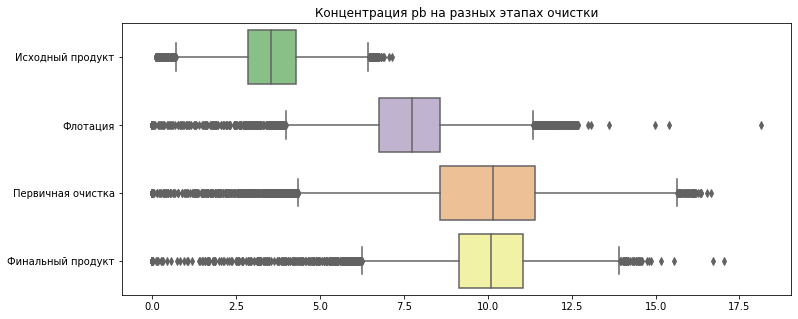

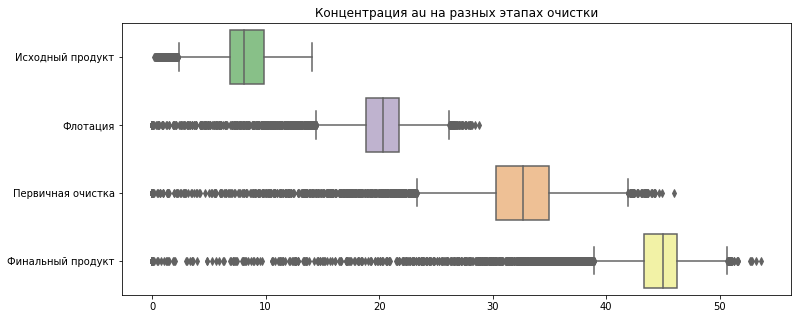

In [39]:
for material in ['sol', 'ag', 'pb', 'au']:
    plot_concentrate(data_full, material)

Исходя из полученных графиков можно сделать следующие выводы:
- концентрация sol падает после каждой стадии обработки;
- концентрация ag увеличивается после флотации, но падает на дальнейших этапах;
- концентрация pb несколько увеличивается в ходе обработки (в основном после флотации);
- концентрация золота, как и ожидается, растёт.

## 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Чтобы оценка даваемая моделью была корректна, требуется чтобы распределения размеров гранул не сильно отличались между собой.

count    13736.00
mean        59.76
std         23.31
min          9.66
25%         48.96
50%         55.34
75%         65.59
max        484.97
Name: rougher.input.feed_size, dtype: float64


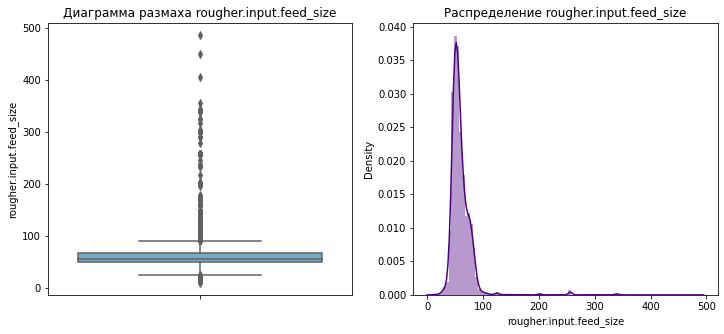

count    5048.00
mean       56.10
std        20.20
min        25.89
25%        43.86
50%        51.69
75%        62.56
max       477.45
Name: rougher.input.feed_size, dtype: float64


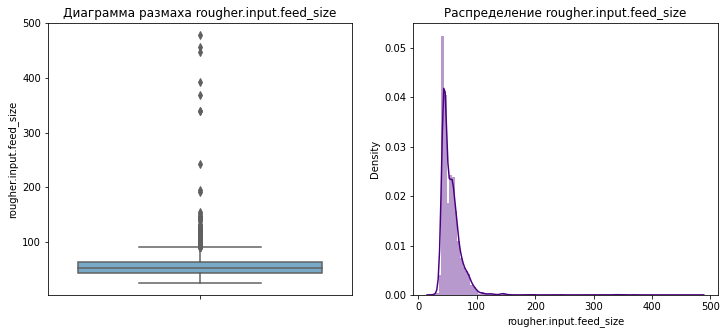

In [40]:
# Print & plot stat.
for data in [data_train, data_test]:
    float_data_analyzer(data, ['rougher.input.feed_size'], bins=100, round_lim=2)

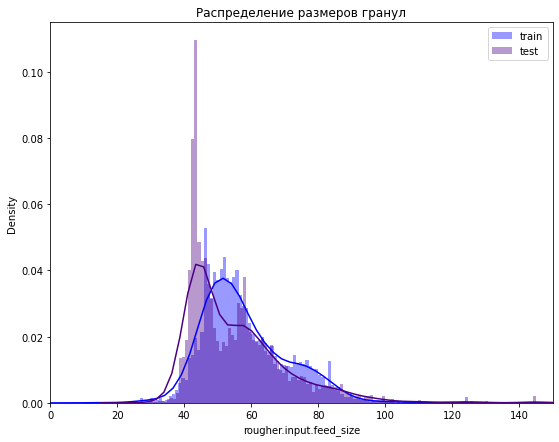

In [41]:
# Common distribution.
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
sns.distplot(data_train['rougher.input.feed_size'], bins=500, color='blue', label='train')
sns.distplot(data_test['rougher.input.feed_size'], bins=500, color='indigo', label='test')     
plt.title('Распределение размеров гранул')
plt.xlim((0, 150))
plt.legend()
plt.show()

Распределения немного отличаются (test сильнее скошен влево и имеет более ярко выраженный пик), но в целом похожи.

## 2.3 Исследование суммарной концентрации всех веществ на разных стадиях

### 2.3.1 Обзор

Требуется исследовать суммарную концентрацию всех веществ на разных стадиях.

In [42]:
def concentrate_analyser(data):
    '''This function calculate concentrate for each stages for au, ag, pb. sol from inputed data 
    & plot their distribution.
        Input:
        data — dataset with concentrates.
        
        Output:
        plot concentrate distribution & print stat-describtion.'''

    feed_columns = data.columns[data.columns.str.contains('feed_ag|feed_au|feed_pb|feed_sol')]
    data['concentrate_feed_sum'] = data[feed_columns].sum(axis=1)

    rougher_columns = data.columns[data.columns.str.contains('rougher.output.concentrate')]
    data['concentrate_rougher_sum'] = data[rougher_columns].sum(axis=1)

    primary_columns = data.columns[data.columns.str.contains('primary_cleaner.output.concentrate')]
    data['concentrate_primary_sum'] = data[primary_columns].sum(axis=1)
    
    final_columns = data.columns[data.columns.str.contains('final.output.concentrate')]
    data['concentrate_final_sum'] = data[final_columns].sum(axis=1)

    for column in ['concentrate_feed_sum', 'concentrate_rougher_sum',
                   'concentrate_primary_sum', 'concentrate_final_sum']:
                   float_data_analyzer(data, [column], bins=100, round_lim=2)
    return data

count    13736.00
mean        56.25
std          7.44
min          2.90
25%         52.61
50%         56.79
75%         60.99
max         76.02
Name: concentrate_feed_sum, dtype: float64


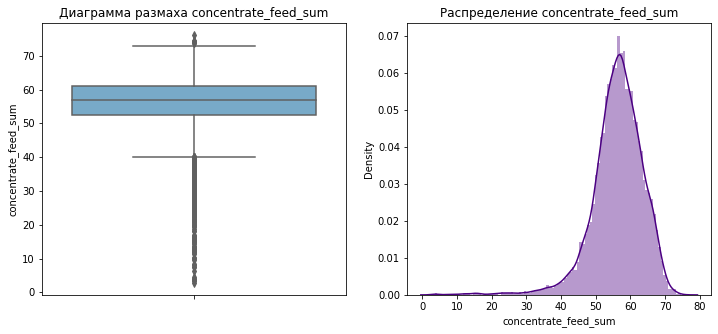

count    13736.00
mean        67.98
std         10.78
min          0.00
25%         65.05
50%         69.27
75%         73.66
max         90.96
Name: concentrate_rougher_sum, dtype: float64


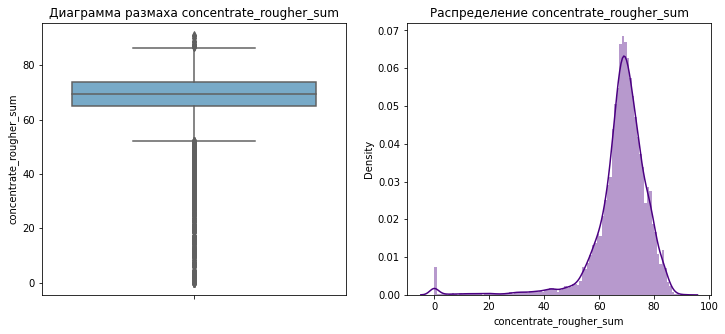

count    13736.00
mean        59.86
std         11.14
min          0.00
25%         58.05
50%         61.87
75%         65.32
max         76.92
Name: concentrate_primary_sum, dtype: float64


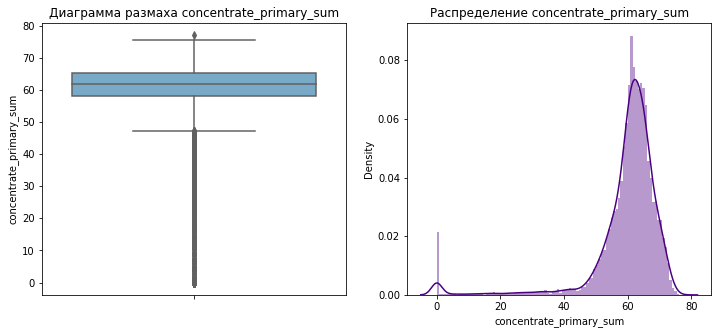

count    13736.00
mean        68.31
std          7.11
min          0.00
25%         67.52
50%         69.14
75%         70.93
max         80.21
Name: concentrate_final_sum, dtype: float64


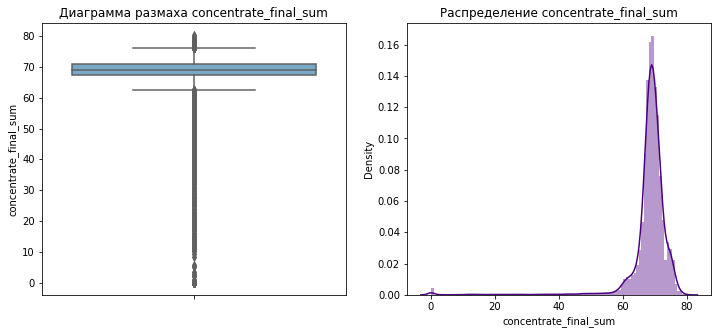

In [43]:
# Total concentrate on train.
data_train = concentrate_analyser(data_train)

count    18784.00
mean        57.35
std          7.55
min          2.90
25%         53.59
50%         57.74
75%         62.15
max         76.98
Name: concentrate_feed_sum, dtype: float64


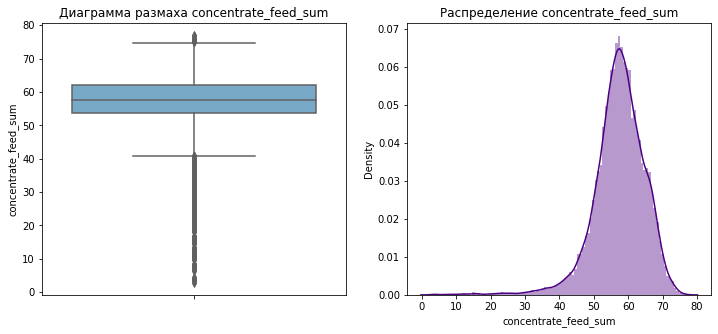

count    18784.00
mean        69.10
std         10.05
min          0.00
25%         66.21
50%         70.34
75%         74.62
max         90.96
Name: concentrate_rougher_sum, dtype: float64


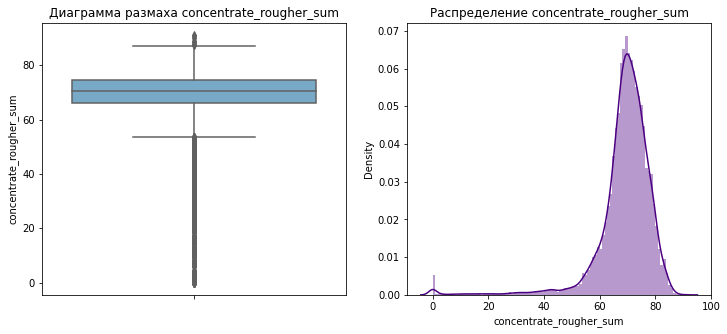

count    18784.00
mean        60.54
std         10.54
min          0.00
25%         58.97
50%         62.51
75%         65.63
max         80.75
Name: concentrate_primary_sum, dtype: float64


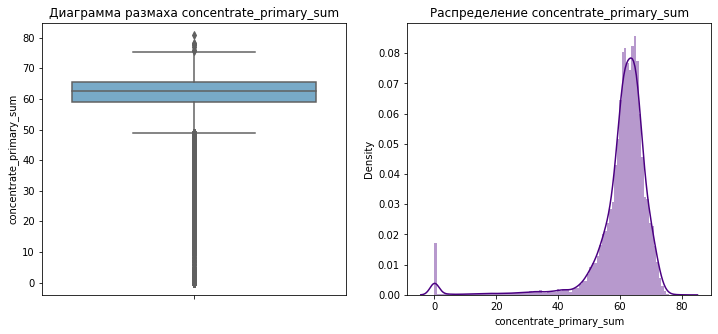

count    18784.00
mean        68.71
std          6.97
min          0.00
25%         67.90
50%         69.60
75%         71.33
max         80.21
Name: concentrate_final_sum, dtype: float64


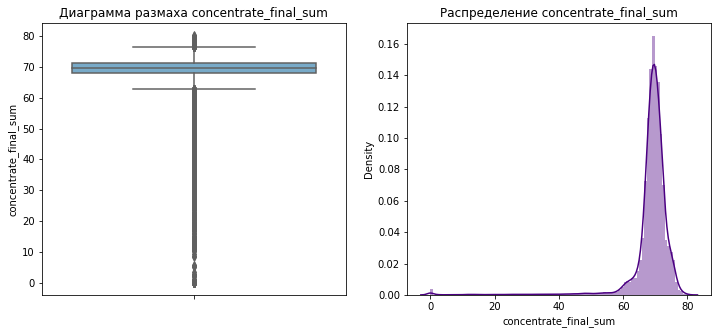

In [44]:
# Total concentrate on full.
data_full = concentrate_analyser(data_full)

Анализ суммарной коцнентрации показал, что в распределениях концентраций имеются выбросы в районе нуля. Удаление аномальных значений на предыдущем этапе несколько сгладило эти выбросы, но не окончательно.

### 2.3.2 Удаление аномалий

In [45]:
# Reset index.
data_train.reset_index(level=0, inplace=True)
data_full.reset_index(level=0, inplace=True)

# Refresh anomal_features_list.
anomal_features_list = ['concentrate_feed_sum', 'concentrate_rougher_sum',
                   'concentrate_primary_sum', 'concentrate_final_sum']

In [46]:
# Cleaning.
data_train = drop_anomal_val(data_train, 'тренировочной', 0.1, anomal_features_list)
data_train.set_index('date', inplace=True)

data_full = drop_anomal_val(data_full, 'полной', 0.1, anomal_features_list)
data_full.set_index('date', inplace=True)


Размер тренировочной выборки:13736
*Обработка*
Размер тренировочной выборки:13399
Размер полной выборки:18784
*Обработка*
Размер полной выборки:18409


После удаления аномалий
count    13399.00
mean        56.31
std          7.31
min          3.38
25%         52.66
50%         56.78
75%         60.97
max         76.02
Name: concentrate_feed_sum, dtype: float64


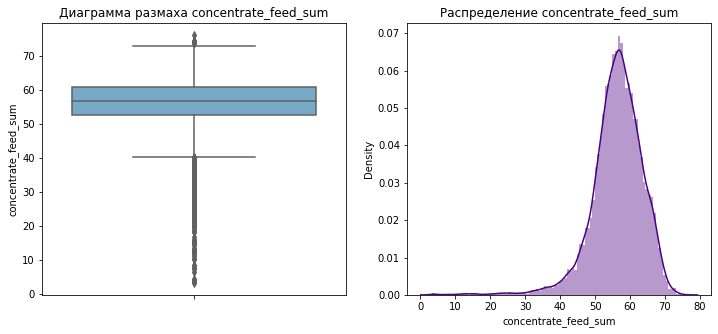

count    13399.00
mean        68.50
std          9.17
min          0.12
25%         65.21
50%         69.33
75%         73.69
max         90.96
Name: concentrate_rougher_sum, dtype: float64


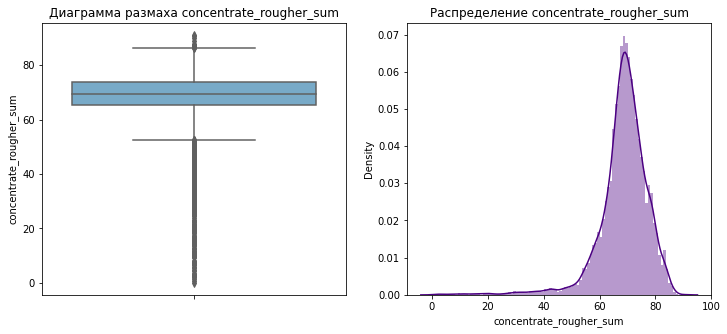

count    13399.00
mean        60.91
std          8.00
min          0.11
25%         58.38
50%         61.98
75%         65.40
max         76.92
Name: concentrate_primary_sum, dtype: float64


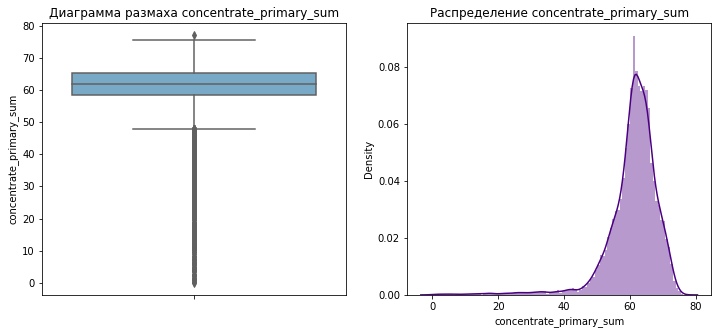

count    13399.00
mean        68.61
std          5.67
min          0.84
25%         67.53
50%         69.16
75%         70.95
max         80.21
Name: concentrate_final_sum, dtype: float64


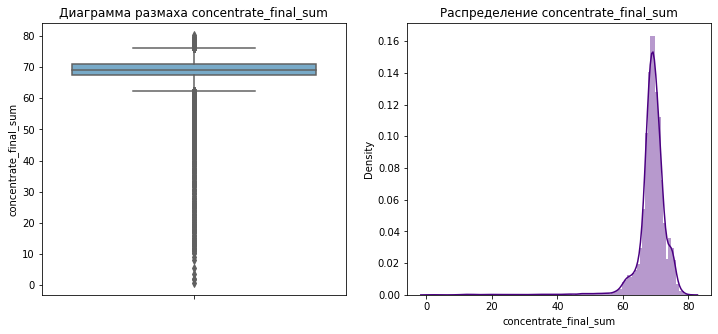

In [47]:
# Total concentrate on train.
print("После удаления аномалий")
data_train = concentrate_analyser(data_train)

После удаления аномалий
count    18409.00
mean        57.40
std          7.43
min          3.38
25%         53.63
50%         57.74
75%         62.13
max         76.98
Name: concentrate_feed_sum, dtype: float64


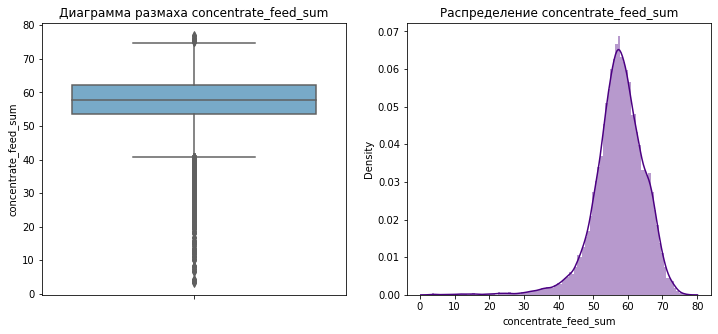

count    18409.00
mean        69.49
std          8.72
min          0.12
25%         66.33
50%         70.40
75%         74.64
max         90.96
Name: concentrate_rougher_sum, dtype: float64


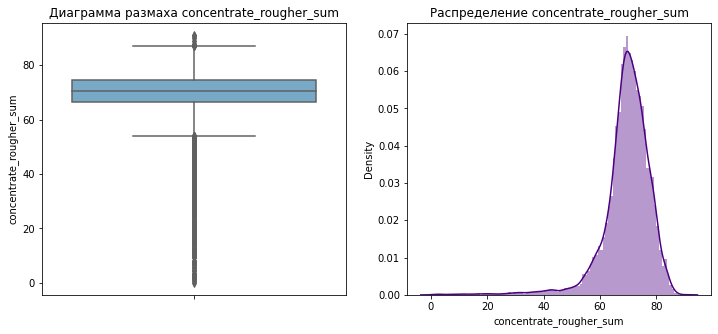

count    18409.00
mean        61.43
std          7.71
min          0.11
25%         59.20
50%         62.61
75%         65.68
max         80.75
Name: concentrate_primary_sum, dtype: float64


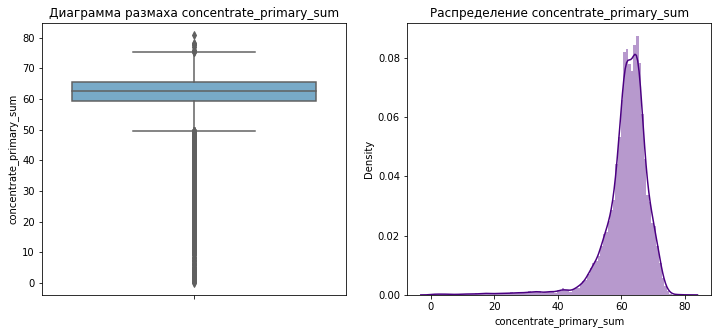

count    18409.00
mean        68.95
std          5.82
min          0.28
25%         67.92
50%         69.62
75%         71.36
max         80.21
Name: concentrate_final_sum, dtype: float64


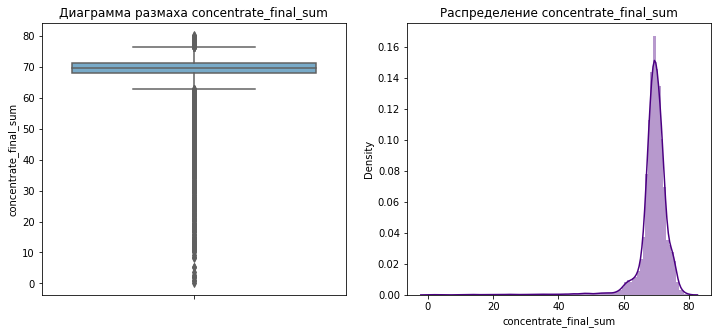

In [48]:
# Total concentrate on full.
print("После удаления аномалий")
data_full = concentrate_analyser(data_full)

In [49]:
data_train.drop(anomal_features_list, axis=1, inplace=True)
data_full.drop(anomal_features_list, axis=1, inplace=True)

In [50]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13399 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         13399 non-null  float64
 1   final.output.concentrate_pb                         13399 non-null  float64
 2   final.output.concentrate_sol                        13399 non-null  float64
 3   final.output.concentrate_au                         13399 non-null  float64
 4   final.output.recovery                               13399 non-null  float64
 5   final.output.tail_ag                                13399 non-null  float64
 6   final.output.tail_pb                                13399 non-null  float64
 7   final.output.tail_sol                               13399 non-null  float64
 8   final.output.tail_au                     

После удаления строк со значениями суммарной концентрации меньших 0.1 аномальные пики исчезли с распределений. В целом суммарная концентрация металлов растёт в течение процесса обработки.

## Вывод по этапу

В ходе данного этапа был проведён анализ тех. процесса и изменения показателей сырья в зависимости от стадии. Получены следующие резултьтаты:
- концентрация sol падает после каждой стадии обработки;
- концентрация ag увеличивается после флотации, но падает на дальнейших этапах;
- концентрация pb несколько увеличивается в ходе обработки (в основном после флотации);
- концентрация золота, как и ожидается, растёт;
- размеры гранул в обучающей и тестовой выборке несколько отличаются, но в целом похожи;
- при подсчёте суммарных концентраций металлов на каждой стадии были обнаружены аномальный пики в районе 0; вероятно это вызвано ошибками в работе датчиков.

Данные проанализированы и обработаны, можно строить модель.


# 3. Модель

## 3.1 Создание функции-метрики

По условию задания требуется качество модели оценить с помощью sMAPE (Symmetric Mean Absolute Percentage Error).

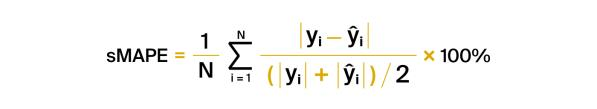

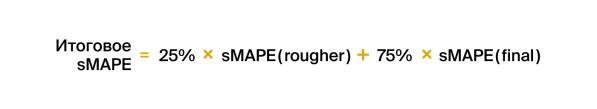

In [51]:
def smape(targets, predictions):
    '''This function calculate smape.
    Input:
    target, predictions.
    
    Output:
    calculated smape.'''
    expression = (
        abs(targets - predictions)
    / 
        ((abs(targets) + abs(predictions)) / 2)
    ) * 100
    smape = expression.sum()

    rougher = smape['rougher.output.recovery'] / len(expression)
    final = smape['final.output.recovery'] / len(expression)
    
    return (0.25 * rougher) + (0.75 * final)

Для подбора параметров с помощью GridSearchCV требуется указать параметер greater_is_better=False, т.к. данная методика основана на максимизации метрики. В случае sMAPE чем по модулю значение меньше, тем лучше.

In [52]:
smape_score = make_scorer(smape, greater_is_better=False)

## 3.2 Обучение и проверка моделей

### 3.2.1 Разбиение на features и target

In [53]:
# Declare features & targets.
features_train = data_train[features_list]
target_train = data_train[target_list]

features_test = data_test[features_list]
target_test = data_test[target_list]

In [54]:
features_test.head()

primary_cleaner.input.depressant  \
date                                                    
2016-09-01 00:59:59                         14.993118   
2016-09-01 01:59:59                         14.987471   
2016-09-01 02:59:59                         12.884934   
2016-09-01 03:59:59                         12.006805   
2016-09-01 04:59:59                         10.682530   

                     primary_cleaner.input.feed_size  \
date                                                   
2016-09-01 00:59:59                         8.080000   
2016-09-01 01:59:59                         8.080000   
2016-09-01 02:59:59                         7.786667   
2016-09-01 03:59:59                         7.640000   
2016-09-01 04:59:59                         7.530000   

                     primary_cleaner.input.sulfate  \
date                                                 
2016-09-01 00:59:59                     210.800909   
2016-09-01 01:59:59                     215.392455   
2016-09-01 02:59:59                     215.259946   
2016-09-01 03:59:59                     215.336236   
2016-09-01 04:59:59                     199.099327   

                     primary_cleaner.input.xanthate  \
date                                                  
2016-09-01 00:59:59                        1.005021   
2016-09-01 01:59:59                        0.990469   
2016-09-01 02:59:59                        0.996043   
2016-09-01 03:59:59                        0.863514   
2016-09-01 04:59:59                        0.805575   

                     primary_cleaner.state.floatbank8_a_air  \
date                                                          
2016-09-01 00:59:59                             1398.981301   
2016-09-01 01:59:59                             1398.777912   
2016-09-01 02:59:59                             1398.493666   
2016-09-01 03:59:59                             1399.618111   
2016-09-01 04:59:59                             1401.268123   

                     primary_cleaner.state.floatbank8_a_level  \
date                                                            
2016-09-01 00:59:59                               -500.225577   
2016-09-01 01:59:59                               -500.057435   
2016-09-01 02:59:59                               -500.868360   
2016-09-01 03:59:59                               -498.863574   
2016-09-01 04:59:59                               -500.808305   

                     primary_cleaner.state.floatbank8_b_air  \
date                                                          
2016-09-01 00:59:59                             1399.144926   
2016-09-01 01:59:59                             1398.055362   
2016-09-01 02:59:59                             1398.860436   
2016-09-01 03:59:59                             1397.440120   
2016-09-01 04:59:59                             1398.128818   

                     primary_cleaner.state.floatbank8_b_level  \
date                                                            
2016-09-01 00:59:59                               -499.919735   
2016-09-01 01:59:59                               -499.778182   
2016-09-01 02:59:59                               -499.764529   
2016-09-01 03:59:59                               -499.211024   
2016-09-01 04:59:59                               -499.504543   

                     primary_cleaner.state.floatbank8_c_air  \
date                                                          
2016-09-01 00:59:59                             1400.102998   
2016-09-01 01:59:59                             1396.151033   
2016-09-01 02:59:59                             1398.075709   
2016-09-01 03:59:59                             1400.129303   
2016-09-01 04:59:59                             1402.172226   

                     primary_cleaner.state.floatbank8_c_level  \
date                                                            
2016-09-01 00:59:59                               -500.704369   
2016-09-01 01:59:59           

In [55]:
target_test.head()

final.output.recovery  rougher.output.recovery
date                                                               
2016-09-01 00:59:59              70.273583                89.993421
2016-09-01 01:59:59              68.910432                88.089657
2016-09-01 02:59:59              68.143213                88.412756
2016-09-01 03:59:59              67.776393                87.360133
2016-09-01 04:59:59              61.467078                83.236367

### 3.2.2 Линейная регрессия

Поскольку отбор моделей будет происходить с помощью кроссвалидации, отдельная валидационная выборка не нужна.

In [56]:
def cross_validation(model, features, target, cv, score_func):
    scores = cross_val_score(model, features, target, cv=cv, scoring=score_func)
    return scores.mean()

In [57]:
# Declare model.
lin_regr = LinearRegression()

In [58]:
%%time
# Crossval fitting.
regr_score_train = cross_validation(lin_regr, features_train, target_train, KFold(5), smape_score)

CPU times: user 274 ms, sys: 234 ms, total: 509 ms
Wall time: 276 ms


In [59]:
# Making predictions.
lin_regr.fit(features_train, target_train)
regr_predictions = lin_regr.predict(features_test)
regr_score_test = smape(target_test, regr_predictions)

In [60]:
# Print metrics.
print(f'sMAPE линейной регрессии на обучающей выборке: {round(abs(regr_score_train), 2)}% (crossvalidation)')
print(f'sMAPE линейной регрессии на тестовой выборке: {round(regr_score_test, 2)}%')

sMAPE линейной регрессии на обучающей выборке: 10.38% (crossvalidation)
sMAPE линейной регрессии на тестовой выборке: 7.16%


Чем меньше значение sMAPE, тем модель точнее. Линейная регрессия на тестовой выборке показывает себя лучше, чем на обучающей. Это интересно.

### 3.2.3 Решающее дерево

In [61]:
# Declare model.
#tree = DecisionTreeRegressor(random_state=666)
#tree

In [62]:
# Create grid of parameters for grid_search.
#parameters_grid = {'max_depth': range(2, 20, 2), 
#                   'min_samples_leaf': range(2, 8, 1), 
#                   'min_samples_split': range(2, 8, 1)}

In [63]:
#grid_search_tree = GridSearchCV(cv=KFold(5), estimator=tree, param_grid=parameters_grid, scoring=smape_score)

In [64]:
#%%time
# Looking for tree's best params.
#grid_search_tree.fit(features_train, target_train)

In [65]:
# Best params.
#print(grid_search_tree.best_params_)

# Best score.
#print(f'sMAPE решающего дерева на обучающей выборке: {round(abs(grid_search_tree.best_score_, 2))}% (crossvalidation)')

Лучшие параметры для дерева: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 7}.

Лучший sMAPE дерева : 9.24297461586552.

CPU times:
- user: 14min 17s,
- sys: 529 ms,
- total: 14min 18s,
- Wall time: 14min 19s.


In [66]:
# Best model fit & predict.
best_tree = DecisionTreeRegressor(random_state=666, max_depth=2, min_samples_leaf=2, min_samples_split=7)
best_tree.fit(features_train, target_train)


# Score on train.
tree_predictions = best_tree.predict(features_train)
tree_score_train = smape(target_train, tree_predictions) 
print(f'sMAPE решающего дерева на тренировочной выборке: {round(tree_score_train, 2)}%')

# Score on test.
tree_predictions = best_tree.predict(features_test)
tree_score_test = smape(target_test, tree_predictions) 
print(f'sMAPE решающего дерева на тестовой выборке: {round(tree_score_test, 2)}%')


sMAPE решающего дерева на тренировочной выборке: 8.1%
sMAPE решающего дерева на тестовой выборке: 8.06%


Показатели решающего дерева на тестовой выборке хуже чем у линейной регрессии. 

### 3.2.4 Случайный лес

In [67]:
# Declare model.
#wild_forest = RandomForestRegressor(random_state=666)
#wild_forest

In [68]:
# Create grid of parameters for grid_search.
#parameters_grid = {'n_estimators': range(40, 100, 10), 
#                   'max_depth': [2], 
#                   'min_samples_leaf': [2], 
#                   'min_samples_split': [7]}

In [69]:
#grid_search_forest = GridSearchCV(cv=KFold(5), estimator=wild_forest, param_grid=parameters_grid, scoring=smape_score)

In [70]:
#%%time
# Looking for best params for forest.
#grid_search_forest.fit(features_train, target_train)

In [71]:
# Best params.
#print(grid_search_forest.best_params_)

# Best score.
#print(f'sMAPE случайного леса на обучающей выборке: {abs(grid_search_forest.best_score_)}% (crossvalidation)')

Лучшие параметры для леса: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 80}.

Лучший sMAPE леса : 8.854751697661323.

CPU times: 
- user: 2min 57s, 
- sys: 76.4 ms, 
- total: 2min 57s,
- Wall time: 2min 58s.

In [72]:
# Best model fit & predict.
best_forest = RandomForestRegressor(random_state=666, n_estimators=80, max_depth=2, min_samples_leaf=2, min_samples_split=7)
best_forest.fit(features_train, target_train)


# Score on train.
forest_predictions = best_forest.predict(features_train)
forest_score_train = smape(target_train, forest_predictions) 
print(f'sMAPE случайного леса на тренировочной выборке: {round(forest_score_train, 2)}%')

# Score on test.
forest_predictions = best_forest.predict(features_test)
forest_score_test = smape(target_test, forest_predictions) 
print(f'sMAPE случайного леса на тестовой выборке: {round(forest_score_test, 2)}%')

sMAPE случайного леса на тренировочной выборке: 7.85%
sMAPE случайного леса на тестовой выборке: 7.29%


Результаты леса и линейной регрессии близки, но лес уступает.

### Вывод

Наилучшие результаты показывает линейная регрессия, немного отстаёт случайный лес. Хуже всего обстоят дела у одинокого дерева решений.

## 3.3 Проверка на адекватность

Требуется проверить полученные модели на адекватность.

In [73]:
# Dummy model fit & predict.
for strategy in ['mean', 'median']:
    print(f'Strategy: {strategy}')
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(features_train, target_train)


    # Score on train.
    dummy_predictions = dummy_regr.predict(features_train)
    dummy_score_train = smape(target_train, dummy_predictions) 
    print(f'sMAPE dummy на тренировочной выборке: {round(dummy_score_train, 2)}%')

    # Score on test.
    dummy_predictions = dummy_regr.predict(features_test)
    dummy_score_test = smape(target_test, dummy_predictions) 
    print(f'sMAPE dummy на тестовой выборке: {round(dummy_score_test, 2)}%')
    print()

Strategy: mean
sMAPE dummy на тренировочной выборке: 9.44%
sMAPE dummy на тестовой выборке: 7.68%

Strategy: median
sMAPE dummy на тренировочной выборке: 9.4%
sMAPE dummy на тестовой выборке: 7.26%



Константные модели обладают сравнимой с машинными моделями точностью. В частности использование в качестве предсказателя медианы даёт бОльшую точность чем случайный лес (но не линейная регрессия).

Заполнение средними значениями сумели пережить и случайный лес, и линейная регрессия.

Таким образом, линейная регрессия является наиболее точной моделью в условиях данной задачи и предлагается к внедрению.

## Вывод по этапу

В ходе данного тапа было проведено обучение и проверка трёх ML-моделей:
- решающее дерево;
- случайный лес;
- линейная регрессия.

Наивысшей точностью обладает модель линейной регрессии, единственной прошедшей двойную проверку на адекватность.

# Вывод по проекту

В ходе проекта была проведена работа с данными по очистке золота. Была проведена предобработка, заполнены пропуски  удалены аномалии.

В ходе анализа были исследованы распределения гранул сырья в тестовой и обучающей выборках, имеющиеся отличия признаны несущественными. Также были построены диаграммы размаха для концентраций металлов и других примесей в сырье на разных этапах. Как и ожидалось, доля золота увеличивается вследствие удаления примесей.

Были обучены и отобраны модели машинного обучения для предсказания результатов очистки золота. Наилучшей моделью признана модель линейной регрессии.

In [74]:
print(f'sMAPE линейной регрессии на тестовой выборке: {round(regr_score_test, 2)}%')

sMAPE линейной регрессии на тестовой выборке: 7.16%


Модель предлагается к внедрению на производстве.